## Import

In [168]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.linear_model import LogisticRegression
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm
from adaptive_confound.confound_detection.drift_detection import *
from adaptive_confound.control.ba import BackdoorAdjustment
import tensorflow as tf
from adaptive_confound.topic_model.discriminative_prodlda import *
from adaptive_confound.topic_model.MLP import *
from tqdm import tqdm_notebook as tqdm
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import shuffle
from adaptive_confound.control.abow import A_BOW
from adaptive_confound.control.abowtest import A_BOW_TEST
from adaptive_confound.control.abowold import A_BOW_OLD
from adaptive_confound.control.abowadapt import A_BOW_ADAPT

In [166]:
import os
import sys
import glob
import random
import numpy as np
from scipy import sparse
from collections import Counter, defaultdict
import itertools as it
module_path = os.path.abspath(os.path.join('./adaptive_confound/'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
from adaptive_confound.utils.dataset import concat
import adaptive_confound.utils as acu
#from adaptive_confound.topic_model.MultinomialAdversarialNetwork import *
from copy import deepcopy
from scipy.sparse import vstack
from scipy.stats import pearsonr
from scipy.stats import mode
import adaptive_confound.topic_model as actm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
#import seaborn as sns
import scipy.sparse as sp
import os.path

from datetime import datetime
#import gensim
from sklearn import metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import scale
from copy import deepcopy
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

## IMDb dataset

In [36]:
d = acu.dataset.read_pickle('/data/ttran/imdb-total/imdb')

## Twitter dataset

In [115]:
ystr = 'location'
zstr = 'gender'
d = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y={}_z={}.pkl".format(ystr, zstr))

## Data Prep

In [142]:
num=100
network_architecture = \
    dict(n_hidden_recog_1=200, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=200,
         #n_hidden_recog_4=200,
         n_hidden_gener_1=d.X.shape[1], # 1st layer decoder neurons
         #n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=d.X.shape[1],
         n_z=num,
        n_output=1)
#imdb dataset: batch_size = 32
#twitter: b_s = 16
model_params = {
    'network_architecture':network_architecture,
    'batch_size':16,
    'learning_rate':0.001,
    'gpu_fraction':0.25,
    'trade_off':1.0,
    'loss':'cross_entropy'
}
reload(actm)

<module 'adaptive_confound.topic_model' from '/home/ttran/adaptive_confound/adaptive_confound/topic_model/__init__.py'>

In [117]:
d = d.make_balanced_dataset()
#number = 15000
number = 1000
d.create_biased_datasets(number,[.1,.2,.3,.4,.5,.6,.7,.8,.9],k=1)
train_d = []
test_d = []
for d_train in d.iterate_biased_datasets(kind='train'):
    train_d.append(d_train)
for d_test in d.iterate_biased_datasets(kind='test'):
    test_d.append(d_test)

In [118]:
d.feature_names = d.features

In [169]:
models = [
    actm.TrueTopic(k=d.X.shape[1]),
    DiscriminativeProdLDA(k=d.X.shape[1],m=num,model_params=model_params),
    A_BOW(d.X.shape[1],1,hx=500, ht=200, hc=200, inv_factor=1.0, n=11,use_last_epoch_model=False,use_ensemble_model=True,z_loss="binary_crossentropy",z_activation='sigmoid'),
    LogisticRegression(),
    A_BOW(d.X.shape[1],5,hx=500, ht=200, hc=200, inv_factor=1.0,use_last_epoch_model=False),
    A_BOW_TEST(d.X.shape[1],hx=10, ht=50, hc=50, inv_factor=0.5),
    #A_BOW_TEST(d.X.shape[1],hx=500, ht=200, hc=200, inv_factor=1.0),
    A_BOW_OLD(d.X.shape[1],hx=500, ht=200, hc=200, inv_factor=1.0)#,use_ensemble_model=True)
    #A_BOW_OLD(d.X.shape[1],hx=10, ht=50, hc=50, inv_factor=0.5)
   #MLP(k=d.X.shape[1],m=num)
]
#models[1].fit(train_d[0],training_epochs=40,display_step=40)

In [17]:
models[1].fit(train_d[0],training_epochs=40,display_step=40)

Learning Rate: 0.001
Epoch: 0040 cost= 19951.198500000


## Experiment

### Explore Confound Heuristic

#### Method 2 with ProdLDA

- Use induced topics z, pick wrt to correlation with y as anchors
- Do the same

In [173]:
biased_train, biased_test, feats = train_d[0], test_d[-1], train_d[0].features
idx2word = {i:s for i, s in enumerate(feats)}
w2v = gensim.models.KeyedVectors.load_word2vec_format("/data/culotta/twitter_w2v/tw_w2v.bin", binary=True)

NameError: name 'gensim' is not defined

In [174]:
def print_top_terms(clf, feats, n=10):
    print('class 1')
    coef_ = clf.get_weights(-5).T
    for i in np.argsort(clf.coef_[0])[::-1][:n]:
        print('%20s\t%.2f' % (feats[i], clf.coef_[0][i]))
    print('class 0')
    for i in np.argsort(clf.coef_[0])[:n]:
        print('%20s\t%.2f' % (feats[i], clf.coef_[0][i]))
        
def get_signed_anova(X, y):
    """
    f_classif scores signed for pos/neg class
    assumes y \in {0,1}
    """
    y = np.array(y)
    f_scores = f_classif(X, y)[0]  
    
    pos_counts = X[np.where(y==1)].sum(axis=0).A1
    neg_counts = X[np.where(y==0)].sum(axis=0).A1
    tot_pos = X[np.where(y==1)].sum()
    tot_neg = X[np.where(y==0)].sum()
    print('totpos=%d tptneg=%d' % (tot_pos, tot_neg))
    print('pos_counts: %s' % str(pos_counts[:10]))
    print('neg_counts: %s' % str(neg_counts[:10]))
    print('pos_probs: %s' % str((pos_counts/tot_pos)[:10]))
    print('neg_probs: %s' % str((neg_counts/tot_neg)[:10]))
    word_counts = X.sum(axis=0).A1
    diffs = pos_counts/tot_pos - neg_counts/tot_neg
    signs = np.array([1 if i >0 else -1 for i in diffs])
    print(Counter(signs))
    return f_scores * signs

def get_correls(X, y):
    """
    correlations of X and y
    """
    y = np.array(y)
    #X = X.toarray()
    return np.array([pearsonr(X[:,i], y)[0] for i in range(X.shape[1])])




In [175]:
def train_test_corr_diff(termi, termj, X_train, X_test):
    return abs(pearsonr(X_train[:,termi].toarray(), X_train[:,termj].toarray())[0] - 
               pearsonr(X_test[:,termi].toarray(), X_test[:,termj].toarray())[0])[0]

def train_test_mi_diff(termi, termj, X_train, X_test):
    return abs(metrics.adjusted_mutual_info_score(X_train[:,termi].toarray().flatten(),
                                                  X_train[:,termj].toarray().flatten()) -
               metrics.adjusted_mutual_info_score(X_test[:,termi].toarray().flatten(),
                                                  X_test[:,termj].toarray().flatten()))

def train_test_anchor_diff(pos_feats, neg_feats, X_train_og, X_test_og, cluster_terms,weight_6):
    """
    difference in difference in correlation between correlation with pos feats and neg feats.
    """
    #print(X_train_og.shape)
    #print(X_train_og[:,pos_feats].sum(axis=1).shape)
    y_pos = X_train_og[:,pos_feats].sum(axis=1)#.A1
    y_neg = X_train_og[:,neg_feats].sum(axis=1)#.A1
    y_pos2 = X_test_og[:,pos_feats].sum(axis=1)#.A1
    y_neg2 = X_test_og[:,neg_feats].sum(axis=1)#.A1

    # remove anchor features from training.
    todrop = np.concatenate((pos_feats, neg_feats))
    X_train = X_train_og.copy()
    X_train[:,todrop] = 0
    X_test = X_test_og.copy()
    X_test[:,todrop] = 0

    # fit classifiers to predict anchor features.
    #clf = LogisticRegression(C=1)
    #clf.fit(X_train, y_pos)
    #pos_coef = clf.coef_[0]
    #pos_coef = get_signed_anova(X_train, y_pos)
    pos_coef = get_correls(X_train, y_pos)
    #clf.fit(X_train, y_neg)
    #neg_coef = clf.coef_[0]
    #neg_coef = get_signed_anova(X_train, y_neg)
    neg_coef = get_correls(X_train, y_neg)

    coef_diff = pos_coef - neg_coef

    #clf.fit(X_test, y_pos2)
    #pos_coef2 = clf.coef_[0]
    #pos_coef2 = get_signed_anova(X_test, y_pos2)
    pos_coef2 = get_correls(X_test, y_pos2)

    #clf.fit(X_test, y_neg2)
    #neg_coef2 = clf.coef_[0]
    #neg_coef2 = get_signed_anova(X_test, y_neg2)
    neg_coef2 = get_correls(X_test, y_neg2)

    
    coef_diff2 = np.abs(coef_diff - (pos_coef2 - neg_coef2))
    ###coef_diff2 = np.abs(pos_coef - pos_coef2)
    # zero out anchor features
    coef_diff2[np.concatenate((pos_feats, neg_feats))] = 0
    for i in np.argsort(coef_diff2)[::-1][:100]:
        print('cid=%d score=%.2f train_pos=%.2f train_neg=%.2f test_pos=%.2f test_neg=%.2f' %
               (i, coef_diff2[i], pos_coef[i], neg_coef[i], pos_coef2[i], neg_coef2[i]))
        print(' '.join(cluster_terms[weight_6[i,:].argsort()[::-1]][:10]))
        #print(' '.join(cluster_terms[i][:10]))
        print()
    return coef_diff2

def eval_confound_finder(cluster_scores, X, z):
    """
    sort cluster scores in descending order.
    plot the correlation between each cluster and z.
    """
    true_correls = np.abs(get_correls(X, z))
    ids = []
    means = []
    for i in np.argsort(cluster_scores)[::-1]:
        ids.append(i)
        means.append(true_correls[ids].mean())

    ub_means = []
    ub_ids = []
    for i in np.argsort(true_correls)[::-1]:
        ub_ids.append(i)
        ub_means.append(true_correls[ub_ids].mean())

    plt.figure()
    #plt.plot(means, 'b-')
    #plt.plot(ub_means, 'g-', label='ub')
    plt.plot(true_correls[ids], 'b.', label='pred')
    plt.plot(sorted(true_correls)[::-1], 'g.', label='ub')
    plt.ylabel('correlation with z')
    plt.xlabel('rank')
    plt.legend()
    plt.show()

In [176]:
def cluster_words(indices, feats, w2v, n_clusters):
    indices = [i for i in indices if feats[i] in w2v]
    words = np.array(feats[indices])
    vecs = [w2v[w] for w in words]
    kmeans = KMeans(n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(vecs)
    print('biggest clusters:', Counter(cluster_labels).most_common(10))
    wordi2cluster = {i:c for i,c in zip(indices, cluster_labels)}
    return wordi2cluster

def print_clusters(wordi2cluster, feats, n=5):
    cluster2words = defaultdict(list)
    for wi,ci in wordi2cluster.items():
        cluster2words[ci].append(wi)
    for ci,wordis in sorted(cluster2words.items()):
        print('%d\t%s' % (ci, '  '.join(feats[wordis][:n])))

def words2clusters(X, wordi2cluster, n_clusters):
    """ convert word feature vector to cluster feature vector."""
    feats = np.zeros((X.shape[0], n_clusters))
    count = 0
    for i, xi in enumerate(X):        
        for j in xi.nonzero()[1]:
            if j in wordi2cluster:
                feats[i, wordi2cluster[j]] += 1
    return sp.csr_matrix(feats)

def get_cluster_terms(wordi2cluster, feats):
    cluster2words = defaultdict(list)
    for wi,ci in wordi2cluster.items():
        cluster2words[ci].append(feats[wi])
    return cluster2words

def print_top_terms_by_correl(X, y, cluster_features, n=5):
    correls = get_correls(X, y)
    print('pos correl:')
    for ci in np.argsort(correls)[::-1][:n]:
        print('%d: %s' % (ci, ' '.join(cluster_features[ci][:5])))
    print('neg correl:')
    for ci in np.argsort(correls)[:n]:
        print('%d: %s' % (ci, ' '.join(cluster_features[ci][:5])))
        
        
def get_topic_dist(model,d):
    topic_assignment = model.transform(d)
    #topic_assignment = []
    #for dist in topic_dist:
    #    tmp = [0]*num
        #ind = np.argsort(dist)[::-1][:3]
        #tmp[ind[0]] = 1
        #tmp[ind[1]] = 1
        #tmp[ind[2]] = 1
    #    tmp[np.argmax(dist)]=1
    #    topic_assignment.append(tmp)
    return topic_assignment

top y features
class 1
                 pre	1.31
               flash	1.21
            immature	1.12
                hack	1.09
              object	1.05
class 0
            critters	-1.25
               punch	-1.23
           stupidest	-1.20
              comedy	-1.19
            funniest	-1.18
word features, test y acc=0.373
biggest clusters: [(15, 64), (37, 40), (35, 37), (8, 35), (19, 34), (2, 33), (10, 31), (18, 30), (42, 29), (5, 29)]
biggest clusters: [(24, 71), (5, 48), (21, 44), (17, 36), (11, 32), (18, 32), (16, 31), (14, 29), (25, 29), (34, 28)]
0	magical  painful  gorgeous  satisfactory  riveting
1	fly  taxi  planes  dragons  rickshaw
2	chaplin  nicholson  travolta  wallace  portman
3	target  tension  charge  pressure  struggles
4	dad  cindy  mama  lola
5	restaurant  doors  festivals  filmmakers  buildings
6	finding  occurs  disappears  attempting  else's
7	remove  wrap  borrow  translate  carry
8	kidman  matthau  hal  dame  reiser
9	influenced  exposed  broken  recognized  

/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/scipy/sparse/compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


cid=97 score=0.06 train_pos=0.04 train_neg=0.06 test_pos=0.07 test_neg=0.03
show's man's king's beneath royal caves monument city's girl's kingdom

cid=92 score=0.06 train_pos=0.07 train_neg=0.02 test_pos=0.05 test_neg=0.06
exact circumstances abstract unanswered apocalyptic physical here's writer's illness existential

cid=49 score=0.05 train_pos=0.04 train_neg=0.20 test_pos=0.07 test_neg=0.18
witty fashion goofy arty comedic casual daytime silly quirky lighthearted

cid=13 score=0.05 train_pos=0.02 train_neg=0.06 test_pos=0.05 test_neg=0.04
skin warm curly buff ginger ugly blond fit bald skinny

cid=62 score=0.05 train_pos=0.08 train_neg=0.03 test_pos=0.05 test_neg=0.05
immature crusty desperate worthless guilty tough rich satisfied hopeless moody

cid=8 score=0.05 train_pos=0.06 train_neg=0.06 test_pos=0.03 test_neg=0.08
kidman matthau hal dame reiser nighy belushi paltrow blondell northam

cid=52 score=0.05 train_pos=0.01 train_neg=0.02 test_pos=0.05 test_neg=0.01
vampires invented

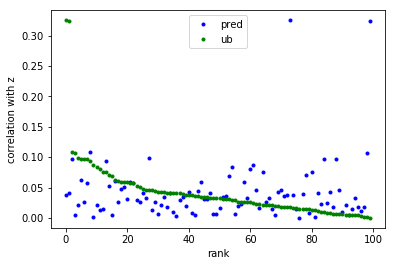

In [18]:

topn = 1000
n_clusters = 100
#topn = 200
#n_clusters = 50


# fit on X on y
clf = LogisticRegression(C=1)
clf.fit(biased_train.X, biased_train.y)
print('top y features')
print_top_terms(clf, feats, n=5)
print('word features, test y acc=%.3f' % metrics.accuracy_score(clf.predict(biased_test.X), biased_test.y))

# cluster positive terms
wordi2cluster = cluster_words(np.argsort(clf.coef_[0])[:topn], feats, w2v, int(n_clusters/2))
wordi2cluster2 = cluster_words(np.argsort(clf.coef_[0])[::-1][:topn], feats, w2v, int(n_clusters/2))
for k,v in wordi2cluster2.items():
    wordi2cluster[k] = v+int(n_clusters/2)
    
    
print_clusters(wordi2cluster, feats)
cluster_terms = get_cluster_terms(wordi2cluster, feats)
    
#X_train_cluster = sp.csr_matrix(scale(words2clusters(biased_train.X, wordi2cluster, n_clusters).todense()))
#X_test_cluster = sp.csr_matrix(scale(words2clusters(biased_test.X, wordi2cluster, n_clusters).todense()))
X_train_cluster = words2clusters(biased_train.X, wordi2cluster, n_clusters)
X_test_cluster = words2clusters(biased_test.X, wordi2cluster, n_clusters)

# classify z based on cluster features
clf = LogisticRegression(C=1)
clf.fit(X_train_cluster, biased_train.z)
print('top z cluster features')
print_top_terms(clf, np.arange(n_clusters), n=5)
print('cluster features, test z acc=%.3f' % metrics.accuracy_score(clf.predict(X_test_cluster), biased_test.z))
print_top_terms_by_correl(X_train_cluster, biased_train.z, cluster_terms)

# classify y based on cluster features
clf = LogisticRegression(C=.01)
clf.fit(X_train_cluster, biased_train.y)
print('top y cluster features')
print_top_terms(clf, np.arange(n_clusters), n=5)
print('cluster features, test y acc=%.3f' % metrics.accuracy_score(clf.predict(X_test_cluster), biased_test.y))
print_top_terms_by_correl(X_train_cluster, biased_train.y, cluster_terms)


# method 2: score each cluster by correlation with each class label.
# sort clusters by how their similarity with these "good" clusters changes from train
# to test.
n_anchors = 1
neg_anchors = np.argsort(clf.coef_[0])[:n_anchors]
pos_anchors = np.argsort(clf.coef_[0])[::-1][:n_anchors]
print('pos anchors=%s, neg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
scores = train_test_anchor_diff(pos_anchors, neg_anchors, X_train_cluster, X_test_cluster, cluster_terms)

eval_confound_finder(scores, X_test_cluster, biased_test.z)

In [179]:
topn = 1000
n_clusters = 10
#topn = 200
#n_clusters = 50

print("Twitter y={}, z={}".format(ystr,zstr))
# fit on X on y
clf = models[1]
clf.set_lambda(0.001)
clf.fit(biased_train,training_epochs=40,display_step=40)
weight_6 = clf.get_weights(-6)
X_train_cluster = get_topic_dist(clf,biased_train)
X_test_cluster = get_topic_dist(clf,biased_test)

biased_train.X_train_cluster = X_train_cluster
biased_test.X_test_cluster = X_test_cluster

# classify z based on cluster features
network_architecture = \
    dict(n_hidden_recog_1=200, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=200,
         #n_hidden_recog_4=200,
         n_hidden_gener_1=biased_train.X_train_cluster.shape[1], # 1st layer decoder neurons
         #n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=biased_train.X_train_cluster.shape[1],
         n_z=num,
        n_output=1)
#imdb dataset: batch_size = 32
#twitter: b_s = 16
model_params = {
    'network_architecture':network_architecture,
    'batch_size':16,
    'learning_rate':0.001,
    'gpu_fraction':0.25,
    'trade_off':0.001,
    'loss':'cross_entropy'
}
clf = DiscriminativeProdLDA(k=biased_train.X_train_cluster.shape[1],m=num,model_params=model_params)
clf.fit(biased_train,x_cluster = True, z = True,training_epochs=40,display_step=40)
coef_ = clf.get_weights(-5).T
print('cluster features, test z acc=%.3f' % metrics.accuracy_score(clf.predict(biased_test,x_cluster=True), biased_test.z))

# classify y based on cluster features
network_architecture = \
    dict(n_hidden_recog_1=200, # 1st layer encoder neurons
         n_hidden_recog_2=200, # 2nd layer encoder neurons
         n_hidden_recog_3=200,
         #n_hidden_recog_4=200,
         n_hidden_gener_1=biased_train.X_train_cluster.shape[1], # 1st layer decoder neurons
         #n_hidden_gener_2=500, # 2nd layer decoder neurons
         n_input=biased_train.X_train_cluster.shape[1],
         n_z=num,
        n_output=1)
#imdb dataset: batch_size = 32
#twitter: b_s = 16
model_params = {
    'network_architecture':network_architecture,
    'batch_size':16,
    'learning_rate':0.001,
    'gpu_fraction':0.25,
    'trade_off':0.001,
    'loss':'cross_entropy'
}
clf = DiscriminativeProdLDA(k=biased_train.X_train_cluster.shape[1],m=num,model_params=model_params)
clf.fit(biased_train,x_cluster=True, z = False,training_epochs=40,display_step=40)
coef_ = clf.get_weights(-5).T
print('cluster features, test y acc=%.3f' % metrics.accuracy_score(clf.predict(biased_test,x_cluster=True), biased_test.y))


# method 2: score each cluster by correlation with each class label.
# sort clusters by how their similarity with these "good" clusters changes from train
# to test.
cluster_terms = d.feature_names
n_anchors = 1
neg_anchors = np.argsort(coef_[0])[:n_anchors]
pos_anchors = np.argsort(coef_[0])[::-1][:n_anchors]
print('pos anchors=%s, neg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
scores = train_test_anchor_diff(pos_anchors, neg_anchors, X_train_cluster, X_test_cluster, cluster_terms,weight_6)

#eval_confound_finder(scores, X_test_cluster, biased_test.z)

Twitter y=location, z=gender
Learning Rate: 0.001
Epoch: 0040 cost= 27696.203718750
Learning Rate: 0.001
Epoch: 0040 cost= 11091.869218750


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Round/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_126_Round", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'Placeholder_2', defined at:
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/asyncio/base_events.py", line 421, in run_forever
    self._run_once()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/asyncio/base_events.py", line 1426, in _run_once
    handle._run()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/asyncio/events.py", line 127, in _run
    self._callback(*self._args)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-179-8b596f47c58c>", line 39, in <module>
    clf.fit(biased_train,x_cluster = True, z = True,training_epochs=40,display_step=40)
  File "/home/ttran/adaptive_confound/adaptive_confound/topic_model/discriminative_prodlda.py", line 75, in fit
    self._build_model()
  File "/home/ttran/adaptive_confound/adaptive_confound/topic_model/discriminative_prodlda.py", line 54, in _build_model
    loss = loss
  File "/home/ttran/adaptive_confound/adaptive_confound/topic_model/tensorflow_impl/prodlda.py", line 55, in __init__
    self.keep_prob = tf.placeholder(tf.float32)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3091, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=<unknown>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Round/_39 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_126_Round", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


#### Method 3

In [13]:
# X_train = train_d[0].X
# model = Sequential()
# model.add(Dense(int(64),input_shape=(X_train.shape[1],), kernel_constraint=maxnorm(10)))
# model.add(Activation('relu'))
# model.add(Dropout(0.4))
# model.add(Dense(2))
# model.add(Activation('softmax'))
# model.compile(loss='categorical_crossentropy',
#     optimizer='adam',
#     metrics=['accuracy'])
# history = model.fit(X_train, y_train,
#                     batch_size=int(16),
#                     epochs=int(30),
#                     verbose=0,
#                     callbacks=
#                                #PlotLossesKeras(),
#                                early_stopper(int(10, mode='strict')
#                     )


In [23]:
from talos.model import early_stopper
import talos as ta
from livelossplot import PlotLossesKeras
## testing: fit a neural net to predict y
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import backend as K
from keras.constraints import maxnorm
from IPython.display import HTML, display
import astetik

def create_model_params(n_input,n_hidden_recog_1,
                       n_hidden_recog_2,n_hidden_recog_3,
                        n_hidden_gener_1,n_z,n_output=1,loss='cross_entropy',batch_size=16,
                       learning_rate=0.001,gpu_frac=0.25,trade_off=0.001):
    network_architecture = \
        dict(n_hidden_recog_1=n_hidden_recog_1, # 1st layer encoder neurons
             n_hidden_recog_2=n_hidden_recog_2, # 2nd layer encoder neurons
             n_hidden_recog_3=n_hidden_recog_3,
             #n_hidden_recog_4=200,
             n_hidden_gener_1=n_hidden_gener_1, # 1st layer decoder neurons
             #n_hidden_gener_2=500, # 2nd layer decoder neurons
             n_input=n_input,
             n_z=n_z,
            n_output=n_output)
    #imdb dataset: batch_size = 32
    #twitter: b_s = 16
    model_params = {
        'network_architecture':network_architecture,
        'batch_size':batch_size,
        'learning_rate':learning_rate,
        'gpu_fraction':gpu_frac,
        'trade_off':trade_off,
        'loss': loss
    }
    return model_params

def baseline_model_f(d,num_topics):#, X_val, y_val):
    """
    For some reason, need to cast to int elements of params.
    talos is somehow converting them to floats.
    """
    network_architecture = \
        dict(n_hidden_1=num_topics, # 1st layer encoder neurons
#              n_hidden_2=200, # 2nd layer encoder neurons
#              n_hidden_3=200,
#              n_hidden_4=100,
             n_input=d.X.shape[1],
             n_output=1)
    #imdb dataset: batch_size = 32
    #twitter: b_s = 16
    model_params = {
        'network_architecture':network_architecture,
        'batch_size':16,
        'learning_rate':0.001,
        'gpu_fraction':0.1,
        'loss': 'cross_entropy'
    }
    model = MLP(k=d.X.shape[1],m=num_topics,
                                  model_params=model_params)
    model.fit(d,training_epochs=100,display_step=100)
    return model


def anchor_model_f(X_train, y_train,num_topics):
    d=Dataset()
    d.X = X_train
    d.y = y_train
    model_params = create_model_params(d.X.shape[1],200,200,200
                                       ,d.X.shape[1],num_topics,n_output=2,loss='mse',trade_off=1e-05)
    model = DiscriminativeProdLDA(k=d.X.shape[1],m=num_topics,
                                  model_params=model_params)
    model.fit(d,anchor=True,training_epochs=250,display_step=250)
    return model
    
    
    
# def final_model_f(X_train, y_train, X_val, y_val, params, input_weights):
#     """
#     """
    

In [24]:
def top_topic_words(model, topici, feats, n=10,anchor=False):
    words = []
    if anchor:
        xzweights = model.get_weights(-6).T
    else:
        xzweights = model.get_weights(0)
        
    for j in np.argsort(xzweights[:,topici])[::-1][:n]:
        words.append('%s/%.3f' % (feats[j], xzweights[j,topici]))
    print('   %s' % ' '.join(words))
    
def print_top_model_weights(model, n_hidden, n_words, feats,anchor=False):
    if anchor:
        zyweights = model.get_weights(-5)
        print('top weights for y=1')
        for i in np.argsort(zyweights[:,0])[::-1][:n_hidden]:
            sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i,0]))
            top_topic_words(model, i, feats, n=n_words,anchor=anchor)

        print('\ntop weights for y=0')
        for i in np.argsort(zyweights[:,0])[:n_hidden]:
            sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i,0]))
            top_topic_words(model, i, feats, n=n_words,anchor=anchor)
    else:
        zyweights = model.get_weights(1).T[0]
        print('top weights for y=1')
        for i in np.argsort(zyweights)[::-1][:n_hidden]:
            sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i]))
            top_topic_words(model, i, feats, n=n_words,anchor=anchor)

        print('\ntop weights for y=0')
        for i in np.argsort(zyweights)[:n_hidden]:
            sys.stdout.write('%d\t%.3f\t'% (i, zyweights[i]))
            top_topic_words(model, i, feats, n=n_words,anchor=anchor)
    
def get_activations(model,X_batch):
    # get latent representation for an instance.
    """Get the raw softmax(z) for each instance?"""
    d = Dataset()
    d.X = X_batch
    return model.transform(d)
    

def print_top_correlations(model, X, y, feats,anchor=False):
    # get top correlations between each hidden layer and label y
    activations = get_activations(model, X.todense())
    corrsy = [pearsonr(activations[:,vari], y)[0] for vari in range(activations.shape[1])]
    plt.figure()
    plt.plot(sorted(corrsy))
    plt.ylabel('correlation with label')
    plt.xlabel('topic rank')
    plt.show()
    print('\n\ntop correlating topics for label=1')
    for ti in np.argsort(corrsy)[::-1][:5]:
        top_topic_words(model, ti, feats, n=5,anchor=anchor)
    print('\ntop correlating topics for label=0')
    for ti in np.argsort(corrsy)[:5]:
        top_topic_words(model, ti, feats, n=5,anchor=anchor)
        
# def get_cv_activations(train_f, X, y, hidden_indices, layer, parms, n_splits=3):
# oops - this is impossible, since the hidden layers will change on each split...
#     kf = KFold(n_splits=n_splits)
#     acts = np.zeros((X.shape[0])
#     for traini, testi in kf.split(X):
#         model = train_f(X[traini], y[traini], X[testi], y[testi], parms)
#         acts = get_activations(model, layer, X[testi])

# now, predict anchor topic values on train and test.
def get_anchor_topics(model, X, y, n):
    activations = get_activations(model, X.todense())
    corrsy = [pearsonr(activations[:,vari], y)[0] for vari in range(activations.shape[1])]
    negi = np.argsort(corrsy)[:n]
    posi = np.argsort(corrsy)[::-1][:n]
    return posi, negi,corrsy[posi[0]],corrsy[negi[0]]

def get_anchor_labels(model, anchors, X):
    activations = get_activations(model, X.todense())
    return activations[:,anchors]


# def train_baseline_model(x, y, parms, file_suffix):
    
#     model = baseline_model_f(x, y, x[-10:], y[-10:], get_best_params(parms, report, 'val_acc', False))
#     return model

def diagnose_anchors(pos_anchors, neg_anchors, anchor_labels_train, anchor_labels_test):
    print('first anchor in train:')
    print(anchor_labels_train[0])
    print('first anchor in test:')
    print(anchor_labels_test[0])
    print('max pos in train:%.6g' % anchor_labels_train[:,0].max())
    print('max pos in test:%.6g' % anchor_labels_test[:,0].max())
    print('min pos in train:%.6g' % anchor_labels_train[:,0].min())
    print('min pos in test:%.6g' % anchor_labels_test[:,0].min())
    # do distribution of anchor labels vary from train->test?
    plt.figure()
    for i, p in enumerate(pos_anchors):
        plt.plot(sorted(anchor_labels_train[:,i]), label='pos_%d_train' % i, alpha=.5)
        plt.plot(sorted(anchor_labels_test[:,i]), '--', label='pos_%d_test' % i, alpha=.5)
        print('pos_%d_train mean=%.6g pos_%d_test mean=%.6g'% (i, anchor_labels_train[:,i].mean(),
                                                               i, anchor_labels_test[:,i].mean()))
    for i, p in enumerate(neg_anchors):
        i = len(pos_anchors) + i
        plt.plot(sorted(anchor_labels_train[:,i]), label='neg_%d_train' % i, alpha=.5)
        plt.plot(sorted(anchor_labels_test[:,i]), '--', label='neg_%d_test' % i, alpha=.5)
        print('neg_%d_train mean=%.6g neg_%d_test mean=%.6g'% (i, anchor_labels_train[:,i].mean(),
                                                               i, anchor_labels_test[:,i].mean()))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def train_anchor_model(model, biased_train, biased_test):
    pos_anchors, neg_anchors,pos_val,neg_val = get_anchor_topics(model, biased_train.X, biased_train.y, 1)
    print('pos_anchors=%s\nneg_anchors=%s' % (str(pos_anchors), str(neg_anchors)))
    print('Positive correlation value = {}, negative = {}'.format(pos_val,neg_val))
    anchor_labels_train = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_train.X)
    anchor_labels_test = get_anchor_labels(model, np.concatenate((pos_anchors, neg_anchors)), biased_test.X)
    diagnose_anchors(pos_anchors, neg_anchors, anchor_labels_train, anchor_labels_test)
    ### TO discover bad topics, flip test labels.
    anchor_labels_test *= -1    
    ### this indeed make the model very bad, though the top topics don't look very gender related
    X_anchor = sp.vstack((biased_train.X, biased_test.X))
    y_anchor = np.concatenate((anchor_labels_train, anchor_labels_test))
    #return X_anchor, y_anchor
    anchor_model = anchor_model_f(X_anchor.todense(), y_anchor,100)
                                 #X_anchor[-10:].todense(), y_anchor[-10:])
    return anchor_model

# def train_final_model(x, y, input_weights, parms_all, file_suffix):
#     # final model re-uses first layer, so no need to tune that.
#     parms = dict(parms_all)
#     parms['n_hidden'] = [input_weights[0].shape[1]]
#     fff = functools.partial(final_model_f, input_weights=input_weights)
#     t = ta.Scan(x=x,
#                 y=y,
#                 model=fff, #final_model_f,
#                 search_method='linear',
#                 grid_downsample=1, 
#                 params=parms,
#                 dataset_name='final',
#                 experiment_no='k_%s' % file_suffix)
#     report = ta.Reporting('final_k_%s.csv' % file_suffix)
#     display(report.data)
#     history, model = fff(x, y, x[-10:], y[-10:], get_best_params(parms, report, 'val_acc', False))
#     return model

def print_model_info(model, biased_train,anchor=False):
    feats = biased_train.features
    #feats = d.feature_names
    display(HTML('<h3>Top weights</h2>'))
    print_top_model_weights(model, 5, 5, feats,anchor=anchor)
    display(HTML('<h3>Top correlations with Y</h2>'))
    print_top_correlations(model, biased_train.X, biased_train.y, feats,anchor=anchor)
    display(HTML('<h3>Top correlations with Z</h2>'))
    print_top_correlations(model, biased_train.X, biased_train.z, feats,anchor=anchor)

In [25]:
d = d.make_balanced_dataset()
#number = 15000
number = 1000
d.create_biased_datasets(number,[.1,.9],k=1)
biased_train = [d1 for d1 in d.get_biased_datasets(kind='train') if abs(d1.get_bias()-.1) < .1][0]
biased_test = [d1 for d1 in d.get_biased_datasets(kind='test') if abs(d1.get_bias()-.9) < .1][0]

Epoch: 0100 cost= 0.004066870


top weights for y=1
22	0.657	   visible/0.551 hesitate/0.533 sheesh/0.501 snuff/0.497 bold/0.494
86	0.644	   hesitate/0.616 visible/0.534 snuff/0.516 explode/0.495 indulgence/0.494
32	0.640	   hesitate/0.652 brite/0.580 snuff/0.573 smithee/0.509 chat/0.509
56	0.622	   visible/0.587 continued/0.547 hesitate/0.543 chaotic/0.527 indulgence/0.498
17	0.622	   sorrow/0.557 visible/0.551 wear/0.503 hesitate/0.501 snuff/0.498

top weights for y=0
40	-0.641	   bawdy/0.554 macy/0.553 frat/0.548 penny/0.520 provider/0.519
33	-0.612	   barman/0.572 apple/0.558 chaplin/0.554 _NUMBER_nd/0.541 lackluster/0.531
61	-0.608	   wayans/0.549 provider/0.536 possesses/0.531 stretching/0.524 prefer/0.521
95	-0.602	   chan/0.632 provider/0.579 barman/0.570 frat/0.567 poking/0.548
84	-0.590	   rolled/0.598 veterans/0.543 technically/0.521 featuring/0.516 murphy/0.505


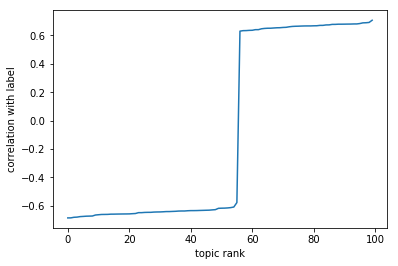



top correlating topics for label=1
   hesitate/0.616 visible/0.534 snuff/0.516 explode/0.495 indulgence/0.494
   sorrow/0.557 visible/0.551 wear/0.503 hesitate/0.501 snuff/0.498
   wear/0.604 dive/0.529 mini/0.507 crashed/0.499 brite/0.486
   visible/0.587 continued/0.547 hesitate/0.543 chaotic/0.527 indulgence/0.498
   visible/0.551 hesitate/0.533 sheesh/0.501 snuff/0.497 bold/0.494

top correlating topics for label=0
   bawdy/0.580 griswold/0.528 minnie/0.525 thereof/0.518 dumbing/0.508
   veterans/0.553 rugby/0.552 aaron/0.548 tokyo/0.518 insults/0.518
   stretching/0.550 murphy/0.534 frat/0.533 minnie/0.531 fetched/0.529
   murphy/0.550 wayans/0.547 penny/0.520 veterans/0.515 lizzie/0.503
   suggestion/0.548 counted/0.544 fetched/0.542 flik/0.521 rolled/0.515


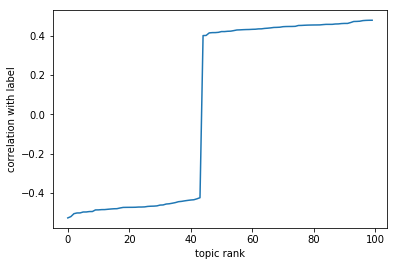



top correlating topics for label=1
   suggestion/0.548 counted/0.544 fetched/0.542 flik/0.521 rolled/0.515
   veterans/0.553 rugby/0.552 aaron/0.548 tokyo/0.518 insults/0.518
   barman/0.572 apple/0.558 chaplin/0.554 _NUMBER_nd/0.541 lackluster/0.531
   stretching/0.550 murphy/0.534 frat/0.533 minnie/0.531 fetched/0.529
   bawdy/0.580 griswold/0.528 minnie/0.525 thereof/0.518 dumbing/0.508

top correlating topics for label=0
   hesitate/0.526 boomers/0.509 expectation/0.501 coma/0.495 drifts/0.493
   hesitate/0.616 visible/0.534 snuff/0.516 explode/0.495 indulgence/0.494
   hesitate/0.576 snuff/0.566 wear/0.560 indulgence/0.529 gwtw/0.525
   visible/0.587 continued/0.547 hesitate/0.543 chaotic/0.527 indulgence/0.498
   wear/0.604 dive/0.529 mini/0.507 crashed/0.499 brite/0.486


pos_anchors=[86]
neg_anchors=[45]
Positive correlation value = 0.7072326741428192, negative = -0.6845752235687105
first anchor in train:
[ 0.18632595  0.7086494 ]
first anchor in test:
[ 0.81094015  0.07824793]
max pos in train:6.56756
max pos in test:6.29513
min pos in train:2.78946e-05
min pos in test:0.000370315
pos_0_train mean=0.75395 pos_0_test mean=0.659595
neg_1_train mean=0.69646 neg_1_test mean=0.605201


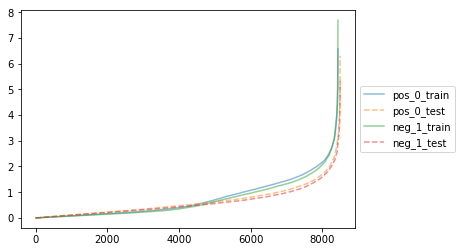

Learning Rate: 0.001
Epoch: 0100 cost= 794.512031232


top weights for y=1
94	0.386	   coolio/0.458 nudie/0.415 schnaas/0.414 manos/0.386 ohhhh/0.354
46	0.354	   gash/0.321 offal/0.272 buechler/0.224 gargoyle/0.201 jacking/0.201
64	0.306	   moovie/0.403 linnea/0.367 moocow/0.350 quigley/0.306 chupacabra/0.304
40	0.298	   piranha/0.395 chupacabra/0.381 zombi/0.335 linnea/0.296 sabertooth/0.293
67	0.271	   hildegard/0.250 knef/0.250 thicker/0.203 turhan/0.181 lederer/0.181

top weights for y=0
81	-0.286	   hawes/0.902 glories/0.823 racking/0.812 gooding/0.792 stirling/0.789
54	-0.258	   changi/0.754 brokedown/0.610 memento/0.600 textures/0.579 maratonci/0.579
22	-0.257	   beowulf/0.787 nolan's/0.669 lambert/0.648 krug/0.617 maratonci/0.617
29	-0.240	   glories/0.824 caribou/0.824 hisses/0.793 hightower/0.770 singaporean/0.752
15	-0.230	   davidians/0.377 evangelical/0.324 outsourced/0.298 stemmed/0.258 irreversible/0.249


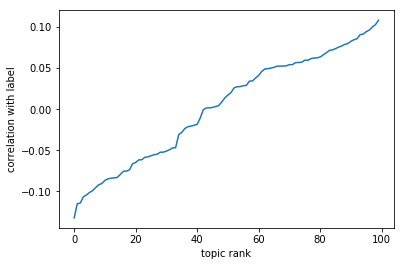



top correlating topics for label=1
   wardh/0.268 pistilli/0.256 scorpion's/0.223 siu/0.206 mathilda/0.205
   transylvania/0.327 plesiosaur/0.266 cryptozoologist/0.263 humanoid/0.244 interstellar/0.233
   gash/0.321 offal/0.272 buechler/0.224 gargoyle/0.201 jacking/0.201
   sergeants/0.235 din/0.211 gunga/0.211 waltzes/0.186 amicus/0.174
   entertainingly/0.275 bodybuilders/0.237 cliver/0.233 triad/0.187 scorpio/0.185

top correlating topics for label=0
   chappelle/0.380 heero/0.368 warburton/0.356 mencia/0.355 spongebob/0.343
   dutta/0.626 knoxville/0.452 devgan/0.444 abhishek/0.433 foley's/0.424
   pca/0.400 mencia/0.374 chappelle/0.331 katrina/0.290 brook's/0.280
   intercontinental/0.455 wwe's/0.385 hilliard/0.323 wrestlemania/0.318 aweigh/0.296
   sox/0.303 schoolteacher/0.272 fallon's/0.251 farrelly/0.242 dismantling/0.235


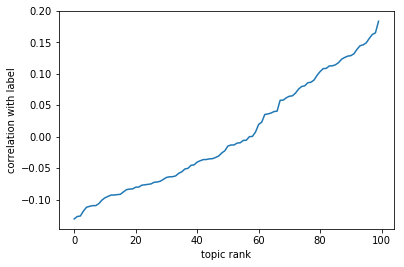



top correlating topics for label=1
   chappelle/0.380 heero/0.368 warburton/0.356 mencia/0.355 spongebob/0.343
   columnist/0.323 winslow/0.299 mendes/0.253 feresten/0.241 poehler/0.226
   intercontinental/0.400 wrestlemania/0.347 churlish/0.344 marilu/0.335 henner/0.326
   pca/0.400 mencia/0.374 chappelle/0.331 katrina/0.290 brook's/0.280
   mencia/0.525 kronk/0.479 yzma/0.467 heero/0.441 chappelle/0.427

top correlating topics for label=0
   tsing/0.280 siu/0.216 taoist/0.216 scarves/0.216 yin/0.207
   sergeants/0.235 din/0.211 gunga/0.211 waltzes/0.186 amicus/0.174
   deceitful/0.213 finlay's/0.207 bathrobe/0.207 exonerate/0.207 omnipotent/0.206
   woodland/0.237 storaro/0.237 scorpion's/0.195 plumage/0.183 argento's/0.164
   omnipotent/0.255 stances/0.226 metwally/0.206 guevara's/0.204 interrogator/0.199


In [130]:
# train initial model
display(HTML('<br><br><hr><h1>Training baseline model - IMDB Dataset</h1>'))
model = baseline_model_f(biased_train,100)
og_acc = model.evaluate(biased_test)
display(HTML('<h3>test accuracy=%.3f</h3>' % og_acc))
print_model_info(model, biased_train)

# train anchor model
display(HTML('<br><br><hr><h1>Training anchor model</h1>'))
anchor_model = train_anchor_model(model, biased_train, biased_test)
print_model_info(anchor_model, biased_train,anchor=True)

Epoch: 0100 cost= 0.058284907


top weights for y=1
45	0.153	   delays/0.298 rec/0.288 enforcement/0.281 nasty/0.280 elitedaily/0.278
95	0.149	   deadass/0.323 brooklyn/0.318 ny/0.279 regents/0.270 mdw/0.266
59	0.147	   ny/0.354 nyc/0.322 brooklyn/0.318 nj/0.270 nytimes/0.256
79	0.134	   ny/0.302 nydailynews/0.282 macys/0.273 brooklyn/0.261 lovee/0.255
73	0.133	   cutter/0.316 ussoccer/0.304 disliked/0.302 nydailynews/0.295 shaker/0.294

top weights for y=0
46	-0.173	   e3/0.403 angeles/0.383 losangeles/0.350 los/0.344 california/0.340
39	-0.155	   angeles/0.373 california/0.339 los/0.318 losangeles/0.307 burbank/0.299
90	-0.152	   participate/0.529 childhood/0.495 battle/0.446 hola/0.431 soy/0.416
52	-0.144	   participate/0.507 childhood/0.429 soy/0.408 hola/0.402 came/0.395
96	-0.131	   hola/0.414 soy/0.395 participate/0.389 losangeles/0.322 battle/0.290


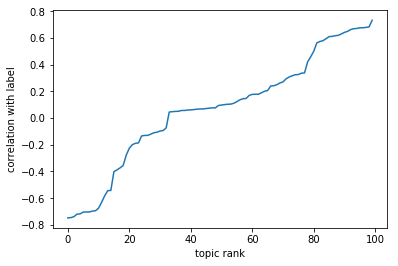



top correlating topics for label=1
   regents/0.301 laguardia/0.297 rec/0.293 lga/0.284 cynthia/0.269
   ny/0.302 nydailynews/0.282 macys/0.273 brooklyn/0.261 lovee/0.255
   brooklyn/0.325 ny/0.307 nyc/0.275 mta/0.264 regents/0.261
   ny/0.354 nyc/0.322 brooklyn/0.318 nj/0.270 nytimes/0.256
   ny/0.307 brooklyn/0.285 yankees/0.281 nj/0.269 upstate/0.253

top correlating topics for label=0
   monica/0.364 losangeles/0.336 angeles/0.335 e3/0.323 ucla/0.321
   angeles/0.358 losangeles/0.349 ucla/0.315 los/0.314 e3/0.267
   monica/0.321 losangeles/0.319 angeles/0.305 ucla/0.300 burbank/0.299
   e3/0.403 angeles/0.383 losangeles/0.350 los/0.344 california/0.340
   soy/0.324 angeles/0.317 dodgers/0.303 losangeles/0.295 ucla/0.292


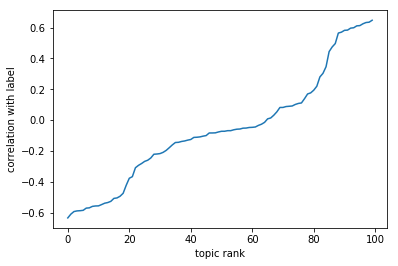



top correlating topics for label=1
   angeles/0.358 losangeles/0.349 ucla/0.315 los/0.314 e3/0.267
   monica/0.321 losangeles/0.319 angeles/0.305 ucla/0.300 burbank/0.299
   monica/0.364 losangeles/0.336 angeles/0.335 e3/0.323 ucla/0.321
   losangeles/0.364 angeles/0.362 redondo/0.310 ucla/0.302 disneyland/0.301
   angeles/0.385 los/0.365 e3/0.362 ucla/0.343 usc/0.343

top correlating topics for label=0
   regents/0.301 laguardia/0.297 rec/0.293 lga/0.284 cynthia/0.269
   brooklyn/0.325 ny/0.307 nyc/0.275 mta/0.264 regents/0.261
   brooklyn/0.316 ny/0.292 nj/0.253 mta/0.248 bk/0.247
   ny/0.302 nydailynews/0.282 macys/0.273 brooklyn/0.261 lovee/0.255
   nj/0.375 nyc/0.328 deadass/0.306 mta/0.302 regents/0.300


pos_anchors=[66]
neg_anchors=[77]
Positive correlation value = 0.7326979376576682, negative = -0.7477823787410062
first anchor in train:
[  1.23852654e+01   3.97534715e-03]
first anchor in test:
[ 26.34776688   6.20185757]
max pos in train:95.1251
max pos in test:39.4868
min pos in train:2.30723e-19
min pos in test:2.3913e-07
pos_0_train mean=11.8761 pos_0_test mean=10.0493
neg_1_train mean=10.8553 neg_1_test mean=8.72703


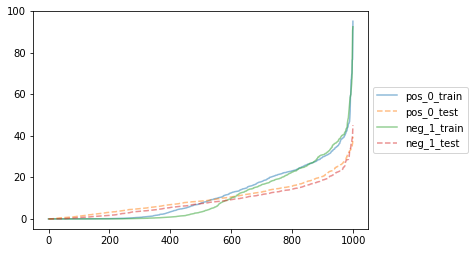

Learning Rate: 0.001
Epoch: 0100 cost= 22923.658914063


top weights for y=1
43	2.993	   femaleproblems/0.166 country_words/0.154 cravemythoughts/0.150 chloeonvine/0.139 dayy/0.138
12	2.831	   sorrynotsoorry/0.172 frowned/0.171 birthdayyy/0.171 omgg/0.161 country_words/0.160
56	2.810	   dayy/0.133 country_words/0.123 macaron/0.115 commonwhitegrl/0.109 imissyou/0.109
60	2.804	   babyyyy/0.180 suckstosuck/0.166 lovee/0.160 country_words/0.160 girlies/0.158
82	2.503	   albeit/0.200 centralparknyc/0.129 vendors/0.128 spreadsheet/0.124 enabling/0.117

top weights for y=0
7	-1.439	   harvin/0.320 notsportscenter/0.319 shumpert/0.292 mysportslegion/0.248 76ers/0.248
93	-1.417	   notsportscenter/0.401 iverson/0.339 mysportslegion/0.335 stephenasmith/0.330 wojyahoonba/0.314
30	-1.379	   bruhhhh/0.522 theracedraft/0.455 bruhhh/0.414 woridstarhlphop/0.408 jackassvine/0.406
46	-1.363	   lakersnation/0.292 kobebryant/0.289 espnnba/0.272 westbrook/0.270 magicjohnson/0.263
13	-1.344	   notsportscenter/0.309 things4whiteppl/0.290 theracedraft/0.277 lebrons/

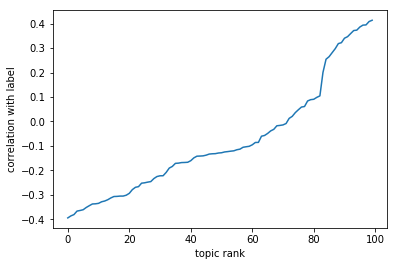



top correlating topics for label=1
   babyyyy/0.180 suckstosuck/0.166 lovee/0.160 country_words/0.160 girlies/0.158
   dayy/0.133 country_words/0.123 macaron/0.115 commonwhitegrl/0.109 imissyou/0.109
   whitegrlproblem/0.144 macaron/0.136 mcqueen/0.126 maureen/0.125 knowww/0.120
   sorrynotsoorry/0.172 frowned/0.171 birthdayyy/0.171 omgg/0.161 country_words/0.160
   wahh/0.316 kourtneykardash/0.285 robkardashian/0.270 betches/0.264 giulianarancic/0.260

top correlating topics for label=0
   harvin/0.320 notsportscenter/0.319 shumpert/0.292 mysportslegion/0.248 76ers/0.248
   notsportscenter/0.401 iverson/0.339 mysportslegion/0.335 stephenasmith/0.330 wojyahoonba/0.314
   buster_espn/0.181 sportsguy33/0.179 bobcats/0.177 interceptions/0.176 jimrome/0.166
   rapsheet/0.260 jimrome/0.256 wojyahoonba/0.249 cbssports/0.248 yasielpuig/0.242
   tyranny/0.201 wojyahoonba/0.191 prisons/0.183 limbaugh/0.180 strikeouts/0.175


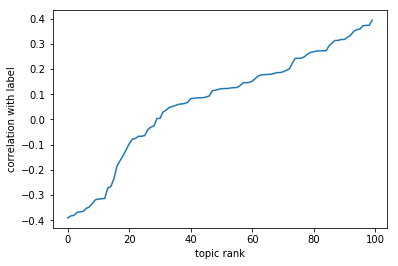



top correlating topics for label=1
   notsportscenter/0.315 jameis/0.251 heisman/0.245 jimrome/0.244 beltran/0.243
   harvin/0.320 notsportscenter/0.319 shumpert/0.292 mysportslegion/0.248 76ers/0.248
   notsportscenter/0.401 iverson/0.339 mysportslegion/0.335 stephenasmith/0.330 wojyahoonba/0.314
   buster_espn/0.181 sportsguy33/0.179 bobcats/0.177 interceptions/0.176 jimrome/0.166
   rapsheet/0.260 jimrome/0.256 wojyahoonba/0.249 cbssports/0.248 yasielpuig/0.242

top correlating topics for label=0
   babyyyy/0.180 suckstosuck/0.166 lovee/0.160 country_words/0.160 girlies/0.158
   whitegrlproblem/0.144 macaron/0.136 mcqueen/0.126 maureen/0.125 knowww/0.120
   dayy/0.133 country_words/0.123 macaron/0.115 commonwhitegrl/0.109 imissyou/0.109
   sorrynotsoorry/0.172 frowned/0.171 birthdayyy/0.171 omgg/0.161 country_words/0.160
   wahh/0.316 kourtneykardash/0.285 robkardashian/0.270 betches/0.264 giulianarancic/0.260


In [149]:
# train initial model
display(HTML('<br><br><hr><h1>Training baseline model - Twitter z={} dataset</h1>'.format(zstr)))
model = baseline_model_f(biased_train,100)
og_acc = model.evaluate(biased_test)
display(HTML('<h3>test accuracy=%.3f</h3>' % og_acc))
print_model_info(model, biased_train)

# train anchor model
display(HTML('<br><br><hr><h1>Training anchor model</h1>'))
anchor_model = train_anchor_model(model, biased_train, biased_test)
print_model_info(anchor_model, biased_train,anchor=True)

Epoch: 0100 cost= 0.169294288


top weights for y=1
46	0.173	   angeles/0.303 dodge/0.260 ventura/0.256 nintendo/0.249 challenger/0.243
59	0.166	   angeles/0.324 lakers/0.282 los/0.263 sacrifice/0.263 canyon/0.261
13	0.145	   fresno/0.322 sacramento/0.306 lakers/0.271 todays/0.271 burbank/0.270
36	0.135	   puss/0.305 kung/0.282 dirt/0.280 chevy/0.275 gol/0.274
74	0.131	   angeles/0.341 los/0.317 pasadena/0.300 costco/0.279 lax/0.269

top weights for y=0
93	-0.153	   relaxvibes/0.325 milo/0.266 noooo/0.261 bundle/0.261 homerun/0.260
31	-0.144	   outfits/0.338 goodreads/0.314 ranch/0.313 flattering/0.310 sunset/0.304
8	-0.140	   manicure/0.276 nails/0.266 beloved/0.260 happier/0.257 bedtime/0.256
97	-0.137	   ranch/0.282 sunset/0.236 kay/0.228 96/0.207 theworldstories/0.204
44	-0.131	   mother/0.401 kiss/0.377 needs/0.375 ranch/0.364 sunset/0.346


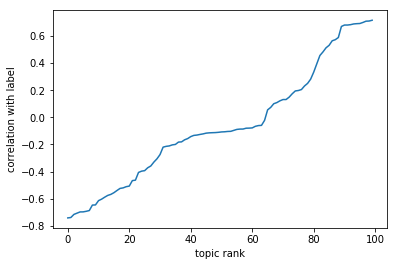



top correlating topics for label=1
   angeles/0.325 lax/0.310 sacrifice/0.287 alleged/0.282 los/0.271
   lakers/0.340 dodgers/0.326 lax/0.297 angeles/0.294 anaheim/0.260
   lakers/0.287 angeles/0.269 lax/0.257 journey/0.241 los/0.228
   angeles/0.332 disneyland/0.312 los/0.289 lakers/0.283 xbox/0.280
   angeles/0.293 losangeles/0.290 ca/0.279 gamer/0.277 los/0.267

top correlating topics for label=0
   jacqueline/0.267 brooklyn/0.265 esp/0.249 margarita/0.247 nyc/0.245
   chanelpuke/0.304 regents/0.292 biker/0.247 winged/0.246 mother/0.244
   beloved/0.251 mommy/0.238 wool/0.232 nj/0.230 cutest/0.226
   gatsby/0.265 vmas/0.247 soexcited/0.247 cutest/0.243 jumps/0.242
   bedtime/0.283 bushwick/0.250 yorkers/0.248 envy/0.245 girlpower/0.242


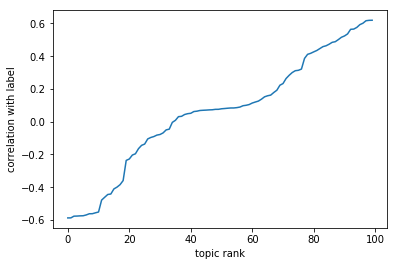



top correlating topics for label=1
   jacqueline/0.267 brooklyn/0.265 esp/0.249 margarita/0.247 nyc/0.245
   chanelpuke/0.304 regents/0.292 biker/0.247 winged/0.246 mother/0.244
   thecut/0.215 dvf/0.215 cutest/0.214 bridal/0.202 yummy/0.200
   beloved/0.251 mommy/0.238 wool/0.232 nj/0.230 cutest/0.226
   gatsby/0.265 vmas/0.247 soexcited/0.247 cutest/0.243 jumps/0.242

top correlating topics for label=0
   burbank/0.234 pico/0.224 lakersnation/0.210 los/0.209 blackandwhite/0.209
   angeles/0.332 disneyland/0.312 los/0.289 lakers/0.283 xbox/0.280
   angeles/0.334 legendary/0.285 fresno/0.283 sacramento/0.283 barber/0.278
   angeles/0.293 losangeles/0.290 ca/0.279 gamer/0.277 los/0.267
   angeles/0.325 lax/0.310 sacrifice/0.287 alleged/0.282 los/0.271


pos_anchors=[27]
neg_anchors=[57]
Positive correlation value = 0.7155172239709786, negative = -0.7418746830483788
first anchor in train:
[  4.48670647e-07   5.16850662e+00]
first anchor in test:
[ 6.06327438  5.90600348]
max pos in train:74.051
max pos in test:42.7106
min pos in train:1.47344e-38
min pos in test:1.01134e-14
pos_0_train mean=8.73133 pos_0_test mean=5.23353
neg_1_train mean=10.8523 neg_1_test mean=8.38619


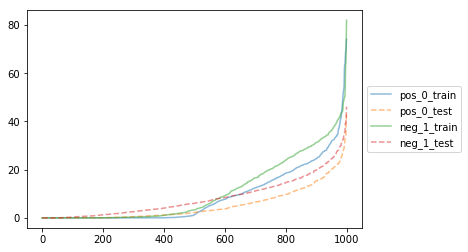

Learning Rate: 0.001
Epoch: 0250 cost= 10063985.521999996


top weights for y=1
60	7.487	   okafor/-0.047 paugasol/-0.047 torrance/-0.049 lakeshow/-0.051 nickswagypyoung/-0.051
78	6.914	   prequel/-0.044 dunn/-0.048 facilities/-0.051 mutually/-0.060 mounted/-0.061
43	6.862	   californication/-0.048 westlake/-0.049 helmets/-0.050 moth/-0.054 henny/-0.057
92	6.568	   eastbound/-0.021 tue/-0.030 roo/-0.030 albuquerque/-0.031 jaime/-0.035
77	6.552	   worldstarcomedy/-0.053 cleats/-0.055 lupe/-0.056 sac/-0.056 athletics/-0.057

top weights for y=0
17	-9.399	   76ers/0.299 battled/0.293 sixers/0.291 cut4/0.284 hornets/0.281
67	-8.103	   therealjrsmith/0.261 sixers/0.227 woodson/0.214 dwyane/0.209 bayless/0.201
11	-7.891	   bayless/0.238 romo/0.226 sportsnation/0.214 randle/0.213 nyr/0.212
6	-7.859	   isles/0.244 jmanziel2/0.239 therealjrsmith/0.230 tanaka/0.230 knick/0.212
85	-7.789	   therealjrsmith/0.239 tanaka/0.230 felton/0.225 woodson/0.220 isles/0.216


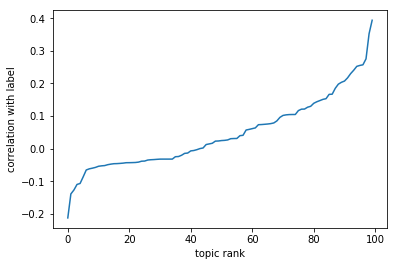



top correlating topics for label=1
   la/1.660 via/1.659 los/1.490 awesome/1.352 photo/1.223
   via/1.639 la/1.537 los/1.529 awesome/1.420 photo/1.370
   los/0.615 puig/0.552 angeles/0.537 ps3/0.505 elonmusk/0.504
   aquí/0.221 ideology/0.216 e32015/0.213 iraqi/0.209 islamic/0.205
   demarco/0.084 1100/0.076 herrera/0.070 figueroa/0.063 poder/0.057

top correlating topics for label=0
   arrivals/0.023 peoplemag/0.005 shondarhimes/-0.004 playbill/-0.004 shana/-0.004
   govballnyc/-0.042 patricia/-0.057 everrrr/-0.059 iloveny/-0.060 morocco/-0.065
   vulture/-0.078 iloveny/-0.082 thecut/-0.082 madmen/-0.084 hubs/-0.087
   whitegrlproblem/-0.013 motherhood/-0.030 flatiron/-0.032 patricia/-0.033 whitegirlproblems/-0.033
   adage/-0.094 hedwig/-0.095 bikram/-0.100 cuddly/-0.101 pnc/-0.102


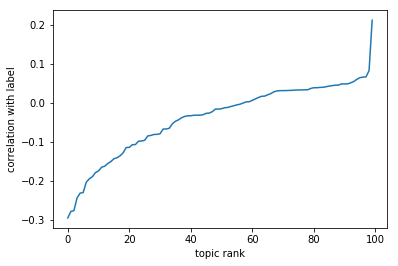



top correlating topics for label=1
   arrivals/0.023 peoplemag/0.005 shondarhimes/-0.004 playbill/-0.004 shana/-0.004
   govballnyc/-0.042 patricia/-0.057 everrrr/-0.059 iloveny/-0.060 morocco/-0.065
   unions/0.763 taxpayers/0.728 democrats/0.716 fracking/0.696 boehner/0.689
   playbill/-0.127 nile/-0.131 madmen/-0.132 radcliffe/-0.132 ava/-0.133
   whitegrlproblem/-0.013 motherhood/-0.030 flatiron/-0.032 patricia/-0.033 whitegirlproblems/-0.033

top correlating topics for label=0
   via/1.639 la/1.537 los/1.529 awesome/1.420 photo/1.370
   los/0.615 puig/0.552 angeles/0.537 ps3/0.505 elonmusk/0.504
   sgt/0.093 mujer/0.061 geoffrey/0.061 judith/0.060 ny1/0.054
   demarco/0.084 1100/0.076 herrera/0.070 figueroa/0.063 poder/0.057
   aquí/0.221 ideology/0.216 e32015/0.213 iraqi/0.209 islamic/0.205


In [26]:
# train initial model
display(HTML('<br><br><hr><h1>Training baseline model - Twitter z={} dataset</h1>'.format(zstr)))
model = baseline_model_f(biased_train,100)
og_acc = model.evaluate(biased_test)
display(HTML('<h3>test accuracy=%.3f</h3>' % og_acc))
print_model_info(model, biased_train)

# train anchor model
display(HTML('<br><br><hr><h1>Training anchor model</h1>'))
anchor_model = train_anchor_model(model, biased_train, biased_test)
print_model_info(anchor_model, biased_train,anchor=True)

### MAN Model

In [57]:
d_test = d.make_confounding_dataset(0.8,2000)

In [58]:
d_test = d_test.make_zbiased_dataset(0.8,1000)
d_test

< Dataset: size=1200, p(y)=0.58, p(z)=0.67, bias=0.80, parent=< Dataset: size=2000, p(y)=0.50, p(z)=0.50, bias=0.80, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > > > > > > >

In [48]:
zprob_train = np.linspace(.4,.8,5)[::-1]
zprob_train

array([0.8, 0.7, 0.6, 0.5, 0.4])

In [9]:

#number = 15000
number = 1000
zprob_train = np.linspace(.4,.8,5)
zprob_test = np.linspace(.4,.8,5)[::-1]
pygz_train = np.linspace(.4,.8,5)[::-1]
pygz_test = np.linspace(.4,.8,5)
data=[]
for tr, te in list(zip(pygz_train,pygz_test)):
    d_tr = d.make_confounding_dataset(round(tr,2),2000)
    d_te = d.make_confounding_dataset(round(te,2),2000)
    for train_prob, test_prob in list(zip(zprob_train,zprob_test)):
        data.append((d_tr.make_zbiased_dataset(round(train_prob,2), 1000),d_te.make_zbiased_dataset(round(test_prob,2),1000)))

In [12]:
for i in range(len(data)):
    if data[i][0].get_size() != 1000 or data[i][1].get_size() != 1000:
        data.pop(i)
        #print(data[i])

In [14]:
dict_data = defaultdict(list)
for dat in data:
    dict_data['bias={}'.format(round(dat[0].get_bias(),2))].append(dat)
dict(dict_data)

{'bias=0.8': [(< Dataset: size=1000, p(y)=0.50, p(z)=0.40, bias=0.80, parent=< Dataset: size=2000, p(y)=0.50, p(z)=0.50, bias=0.80, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > > > >,
   < Dataset: size=1000, p(y)=0.50, p(z)=0.80, bias=0.40, parent=< Dataset: size=2000, p(y)=0.50, p(z)=0.50, bias=0.40, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > > > >),
  (< Dataset: size=1000, p(y)=0.50, p(z)=0.50, bias=0.80, parent=< Dataset: size=2000, p(y)=0.50, p(z)=0.50, bias=0.80, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > > > >,
   < Dataset: size=1000, p(y)=0.50, p(z)=0.70, bias=0.40, parent=< Dataset: size=2000, p(y)=0.50, p(z)=0.50, bias=0.40, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< D

TODO: do exp to show MAN work: P(z) and P(y|z) changes

In [39]:
from sklearn import metrics

In [40]:
from collections import Counter

Possible exp: gender is not the only predictive feature of y => LR still can get enough info from other features to predict => stable

In [ ]:
#P(Z) changing only exp
number = 1000
zprob_train = np.linspace(.1,.9,9)[:5]
zprob_test = np.linspace(.1,.9,9)[::-1][:5]
accuracy_man = []
accuracy_lr = []
bias_diff=[]
losses = {}
for prob_train, prob_test in list(zip(zprob_train,zprob_test)):
    model = MultinomialAdversarialNetwork(k=d.X.shape[1],m=num)
    lr = LogisticRegression()
    d_dict = {}
    d_dict['train'] = d.make_zbiased_dataset(round(prob_train,2), 1000)
    d_dict['test'] = d.make_zbiased_dataset(round(prob_test,2),1000)
    bias_diff.append(abs(d_dict['train'].get_pz()-d_dict['test'].get_pz()))
    loss_d, l_d, l_c = model.fit(d_dict,display_step=200)
    losses[(prob_train,prob_test)] = [loss_d,l_d,l_c]
    lr.fit(d_dict['train'].X,d_dict['train'].y)
    #preds = model.transform(d_dict)
    #preds = np.array([_.tolist() for _ in preds])
    accuracy_man.append(model.transform(d_dict)[0])
    accuracy_lr.append(metrics.accuracy_score(d_dict['test'].y,lr.predict(d_dict['test'].X)))

In [10]:
for key,val in losses.items():
    epochs = np.linspace(1,100,100)
    fig, ax = plt.subplots()
    #ax.set_yscale('log')
    ax.plot(epochs,val[0],'go-',label = 'Loss_d')
    ax.plot(epochs,val[1],'bo-.',label = 'l_d')
    ax.plot(epochs,val[2],'ro-.',label = 'l_c')
    plt.legend(prop = {'size':6})
    plt.xlabel('Epochs')
    plt.ylabel('Losses value')
    plt.title('Train test dataset with P(Z) diff = {}'.format(abs(key[0]-key[1])))

NameError: name 'losses' is not defined

Text(0,0.5,'Accuracy')

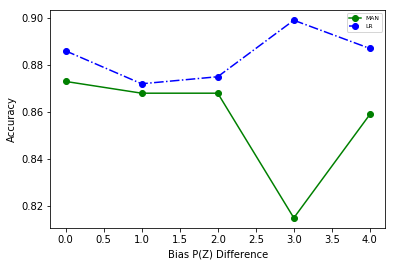

In [46]:
fig, ax = plt.subplots()
ax.plot(accuracy_man,'go-',label = 'MAN')
ax.plot(accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias P(Z) Difference')
plt.ylabel('Accuracy')

In [18]:
from sklearn import metrics
def accuracy(prediction,test):
    return len(test[np.where(prediction == test)])/len(test)

# model = MultinomialAdversarialNetwork(k=d.X.shape[1],m=num)
# lr = LogisticRegression()
bias_diff = []
accuracy_lr = defaultdict(list)
accuracy_man = defaultdict(list)
for key, val in dict_data.items():
    for d_train,d_test in val:
        model = MultinomialAdversarialNetwork(k=d.X.shape[1],m=num)
        lr = LogisticRegression()
        d_dict = {}
        d_dict['train'] = d_train
        d_dict['test'] = d_test
        bias_diff.append(abs(d_train.get_pz()-d_test.get_pz()))
        model.fit(d_dict,display_step=200)
        lr.fit(d_train.X,d_train.y)
        #preds = model.transform(d_dict)
        #preds = np.array([_.tolist() for _ in preds])
        accuracy_man[key].append(model.transform(d_dict)[0])
        accuracy_lr[key].append(metrics.accuracy_score(d_test.y,lr.predict(d_test.X)))
# j = 1
# for d_train in d.iterate_biased_datasets(kind='train'):
#     for d_test in d.iterate_biased_datasets(kind='test'):
#         if abs(d_test.get_bias()-d_train.get_bias()) >= 0.3:
#             d_dict = {}
#             d_dict['train'] = d_train
#             d_dict['test'] = d_test
#             print()
#             print('Train set {}, test set {}:'.format(i,j))
#             print('Bias diff: {}'.format(abs(d_test.get_bias()-d_train.get_bias())))
#             model.fit(d_dict,display_step=30)
#             acc, correct = model.transform(d_dict)
#             print('Accuracy: {}'.format(acc))
#         j+=1
#     i+=1
#     j=1

Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done
Epoch: 0200, done


KeyboardInterrupt: 

In [19]:
%matplotlib inline

In [19]:
list(zip(accuracy_man,accuracy_lr))

[('bias=0.8', 'bias=0.8'), ('bias=0.7', 'bias=0.7'), ('bias=0.6', 'bias=0.6')]

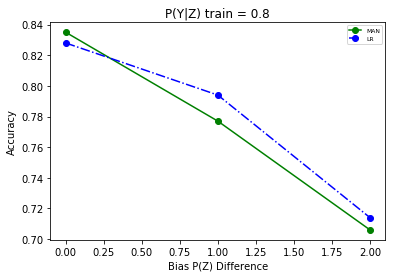

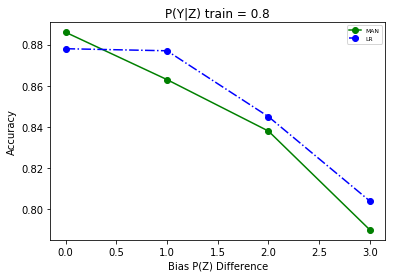

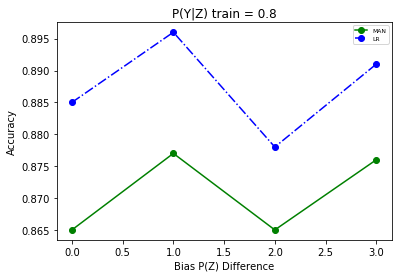

In [20]:
for key,_ in list(zip(accuracy_man,accuracy_lr)):
    fig, ax = plt.subplots()
    ax.plot(accuracy_man[key],'go-',label = 'MAN')
    ax.plot(accuracy_lr[key],'bo-.',label = 'LR')
    plt.legend(prop = {'size':6})
    plt.xlabel('Bias P(Z) Difference')
    plt.ylabel('Accuracy')
    plt.title('P(Y|Z) train = 0.8')

In [162]:
import itertools as itr


In [163]:
import pandas as pd
import itertools as itr

n_folds = 3
tr_bias = np.arange(.1,1,.1)
te_bias = np.arange(.1,1,.1)
expmt_results = []

for trb, teb, ifold in tqdm(list(itr.product(tr_bias, te_bias, range(n_folds)))):
    d_tr = d.make_zbiased_dataset(trb, 1000)
    d_te = d.make_zbiased_dataset(teb, 1000)
    lr.fit(d_tr.X, d_tr.y)
    y_pred = lr.predict(d_te.X)
    expmt_results.append(dict(
        tr_bias = d_tr.get_pz(),
        te_bias = d_te.get_pz(),
        y_true = d_te.y,
        y_pred = y_pred,
        fold = ifold
    ))
expmt_results = pd.DataFrame(expmt_results)

100%|██████████| 243/243 [03:55<00:00,  1.03it/s]


Text(0,0.5,'F1-score')

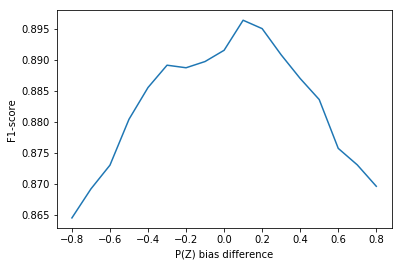

In [165]:
expmt_results['f1'] = expmt_results.apply(lambda row: metrics.f1_score(row.y_true, row.y_pred), axis=1)
expmt_results['bias_diff'] = expmt_results.apply(lambda row: np.round(row.tr_bias - row.te_bias, 1), axis=1)
plt.plot(expmt_results.groupby("bias_diff").f1.mean())
plt.xlabel("P(Z) bias difference")
plt.ylabel("F1-score")

### Zero out

In [81]:
import time
def make_predictions_per_topic(model, weights_idx, X_test):
    weights_og = model.get_weights(weights_idx)
    ntopics = weights_og.shape[0]
    preds = []
    
    for ti in list(range(ntopics)):
        weights = deepcopy(weights_og)
        weights[ti] = 0
        #t0 = time.time()
        model.set_weights(weights)
        #print(model.get_weights(weights_idx).flatten())
        preds.append(model.predict(X_test))
    
    model.set_weights(weights_og)
    
    preds = np.hstack(preds)
    mode_per_instance = mode(preds,axis=1)[0]
    changes_per_topic = (preds!=mode_per_instance).sum(axis=0)
    return preds,mode_per_instance, changes_per_topic


In [174]:
result = pd.DataFrame([{
    '1. Topic': idx,
    '2. Weight': topic_weights[idx],
    '3. # Changes': changes_per_topic[idx],
    '4. Top Words': ", ".join(d.feature_names[weights[-6][idx,:].argsort()[::-1]][:100])
} for idx in topic_weights.argsort()])
result

1. Topic  2. Weight  3. # Changes  \
0          6  -4.913806          1128   
1         20  -4.435238          1035   
2         25  -4.377637          1012   
3         36  -3.099593           920   
4         24  -2.579110           995   
5         30  -2.484333           951   
6          5  -2.391021           960   
7         22  -2.105890           949   
8         46  -1.968953           962   
9          2  -1.860211           978   
10        49  -1.832931           951   
11        13  -1.814121           933   
12         1  -1.780593           952   
13        21  -1.480631           983   
14        45  -1.470267           938   
15        26  -1.441867           950   
16        19  -1.332338           882   
17         4  -1.315625           953   
18        12  -1.239950           927   
19        47  -1.133898           916   
20        37  -0.674907           887   
21         3  -0.640134           930   
22        27  -0.636195           906   
23        31  -0.467806           901   
24        10  -0.240751           933   
25        32  -0.169023           898   
26        33  -0.167222           903   
27        38  -0.024151           923   
28        16   0.086336           929   
29        41   0.193225           928   
30        23   0.205027           892   
31        15   0.266306           903   
32         0   0.310933           892   
33        29   0.320162           924   
34        43   0.626435           912   
35        17   0.663424           925   
36        35   0.906529           925   
37        39   1.116528           923   
38        18   1.332186           927   
39        11   1.480682           947   
40        40   1.811783           901   
41        42   2.265670           928   
42         9   2.351568          1020   
43        28   2.582888           995   
44        34   2.665947           925   
45        44   3.226398          1029   
46        14   3.812486           974   
47         7   4.120861           986   
48         8   4.697791          1008   
49        48   5.683377          1200   

                                         4. Top Words  
0   newhart, kline, felix's, pegg, najimy, shue, a...  
1   posey, funny, jokes, handwriting, malcom, mcke...  
2   bake, kermit, mcintyre, astaire, sitka, abc, p...  
3   comedic, modine, goldie, morgan, dyan, nikki, ...  
4   mencia, unfunny, uma, jokes, thurman, mencia's...  
5   kaye, je, nathan, havana, vivian, accuses, kay...  
6   jokes, cbc, funny, stupid, eddie, randy, jacka...  
7   funny, jokes, tenacious, laugh, bam, hilarious...  
8   jokes, parody, zeta, unfunny, comedy, gags, ov...  
9   dancing, gabor, broadway, o'malley, sinatra, c...  
10  aristocats, sinatra, musicals, gabor, garland,...  
11  kids, children, watched, cute, saw, abc, i'm, ...  
12  supporting, comedic, comedy, eva, dramatic, pl...  
13  vhs, frightful, sars, springing, cloyingly, re...  
14  unfunny, jokes, lackluster, mildly, snl, point...  
15  bam, jokes, funny, kids, jackass, laughed, goi...  
16  delightful, corral, simplest, baltimore, wonde...  
17  minnie, barfly, episodes, figuratively, ages, ...  
18  acquit, scintillating, campiness, carrot, engl...  
19  costas, delightful, songs, superb, fab, wonder...  
20  amuck, headlong, decade's, tombstones, hub, ja...  
21  dramas, romantic, chemistry, touching, amelie,...  
22  stupid, dumb, _NUMBER_mins, garbage, anyways, ...  
23  cowgirls, lion's, waterworld, pungent, schrieb...  
24  propaganda, documentary, war, imitator, social...  
25  cliffhangers, ricky's, d's, funny, joker, favo...  
26  loins, bluth's, plotless, _NUMBER_mins, howler...  
27  cop, divorced, decides, town, asks, married, e...  
28  blooper, hotmail, ramone, chianese, deflect, k...  
29  divorced, married, emraan, diwani, celina, mee...  
30  development, problem, flowed, impressed, drama...  
31  provo, heathens, nd, askey, apparitions, snatc...  
32  brazil, complications, widower, meets, jewish,...  
33  vali

In [89]:
def find_most_correlated(model,test_d):
    topic_assignment = model.transform(test_d)
    #topic_assignment = []
    #for dist in topic_dist:
    #    tmp = [0]*num
        #ind = np.argsort(dist)[::-1][:3]
        #tmp[ind[0]] = 1
        #tmp[ind[1]] = 1
        #tmp[ind[2]] = 1
    #    tmp[np.argmax(dist)]=1
    #    topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    corr = []
    for topic in topic_assignment:
        corr.append(pearsonr(topic,test_d.z)[0])
    corr = np.nan_to_num(corr)
    most_corr = np.argsort(np.array(corr))[::-1][:5]
    return most_corr, corr[most_corr[0]], topic_assignment
def get_topic_dist(model,d):
    topic_dist = model.transform(d)
    topic_assignment = []
    for dist in topic_dist:
        tmp = [0]*num
        #ind = np.argsort(dist)[::-1][:3]
        #tmp[ind[0]] = 1
        #tmp[ind[1]] = 1
        #tmp[ind[2]] = 1
        tmp[np.argmax(dist)]=1
        topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    return topic_assignment

In [63]:
network_architecture = \
        dict(n_hidden_1=100, # 1st layer encoder neurons
#              n_hidden_2=200, # 2nd layer encoder neurons
#              n_hidden_3=200,
#              n_hidden_4=100,
             n_input=d.X.shape[1],
             n_output=1)
#imdb dataset: batch_size = 32
#twitter: b_s = 16
model_params = {
    'network_architecture':network_architecture,
    'batch_size':16,
    'learning_rate':0.001,
    'gpu_fraction':0.15,
    'loss': 'cross_entropy'
}
model = MLP(k=d.X.shape[1],m=100,
                              model_params=model_params)

In [90]:
def tune_lambda_exp(model,lambda_list,d_train,d_test):
    results = {}
    #results = []
    #d_total = concat([d_train,d_test])
    top_words={}
    neg_words = {}
    weights = {}
    for ld in lambda_list:
        results['lambda = {}'.format(ld)] = []
        model.set_lambda(ld)
        model.fit(d_train,training_epochs=40,display_step=40)
        weights = model.get_session().run(tf.trainable_variables())
        most_corr, most_corr_val, topic_dist = find_most_correlated(model,d_train)
        print('Setting lambda = {}, topic {} has most correlated val of {}'.format(ld,most_corr[0],most_corr_val))
        top_words['lambda = {}'.format(ld)] = ", ".join(d.feature_names[weights[-6][most_corr[0],:].argsort()[::-1]][:100])
        neg_words['lambda = {}'.format(ld)] = ", ".join(d.feature_names[weights[-6][most_corr[0],:].argsort()][:100])
        #weights['lambda = {}'.format(ld)] = weights[-6][most_corr[0],:]
        #topic_dist = get_topic_dist(model,d_test)
        for topic in topic_dist:
            results['lambda = {}'.format(ld)].append(pearsonr(topic,
                                                              d_train.z)[0])
        #most_corr, val = find_most_correlated(model,d_test)
        #results.append(val)
    for k,v in results.items():
        results[k] = np.nan_to_num(v)
    return results, top_words, neg_words
def MLP_exp(model,d_train,d_test):
    model.fit(d_train,training_epochs=100,display_step=100)
    weights = model.get_session().run(tf.trainable_variables())
    most_corr, most_corr_val, topic_dist = find_most_correlated(model,d_train)
    #print('topic {} has most correlated val of {}'.format(most_corr[0],most_corr_val))
    top_words = ", ".join(d.feature_names[weights[0][:,most_corr[0]].argsort()[::-1]][:100])
    neg_words = ", ".join(d.feature_names[weights[0][:,most_corr[0]].argsort()][:100])
#     results=[]
#     for topic in topic_dist:
#         results.append(pearsonr(topic,d_train.z)[0])
    return top_words,neg_words,most_corr_val,most_corr
    #results = []
    #d_total = concat([d_train,d_test])
    
def run_correlation_exp(model):
    result = {}
    pxgz_res = {}
    i = 1
    j = 1
    for d_train in d.iterate_biased_datasets(kind='train'):
        model.fit(d_train,training_epochs=40,display_step=40)
        preds_train, _, changes_train = make_predictions_per_topic(model,-5,d_train)
        for d_test in d.iterate_biased_datasets(kind='test'):
            preds_test, _, changes_test = make_predictions_per_topic(model,-5,d_test)
            diff_change = abs(changes_test-changes_train)
            topic_weights = model.get_weights(-5).flatten()
            weights = model.get_session().run(tf.trainable_variables())
            most_corr = find_most_correlated(model,d_test)
            result["train {} test {}".format(i,j)] = {
                'train':d_train,
                'test':d_test,
                'prediction':preds_test,
                'diff_change':diff_change,
                'changes_per_topic': changes_test,
                'topic_weights':topic_weights,
                'model_weights':weights,
                'most_corr_topic':most_corr
            }
            pxgz_res["train {} test {}".format(i,j)] = pxgz_diff_jsd(d_train.X,d_train.y,d_train.z,
                                                                     d_test.X,d_test.y,d_test.z,model)
            j+=1
        i+=1
        j=1
    return result, pxgz_res

#result,pxgz_res = run_correlation_exp(models[1])
lambda_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1., 10, 100]
results,top_words, neg_words = tune_lambda_exp(models[1],lambda_list,train_d[0],test_d[-1])
#top_words,neg_words,most_corr_val,most_corr = MLP_exp(model,train_d[0],test_d[-1])

Learning Rate: 0.001
Epoch: 0040 cost= 645449.263000000
Setting lambda = 1e-05, topic 93 has most correlated val of 0.5477700731792651
Learning Rate: 0.001
Epoch: 0040 cost= 83676.926375000
Setting lambda = 0.0001, topic 30 has most correlated val of 0.5553075726510655
Learning Rate: 0.001
Epoch: 0040 cost= 27596.100187500
Setting lambda = 0.001, topic 40 has most correlated val of 0.4965264447683692
Learning Rate: 0.001
Epoch: 0040 cost= 21079.643937500
Setting lambda = 0.01, topic 25 has most correlated val of 0.08001794523906024
Learning Rate: 0.001
Epoch: 0040 cost= 20040.395078125
Setting lambda = 0.1, topic 54 has most correlated val of 0.11286448254156159
Learning Rate: 0.001
Epoch: 0040 cost= 19944.606468750
Setting lambda = 1.0, topic 0 has most correlated val of 0.07168260232234384
Learning Rate: 0.001
Epoch: 0040 cost= 19946.558546875
Setting lambda = 10, topic 25 has most correlated val of 0.0806595244204545
Learning Rate: 0.001
Epoch: 0040 cost= 19940.406468750
Setting lam

In [12]:
def plot_results(results, title, same_graph=False):
    %matplotlib inline
    plt.figure(figsize=(12,8))
    if same_graph:
        for k,v in results.items():
            plt.plot(v,label = k)
        plt.title(title)
        plt.xlabel('Topic')
        plt.ylabel('Correlation with Z')
        plt.legend(loc=3)
        plt.show()
    else:
        for k,v in results.items():
            fig, ax = plt.subplots()
            ax.plot(v)
            plt.title(title)
            plt.xlabel('Topic')
            plt.ylabel('Correlation with Z')
            plt.title(k)
            plt.legend(loc=3)

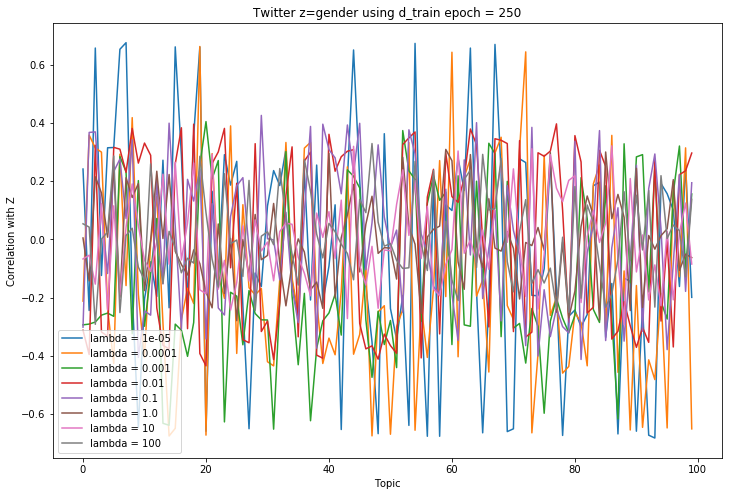


lambda = 0.01: la, los, hollywood, ca, sandiego, california, san, angeles, matrix, diego, weho, jedi, vegas, costa, implying, henson, lemon, heavier, speedway, gateway, reviews, coast, santa, vii, fairfax, steve, pch, lax, innout, jetlag, line, action, sixers, implement, sheriff, nico, universal, proclaimed, walken, verify, brigade, official, pronounced, francisco, armenian, shred, elonmusk, bay, epic, disneyland, gente, jeff, slime, receiver, bison, vhs, banger, master, dual, rests, offspring, motorcycle, las, mode, chrome, tales, admin, reals, decency, dennys, kung, 2002, retina, churro, limb, mp, heh, trading, prolific, del, gig, canyon, integrated, mc, release, blasphemy, e3, webb, wood, americana, produced, griffith, bloated, franchise, carlin, render, 30min, mexico, academics, hawaiian

lambda = 0.01: notreally, sneakers, aunt, york, marries, fairytale, ny, makeup, thebucktlist, recreate, disappointments, brunswick, wayyy, babysit, dicaprio, lips, achieved, notesforgirlz, relata

In [47]:
plot_results(results,'Twitter z={} using d_train epoch = 250'.format(zstr), True)
print()
print('lambda = {}: {}'.format(0.01,top_words['lambda = 1e-05']))
print()
print('lambda = {}: {}'.format(0.01,neg_words['lambda = 1e-05']))

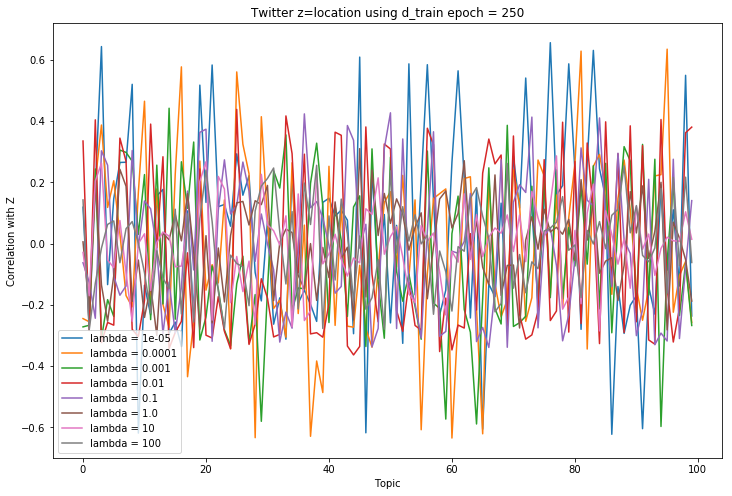


lambda = 0.01: brooklyn, nails, adorable, cutest, yay, obsessed, whyyy, girlposts, gossip, ughhh, earrings, lovely, nyc, boyfriend, snow, shades, anxiety, bug, bff, makeup, colorful, nbd, cuteness, oitnb, snowflake, autumn, decorating, sunburnt, soexcited, sincerelytumblr, sister, friendship, midterms, chocolate, snowing, lololol, dunkin, snuggled, barclays, hallelujah, ew, cake, cried, roomie, snacks, library, experienced, glitter, tan, lovewins, philanthropy, cutie, annoyed, aw, flower, sorrynotsorry, ny, purse, leggings, winter, tistheseason, muted, xoxox, raisins, sloth, shaming, tutorial, attached, stressful, charming, yayyy, harry, sorrynotsoorry, emily, sunshine, heels, husband, womenshumor, dresses, happyplace, withdrawal, ohhhh, insta, newyorkcity, brownie, kitten, tweetlikeagiri, pajama, yoga, ladies, dear, semester, misss, nerdalert, mozzarella, rlly, coliegestudent, hannah, fab, babies

lambda = 0.01: cp3, romo, la, usmnt, td, pg, muchos, phoenix, 215, messi, vegas, mls, n

In [38]:
plot_results(results,'Twitter z={} using d_train epoch = 250'.format(zstr), True)
print()
print('lambda = {}: {}'.format(0.01,top_words['lambda = 1e-05']))
print()
print('lambda = {}: {}'.format(0.01,neg_words['lambda = 1e-05']))

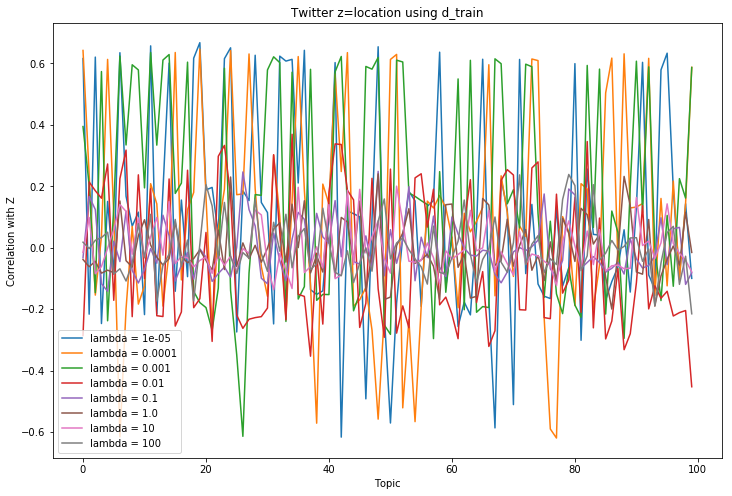


lambda = 0.01: ezra, ecstatic, conditioner, sleepover, mancanddypics, mademyday, oranges, nj, nail, tay, eyebrow, gladiators, disick, bradshaw, anastasia, tooo, themattespinosa, kendalljenner, greenwich, minding, regents, shopaholic, andrearussett, xfactor, hermes, nationaldogday, wishin, bundled, sextaik, heights, oth, nydailynews, firstworldpains, fairs, rosé, godmother, blakeshelton, deborah, salon, tweetlikeagiri, pll, deceiving, indecisive, weiss, cynthia, romper, famouswomen, pinned, nuteila, smell, cuomo, billdeblasio, strawberry, camerondallas, ddlovato, wahhh, fare, needsleep, skirt, sketching, vegetable, upstate, educating, sorrynotsoorry, youuuuu, omgrelatabie, pnc, bbanimals, iadybonerss, strangle, kyliejenner, cory, metgala, diner, safest, girlideas, phoebe, girlnotes, victimized, niallofficial, fuss, ducky, mermaids, poemporns, bedford, oscars2013, truffles, fiirtationship, cider, loveit, giriswant, countryside, karen, todayshow, prettylittleliars, granola, princess, tri

In [66]:
plot_results(results,'Twitter z={} using d_train'.format(zstr), True)
print()
print('lambda = {}: {}'.format(0.01,top_words['lambda = 1e-05']))
print()
print('lambda = {}: {}'.format(0.01,neg_words['lambda = 1e-05']))

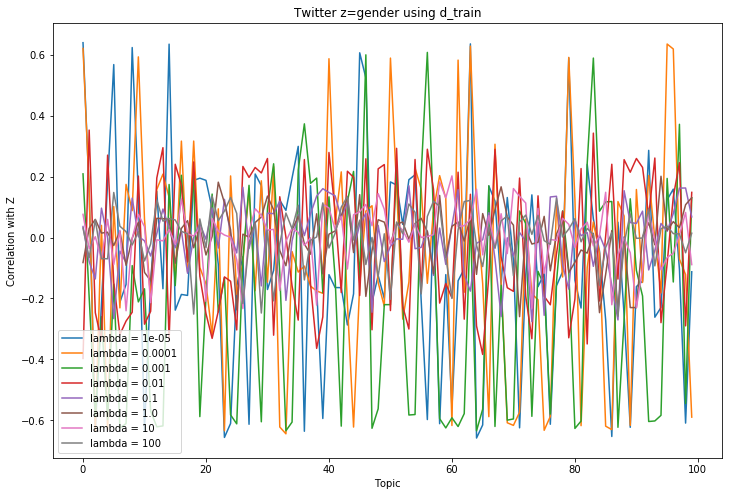


lambda = 0.01: fcbarcelona, inmates, csun, figueroa, jaime, jurassicworld, irritates, traction, jackassvine, ala, nuys, barca, plethora, comedyworidstar, blackpplvines, meanpiastic, arclight, redondo, legislature, mayweatherpacquiao, copa, mariota, carwash, 401, westlake, zendaya, championsleague, nighty, damnnn, sg, nats, hector, triggers, felipe, gohawks, asf, foxsports, northridge, prays, woridstarvidz, rsherman_25, averaged, rosebowl, gsw, apocalyptic, dubnation, f1, erinandrews, mckinney, e32015, grapevine, opponents, sportsviness, shat, dangerusswilson, 1944, valencia, wap, friedman, 200k, suarez, pinche, culver, sepulveda, capturing, tenure, realmadrid, pantages, interceptions, panoramic, umami, xgames, smacks, opposing, cig, camille, charliecharliechallenge, confrontation, amphitheatre, 159, kaepernick, evaluation, tanaka, financing, cuss, lmfaoooooo, chevrolet, minding, migration, centennial, bestscenees, bryce, blunts, bruhhhh, chime, repay, ports, lambo, hairstyles, rests



In [56]:
plot_results(results,'Twitter z={} using d_train'.format(zstr), True)
print()
print('lambda = {}: {}'.format(0.01,top_words['lambda = 1e-05']))
print()
print('lambda = {}: {}'.format(0.01,neg_words['lambda = 1e-05']))

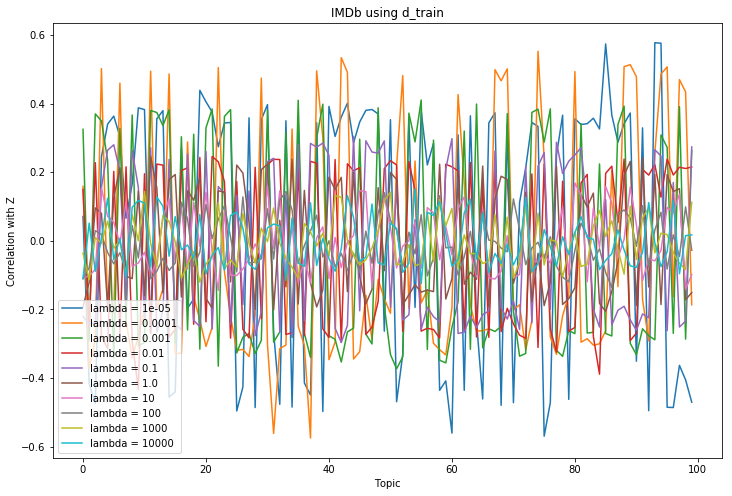


lambda = 0.1: comedy, lags, kidman's, tomboyish, hordes, incriminating, dispiriting, jokes, misogynist, sag, charlie, publicist, moment's, enjoyable, lyrical, forged, discomfort, chilly, disguising, partner's, candlelight, k_NUMBER_, violin, wonderful, pilgrim, knightley's, cheezy, sophomoric, sherry, funny, guinn, toyoda, acolyte, successes, appendage, cheyenne, universities, hearn, rolled, sandra's, family, mare, und, assembling, erkan, shout, gag, tenacious, alimony, rags, rankin, edgar, rigg, administrator, discard, fluttering, delays, ven, rehearsal, broke, adelaide's, katya, bernhard, joey's, breathed, reliving, peet, botch, elephants, laughed, ache, victimization, bling, blouses, rejection, fresh, rugby, choosing, interiors, scarlett's, womanizer, shoo, screenwriting, luminescence, bony, oregon, straights, funniest, delusion, squirting, superman's, cork, gasps, hank, consistently, kassovitz, balloons, pleasant, hitmen, ff

lambda = 0.1: decay, symptoms, uncover, genetically, th

In [116]:
plot_results(results,'IMDb using d_train', True)
print()
print('lambda = {}: {}'.format(0.1,top_words['lambda = 1e-05']))
print()
print('lambda = {}: {}'.format(0.1,neg_words['lambda = 1e-05']))

In [396]:
#Twitterv2
"""matching_corr_datasets1 = []
res = []
dataset={}
for key in result:
    dataset[key] = (result[key]['train'],result[key]['test'])
    if np.argmax(result[key]['changes_per_topic']) == result[key]['most_corr_topic'][0]:
        res.append(result[key])
        #matching_corr_datasets1.append((result[key]['train'],result[key]['test']))
        matching_corr_datasets1.append(key)
        print('{} has most changes topic: {} and most corr topic: {}'.format(key,np.argmax(result[key]['changes_per_topic']),
                                                                            result[key]['most_corr_topic'][0]))"""
matching_corr_datasets1 = []
res = []
dataset={}
for key in result:
    dataset[key] = (result[key]['train'],result[key]['test'])
    if np.argmax(result[key]['diff_change']) == result[key]['most_corr_topic'][0]:
        res.append(result[key])
        #matching_corr_datasets1.append((result[key]['train'],result[key]['test']))
        matching_corr_datasets1.append(key)
        print('{} has most changes topic: {} and most corr topic: {}'.format(key,np.argmax(result[key]['diff_change']),
                                                                            result[key]['most_corr_topic'][0]))

train 6 test 2 has most changes topic: 29 and most corr topic: 29
train 7 test 3 has most changes topic: 7 and most corr topic: 7


In [395]:
res = sorted(pxgz_res.items(),key=lambda x:-x[1])
for key,val in res[:5]:
    print("{}: ".format(key))
    print("Difference in P(X|Z): {}".format(val))
    print('First dataset bias: {}'.format(dataset[key][0].get_bias()))
    print('Second dataset bias: {}'.format(dataset[key][1].get_bias()))

train 9 test 1: 
Difference in P(X|Z): 0.01281987987253735
First dataset bias: 0.9
Second dataset bias: 0.09859154929577464
train 1 test 9: 
Difference in P(X|Z): 0.011389955584508414
First dataset bias: 0.1
Second dataset bias: 0.9014084507042254
train 8 test 1: 
Difference in P(X|Z): 0.010694905361496356
First dataset bias: 0.8
Second dataset bias: 0.09859154929577464
train 9 test 2: 
Difference in P(X|Z): 0.010312936108129833
First dataset bias: 0.9
Second dataset bias: 0.19919517102615694
train 2 test 9: 
Difference in P(X|Z): 0.009660378417428537
First dataset bias: 0.2
Second dataset bias: 0.9014084507042254


In [400]:
#Setup: l1 on first layer, no dropout
for i in range(len(res)):
    r = res[i]
    most_corr = r['most_corr_topic'][0]
    most_change = np.amax(r['diff_change'])
    most_change_topic = np.argmax(r['diff_change'])
    top_words = ", ".join(d.feature_names[r['model_weights'][-6][most_corr,:].argsort()[::-1]][:100])
    print('{}: '.format(matching_corr_datasets1[i]))
    print('Topic {} has number of disagreements: {}'.format(most_change_topic,most_change))
    print('Lowest weight among all topic weights: {}'.format(np.amin(r['topic_weights'])))
    print("Topic {}'s weight: {}".format(most_corr,r['topic_weights'][most_corr]))
    print("Top words: {}".format(top_words))
    print()

train 6 test 2: 
Topic 29 has number of disagreements: 30
Lowest weight among all topic weights: -1.0367509126663208
Topic 29's weight: -1.0159351825714111
Top words: expressing, motives, desires, pursuing, virgo, lif, motivates, tightly, tyga, joelosteen, accomplishment, obstacles, uplifting, maintaining, discouraged, uncertainty, thestruggle, chore, moods, hectic, determination, excel, challenging, disneywords, smoothly, socialize, prompts, zodiacfacts, rational, achieving, flowing, affectionate, persuade, settle, virtue, xstrology, aries, personalities, believing, girlproblems, thi, zodiac, unrealistic, disappointments, detached, selective, inspires, attracts, optimism, deflated, picky, visualize, accomplishing, affection, wishlist, bitterness, domestic, hottie, funnyortruth, possess, sensual, conflicting, finances, insecurities, chic, thelittlethings, sentimental, davidroads, imperfections, detox, glorified, olympian, proverbs, jasmine, females, unplanned, enthusiasm, byefelicia, d

In [26]:
#IMDb
"""matching_corr_datasets1 = []
res = []
dataset = {}
for key in result:
    dataset[key] = (result[key]['train'],result[key]['test'])
    if np.argmax(result[key]['changes_per_topic']) == result[key]['most_corr_topic'][0]:
        res.append(result[key])
        #matching_corr_datasets1.append((result[key]['train'],result[key]['test']))
        matching_corr_datasets1.append(key)
        print('{} has most changes topic: {} and most corr topic: {}'.format(key,np.argmax(result[key]['changes_per_topic']),
                                                                            result[key]['most_corr_topic'][0]))"""

matching_corr_datasets1 = []
res = []
dataset={}
for key in result:
    dataset[key] = (result[key]['train'],result[key]['test'])
    if np.argmax(result[key]['diff_change']) == result[key]['most_corr_topic'][0]:
        res.append(result[key])
        #matching_corr_datasets1.append((result[key]['train'],result[key]['test']))
        matching_corr_datasets1.append(key)
        print('{} has most changes topic: {} and most corr topic: {}'.format(key,np.argmax(result[key]['diff_change']),
                                                                            result[key]['most_corr_topic'][0]))

train 1 test 1 has most changes topic: 11 and most corr topic: 11
train 1 test 4 has most changes topic: 11 and most corr topic: 11
train 1 test 5 has most changes topic: 11 and most corr topic: 11
train 1 test 6 has most changes topic: 11 and most corr topic: 11
train 1 test 8 has most changes topic: 11 and most corr topic: 11
train 8 test 3 has most changes topic: 16 and most corr topic: 16
train 8 test 9 has most changes topic: 37 and most corr topic: 37
train 9 test 1 has most changes topic: 29 and most corr topic: 29
train 9 test 3 has most changes topic: 29 and most corr topic: 29


In [29]:
#Setup: l1 on first layer, no dropout
for i in range(len(res)):
    r = res[i]
    most_corr = r['most_corr_topic'][0]
    most_change = np.amax(r['diff_change'])
    most_change_topic = np.argmax(r['diff_change'])
    top_words = ", ".join(d.feature_names[r['model_weights'][-6][most_corr,:].argsort()[::-1]][:100])
    print('{}: '.format(matching_corr_datasets1[i]))
    print('Topic {} has number of disagreements: {}'.format(most_change_topic,most_change))
    print('Lowest weight among all topic weights: {}'.format(np.amin(r['topic_weights'])))
    print("Topic {}'s weight: {}".format(most_corr,r['topic_weights'][most_corr]))
    print("Top words: {}".format(top_words))
    print()

train 1 test 1: 
Topic 11 has number of disagreements: 402
Lowest weight among all topic weights: -2.978559732437134
Topic 11's weight: -2.978559732437134
Top words: broadway, harriet, hilliard, astaire, sings, numbers, ozzie, jaffe, mankiewicz, ginger, curly, sinatra, stooges, moe, randolph, silvers, mgm, rogers, gunga, lucille, stooge, din, kipling's, contract, milquetoast, catchy, sing, binnie, courtship, gene, garland, rin, rehab, durbin, ski, musical, stinging, spasm, kelly's, musicals, tap, relishing, sob, barnes, heckling, kelly, ameche, technicolor, millionaire, rockin, refine, unmistakable, peeves, dissimilar, eve, dances, sgt, hepburn, luftwaffe, nightclub, buckle, bing, laurel, underscore, beethoven's, raf, cactus, clark, columbia, loesser, newsreel, mclaglen, energetic, fried, deanna, witless, darwell, infuse, ballantine, sky, george's, wavers, protestations, rodgers, yawk, uniquely, kaye, abe, rollers, gielgud, jeanette, fontaine, charters, frank, vowel, lubitsch's, mistak

In [30]:
res = sorted(pxgz_res.items(),key=lambda x:-x[1])
for key,val in res[:5]:
    print("{}: ".format(key))
    print("Difference in P(X|Z): {}".format(val))
    print('First dataset bias: {}'.format(dataset[key][0].get_bias()))
    print('Second dataset bias: {}'.format(dataset[key][1].get_bias()))

train 3 test 9: 
Difference in P(X|Z): 0.017622304620969014
First dataset bias: 0.29987956643918107
Second dataset bias: 0.9002394253790902
train 5 test 9: 
Difference in P(X|Z): 0.017617522952473562
First dataset bias: 0.5
Second dataset bias: 0.9002394253790902
train 8 test 9: 
Difference in P(X|Z): 0.01760096120131823
First dataset bias: 0.800080289040546
Second dataset bias: 0.9002394253790902
train 4 test 8: 
Difference in P(X|Z): 0.017593020906931087
First dataset bias: 0.3998394219189081
Second dataset bias: 0.8000798084596967
train 4 test 4: 
Difference in P(X|Z): 0.017583631825245933
First dataset bias: 0.3998394219189081
Second dataset bias: 0.39984038308060654


In [322]:
models[1].end_session()

### P(X|Z) changes

In [16]:
def accuracy(prediction,test):
    return len(test[np.where(prediction == test)])/len(test)

def find_most_correlated(model,test_d):
    topic_dist = model.transform(test_d)
    topic_assignment = []
    for dist in topic_dist:
        tmp = [0]*num
        #ind = np.argsort(dist)[::-1][:3]
        #tmp[ind[0]] = 1
        #tmp[ind[1]] = 1
        #tmp[ind[2]] = 1
        tmp[np.argmax(dist)]=1
        topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    corr = []
    for topic in topic_assignment:
        corr.append(pearsonr(topic,test_d.z[:topic.shape[0]])[0])
    most_corr = np.argsort(np.array(corr))[::-1][:5]
    return most_corr, topic_assignment[most_corr[0]]

def predict_ba(X_train,X_test, y_train, y_test, Z_train):
    ba = BackdoorAdjustment()
    X_train, y_train, Z_train = shuffle(X_train,y_train,Z_train, random_state = 42)
    X_test, y_test = shuffle(X_test,y_test,random_state = 42)
    
    ba.fit(X_train,Z_train,y_train)
    return accuracy(ba.predict(X_test),y_test)

def predict_lr(X_train,X_test, y_train, y_test):
    lr = LogisticRegression(class_weight='balanced')
    X_train, y_train = shuffle(X_train,y_train, random_state = 42)
    X_test, y_test = shuffle(X_test,y_test,random_state = 42)
    lr.fit(X_train,y_train)
    return accuracy(lr.predict(X_test),y_test)

In [24]:
a = np.array([2,41,2,1,4])
print('here {}'.format(a))

here [ 2 41  2  1  4]


In [63]:
d_train = train_d[0]
d_test = test_d[-1]
d_total = concat([d_train,d_test])
models[1].set_lambda(1e-05)
models[1].fit(d_train,training_epochs=250,display_step=250)
topic_dist = models[1].transform(d_total)
topic_assignment = []
for dist in topic_dist:
    tmp = [0]*num
    ind = np.argsort(dist)[::-1][:3]
    tmp[ind[0]] = 1
    tmp[ind[1]] = 1
    tmp[ind[2]] = 1
    #tmp[np.argmax(dist)]=1
    topic_assignment.append(tmp)
topic_assignment = np.array(topic_assignment).T
topic_assignment

Learning Rate: 0.001
Epoch: 0250 cost= 99880.367687500


array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [64]:
a = [pxgz_diff_hd(d_train.X,d_train.y,topic[:d_train.X.shape[0]],
                d_test.X,d_test.y,topic[d_train.X.shape[0]:],2) for topic in topic_assignment]

In [66]:
np.array([pearsonr(z_hat,d_total.z)[0] for z_hat in topic_assignment]).max()

0.13207557952546473

In [51]:
from sklearn.linear_model import LogisticRegression
def get_topic_dist(model,d):
    topic_assignment = model.transform(d)
#     topic_assignment = []
#     for dist in topic_dist:
#         tmp = [0]*num
#         #ind = np.argsort(dist)[::-1][:3]
#         #tmp[ind[0]] = 1
#         #tmp[ind[1]] = 1
#         #tmp[ind[2]] = 1
#         tmp[np.argmax(dist)]=1
#         topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    return topic_assignment
def find_largest_pxgz_diff(model,train_d,test_d):
    d_total = concat([d_train,d_test])
    pxgz_diff = []
    topic_dist = get_topic_dist(model,d_total)
    #topic_dist = np.hstack((topic_train,topic_test))
    #print(topic_dist.shape)
    for topic in topic_dist:
        pxgz_diff.append(pxgz_diff_jsd(train_d.X,train_d.y,topic[:train_d.X.shape[0]],
                                      test_d.X,test_d.y,topic[train_d.X.shape[0]:],model))
    #return topic_train[np.argmax(pxgz_diff)],topic_test[np.argmax(pxgz_diff)]
    return topic_dist[np.argmax(pxgz_diff)]
    
def compare_exp(model):
    result = {}
    dataset = {}
    i = 1
    j = 1
    accuracy_ba = []
    accuracy_lr = []
    for d_train in d.iterate_biased_datasets(kind='train'):
        model.fit(d_train,training_epochs=40,display_step=40)
        #topic_train = get_topic_dist(model,d_train)
        for d_test in d.iterate_biased_datasets(kind='test'):
            #topic_test = get_topic_dist(model,d_test)
            if abs(d_train.get_bias()-d_test.get_bias()) >= 0.45:
                zhat = find_largest_pxgz_diff(model,d_train,d_test)
                zhat_train, zhat_test = zhat[:d_train.X.shape[0]].reshape((-1,1)), zhat[d_train.X.shape[0]:].reshape((-1,1)) 
                #result["train {} test {}".format(i,j)] = np.hstack((zhat_train,zhat_test))
                #dataset["train {} test {}".format(i,j)] = (d_train,d_test)
                accuracy_ba.append(predict_ba(d_train.X,d_test.X,d_train.y,d_test.y,zhat_train))
                accuracy_lr.append(predict_lr(d_train.X,d_test.X,d_train.y,d_test.y))
            j+=1
        i+=1
        j=1
    return accuracy_ba,accuracy_lr

def plot_result(accuracy_ba,accuracy_lr):
    ind = list(range(len(accuracy_ba)))
    fig, ax = plt.subplots()
    ax.plot(ind, accuracy_ba,'go-',label = 'BA')
    ax.plot(ind,accuracy_lr,'bo-.',label = 'LR')
    plt.legend(prop = {'size':6})
    plt.xlabel('Training steps')
    plt.ylabel('Accuracy')
    
def run_pxgzvsy_exp(model):
    result = {}
    dataset = {}
    #z_hats_dict = {}
    i = 1
    j = 1
    for d_train in d.iterate_biased_datasets(kind='train'):
        model.fit(d_train,training_epochs=200,display_step=200)
        for d_test in d.iterate_biased_datasets(kind='test'):
            d_total = concat([d_train,d_test])
            #most_corr,z_hat = find_most_correlated(model,d_total)
            z_hats = get_topic_dist(model,d_total)
            #result["train {} test {}".format(i,j)] = pxgz_diff_jsd(d_train.X,d_train.y,d_train.z,
            #                                                        d_test.X,d_test.y,d_test.z,model)
            pxgz_res = np.array([pxgz_diff_jsd(d_train.X,d_train.y,z_hat[:d_train.X.shape[0]],
                                        d_test.X,d_test.y,z_hat[d_train.X.shape[0]:],d_train.X.shape[0]) for z_hat in z_hats])
            result["train {} test {}".format(i,j)] = pxgz_res.max()
            #z_hats_dict["train {} test {}".format(i,j)] = 
            dataset["train {} test {}".format(i,j)] = (d_train,d_test)
            j+=1
        i+=1
        j=1
    return result,dataset

def run_pxgzvszcorr_exp(model):
    result = {}
    dataset = {}
    #z_hats_dict = {}
    i = 1
    j = 1
    model.set_lambda(1e-5)
    for d_train in d.iterate_biased_datasets(kind='train'):
        model.fit(d_train,training_epochs=200,display_step=200)
        for d_test in d.iterate_biased_datasets(kind='test'):
            d_total = concat([d_train,d_test])
            #most_corr,z_hat = find_most_correlated(model,d_total)
            topic_assignment = model.transform(d_total)
            topic_assignment = np.array(topic_assignment).T
            pxgz_val = np.array([pxgz_diff_jsd(d_train.X,d_train.y,z_hat[:d_train.X.shape[0]],
                                    d_test.X,d_test.y,z_hat[d_train.X.shape[0]:],2) for z_hat in topic_assignment])
            zcorr_val = np.array([pearsonr(z_hat,d_total.z)[0] for z_hat in topic_assignment])
            top_pxgz = np.argsort(pxgz_val)[::-1][:5]
            top_zcorr = np.argsort(zcorr_val)[::-1][:5]
            
            print('Train {} test {} with bias diff {}'.format(i,j,abs(d_train.get_bias()-d_test.get_bias())))
            print('Top topic with largest pxgz: {} with val {}'.format(top_pxgz,pxgz_val[top_pxgz]))
            print('Top topic with largest zcorr: {} with val {}'.format(top_zcorr,zcorr_val[top_zcorr]))
            j+=1
        i+=1
        j=1
    #eturn result,dataset
#accuracy_ba, accuracy_lr = compare_exp(models[1])
#plot_result(accuracy_ba,accuracy_lr)
#esults, dataset = run_pxgzvsy_exp(models[1])
run_pxgzvszcorr_exp(models[1])

Learning Rate: 0.001
Epoch: 0200 cost= 20556.632531250
Train 1 test 1 with bias diff 0.0016393442622950893
Top topic with largest pxgz: [99 36 26 27 28] with val [ 0.  0.  0.  0.  0.]
Top topic with largest zcorr: [71 74 94 40 88] with val [ 0.28942649  0.27545458  0.27008697  0.26100786  0.25687382]
Train 1 test 2 with bias diff 0.1016393442622951
Top topic with largest pxgz: [99 36 26 27 28] with val [ 0.  0.  0.  0.  0.]
Top topic with largest zcorr: [71 84 74 40 94] with val [ 0.28823251  0.27551608  0.2754621   0.26270579  0.25648605]
Train 1 test 3 with bias diff 0.20163934426229507
Top topic with largest pxgz: [99 36 26 27 28] with val [ 0.  0.  0.  0.  0.]
Top topic with largest zcorr: [71 94 74 88 84] with val [ 0.2963281   0.26904845  0.2634729   0.25405996  0.25262166]
Train 1 test 4 with bias diff 0.3016393442622951
Top topic with largest pxgz: [99 36 26 27 28] with val [ 0.  0.  0.  0.  0.]
Top topic with largest zcorr: [71 74 40 84 94] with val [ 0.27884558  0.26699554  0

KeyboardInterrupt: 

In [ ]:
%matplotlib inline

res = sorted(result.items(),key=lambda x:-x[1])

pxgz_diff = []
bias_diff = []
for key,val in res:
    pxgz_diff.append(val)
    bias_diff.append(abs(dataset[key][0].get_bias() - dataset[key][1].get_bias()))
plt.plot(pxgz_diff,bias_diff,'go-')
plt.legend(prop = {'size':6})
plt.xlabel('pxgz_diff')
plt.ylabel('bias_diff')

In [119]:
res = sorted(result.items(),key=lambda x:-x[1])
for key,val in res[:5]:
    print("{}: ".format(key))
    print("Difference in P(X|Z): {}".format(val))
    print('First dataset bias: {}'.format(dataset[key][0].get_bias()))
    print('Second dataset bias: {}'.format(dataset[key][1].get_bias()))

train 1 test 9: 
Difference in P(X|Z): 0.011941013698696743
First dataset bias: 0.099601593625498
Second dataset bias: 0.9012096774193549
train 9 test 1: 
Difference in P(X|Z): 0.011331610052277558
First dataset bias: 0.900398406374502
Second dataset bias: 0.09879032258064516
train 2 test 9: 
Difference in P(X|Z): 0.010062087089700569
First dataset bias: 0.199203187250996
Second dataset bias: 0.9012096774193549
train 8 test 1: 
Difference in P(X|Z): 0.009626993073101438
First dataset bias: 0.8007968127490039
Second dataset bias: 0.09879032258064516
train 1 test 8: 
Difference in P(X|Z): 0.009593184791112024
First dataset bias: 0.099601593625498
Second dataset bias: 0.8004032258064516


In [356]:
models[1].end_session()

## Control

### Domain Adaptation ABOW with one additional loss

In [144]:
def find_most_correlated(model,test_d,n):
    #topic_assignment = model.transform(test_d)
    topic_dist = model.transform(test_d)
    topic_assignment = []
#     for dist in topic_dist:
#         tmp = [0]*100
#         ind = np.argsort(dist)[::-1][:3]
#         tmp[ind[0]] = 1
#         tmp[ind[1]] = 1
#         tmp[ind[2]] = 1
#         topic_assignment.append(tmp)
    for dist in topic_dist:
        tmp = np.array([0]*100)
        bins = np.argsort(dist)
        tmp[bins[:50]] = 0
        tmp[bins[50:]] = 1
        topic_assignment.append(list(tmp))
    topic_assignment = np.array(topic_assignment).T
    corr = []
    #corr_z = []
    for topic in topic_assignment:
        corr.append(pearsonr(topic,test_d.z)[0])
        #corr_z.append(pearsonr(topic,test_d.z)[0])
    corr = np.nan_to_num(corr)
    #corr_z = np.nan_to_num(corr_z)
    #corr = corr[corr >=0]
    most_corr = np.argsort(np.array(corr))[::-1][:n]
    #most_corr_z = np.argsort(corr_z)[::-1][:n]
    top_n = topic_assignment[most_corr]
#     for i in range(n):
#         top_n[i] = corr[most_corr[i]] * top_n[i]
    #Try combine using average
    z_hat = np.round(np.average(top_n,axis=0))
#     #z_hat = np.array(list(map(func,z_hat)))
#     #z_hat = top_n.sum(axis=0)
    print(pearsonr(z_hat,test_d.z)[0])
    return most_corr,corr[most_corr], z_hat#topic_assignment[most_corr[0]]#z_hat

func = lambda x: 1 if x>=0.5 else 0

result = {}
s_prodlda = models[1]
s_prodlda.set_lambda(1e-05)
#s_prodlda.set_lambda(1e-2)
#i=1
# #for d_train in d.iterate_biased_datasets(kind='train'):
# d_try = Dataset()
# d_try.X = train_d[0].X.copy()
# d_try.y = train_d[0].y.copy()
# d_try.z = train_d[0].z.copy()
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]
lr = models[3]
bias_tr = train_d[0].get_bias()
s_prodlda.fit(train_d[0],training_epochs=250,display_step=250)
#ALERT: this will change d.z => will have to pickle dataset again if want the true z
topics,vals,z = find_most_correlated(s_prodlda,train_d[0],7)
#topics,vals,z_hat = find_most_correlated(s_prodlda,train_d[0],5)
print(vals)
print(train_d[0].z.shape)


Learning Rate: 0.001
Epoch: 0250 cost= 121203.079750000
0.92210073008
[ 0.74583444  0.7253886   0.69419488  0.69419488  0.65528932  0.65343557
  0.64864484]
(1000,)


/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [170]:
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]

In [146]:
train_d[0].z = z
train_d[0].z

array([ 0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,
        1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1

In [184]:
# abow_adapt = A_BOW_ADAPT(d.X.shape[1],2,1,hx=500,ht=200,hc=200,
#                         use_last_epoch_model=False, use_ensemble_model=False,
#                         n=11,p=.2,yz_weight_ratio=1,inv_factor=1,
#                         z_loss="categorical_crossentropy",
#                         z_activation="sigmoid",z_hat_loss="binary_crossentropy",
#                         z_hat_activation="sigmoid",optimizer="sgd")
abow = models[-1]
abow.fit(train_d[0],epochs=250,batch_size=16)
lr.fit(train_d[0].X,train_d[0].y)

for d_test in d.iterate_biased_datasets(kind='test'):
    #if abs(bias_tr - d_test.get_bias()) > 0.38:
        #abow_adapt.fit_domain_adaptation(train_d[0],d_test,200)
    #preds = []
#     for path in tqdm(list(abow.model_paths)):
#         abow.model.load_weights(path)
#         pred = abow.predict(d_test).argmax(axis=1)
#         preds.append(metrics.accuracy_score(d_test.y,pred))
    #pred_abow = abow_adapt.predict(d_test)
    pred_abow = abow.predict(d_test).argmax(axis=1)
    pred_lr = lr.predict(d_test.X)
    accuracy_abow.append(metrics.accuracy_score(d_test.y,pred_abow))
    #accuracy_abow.append(np.array(preds).max())
    accuracy_lr.append(metrics.accuracy_score(d_test.y,pred_lr))
#     f1_abow.append(metrics.f1_score(d_test.y,pred_abow))
#     f1_lr.append(metrics.f1_score(d_test.y,pred_lr))
    bias_diff.append(d_test.get_bias()-train_d[0].get_bias())

GradientReversal14
Epoch 1/250
1000/1000 [==============================] - 2s 2ms/step - loss: 4.4949 - y_loss: 0.8885 - z_loss: 3.6065
Epoch 2/250
1000/1000 [==============================] - 1s 759us/step - loss: 2.3996 - y_loss: 0.6568 - z_loss: 1.7428
Epoch 3/250
1000/1000 [==============================] - 1s 783us/step - loss: 3.1103 - y_loss: 0.8389 - z_loss: 2.2714
Epoch 4/250
1000/1000 [==============================] - 1s 798us/step - loss: 2.8073 - y_loss: 0.8020 - z_loss: 2.0053
Epoch 5/250
1000/1000 [==============================] - 1s 802us/step - loss: 3.5704 - y_loss: 0.7009 - z_loss: 2.8695
Epoch 6/250
1000/1000 [==============================] - 1s 664us/step - loss: 2.9210 - y_loss: 0.7649 - z_loss: 2.1562
Epoch 7/250
1000/1000 [==============================] - 1s 719us/step - loss: 3.6031 - y_loss: 1.5950 - z_loss: 2.0081
Epoch 8/250
1000/1000 [==============================] - 1s 784us/step - loss: 3.7501 - y_loss: 1.4090 - z_loss: 2.3411
Epoch 9/250
1000/1000 [

1000/1000 [==============================] - 1s 853us/step - loss: 0.6581 - y_loss: 0.0851 - z_loss: 0.5730
Epoch 136/250
1000/1000 [==============================] - 1s 850us/step - loss: 0.6529 - y_loss: 0.0847 - z_loss: 0.5682
Epoch 137/250
1000/1000 [==============================] - 1s 770us/step - loss: 0.6711 - y_loss: 0.1052 - z_loss: 0.5659
Epoch 138/250
1000/1000 [==============================] - 1s 834us/step - loss: 0.6173 - y_loss: 0.0668 - z_loss: 0.5506
Epoch 139/250
1000/1000 [==============================] - 1s 819us/step - loss: 0.5964 - y_loss: 0.0384 - z_loss: 0.5580
Epoch 140/250
1000/1000 [==============================] - 1s 734us/step - loss: 0.6050 - y_loss: 0.0472 - z_loss: 0.5578
Epoch 141/250
1000/1000 [==============================] - 1s 789us/step - loss: 0.6187 - y_loss: 0.0294 - z_loss: 0.5893
Epoch 142/250
1000/1000 [==============================] - 1s 837us/step - loss: 0.6717 - y_loss: 0.0979 - z_loss: 0.5738
Epoch 143/250
1000/1000 [=============

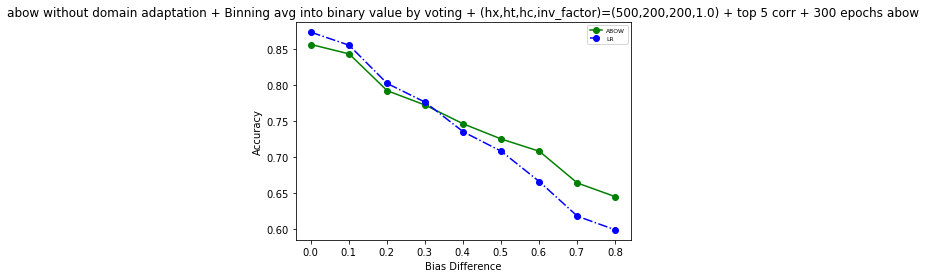

In [99]:
plt.cla()
plt.clf()
plt.close()
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.title("abow without domain adaptation + Binning avg into binary value by voting + (hx,ht,hc,inv_factor)=(500,200,200,1.0) + top 5 corr + 300 epochs abow")

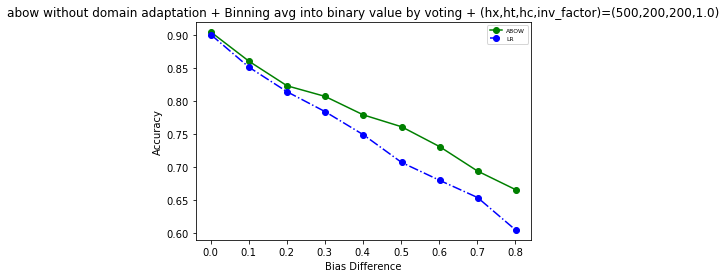

In [36]:
plt.cla()
plt.clf()
plt.close()
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.title("abow without domain adaptation + Binning avg into binary value by voting + (hx,ht,hc,inv_factor)=(500,200,200,1.0)")

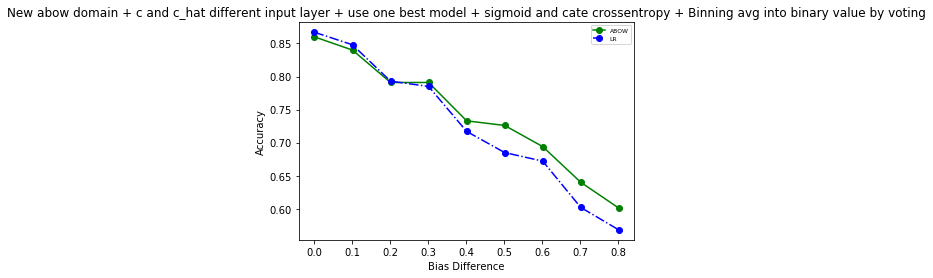

In [211]:
plt.cla()
plt.clf()
plt.close()
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.title("New abow domain + c and c_hat different input layer + use one best model + sigmoid and cate crossentropy + Binning avg into binary value by voting")

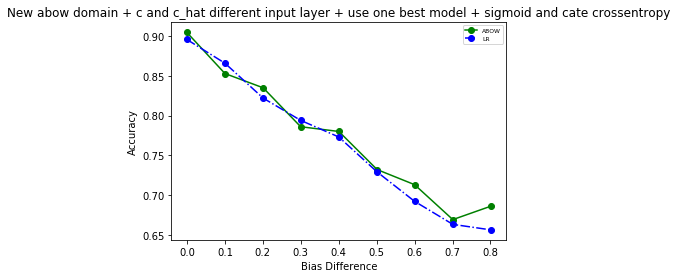

In [43]:
plt.cla()
plt.clf()
plt.close()
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.title("New abow domain + c and c_hat different input layer + use one best model + sigmoid and cate crossentropy")

In [83]:
# abow_adapt = A_BOW_ADAPT(d.X.shape[1],2,1,hx=500,ht=200,hc=200,
#                         use_last_epoch_model=False, use_ensemble_model=False,
#                         n=11,p=.2,yz_weight_ratio=1,inv_factor=1,
#                         z_loss="categorical_crossentropy",
#                         z_activation="sigmoid",optimizer="sgd")
# ystr = 'location'
# zstr = 'gender'
# d = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y={}_z={}.pkl".format(ystr, zstr))
# d.create_biased_datasets(1000, [.1,.5,.9], k=1)
# corr_diff = []
# accuracy_abow = []
# accuracy_lr = []
# for d_tr, d_te in tqdm(list(it.product(d.iterate_biased_datasets("train"), d.iterate_biased_datasets("test")))):
#     corr_diff.append(round(d_tr.pearsonr[0]-d_te.pearsonr[0],1))
#     abow_adapt.fit_domain_adaptation(d_tr,d_te,200)
    

### Train DNN to predict train vs test

In [136]:
network_architecture = \
        dict(n_hidden_1=100, # 1st layer encoder neurons
#              n_hidden_2=200, # 2nd layer encoder neurons
#              n_hidden_3=200,
#              n_hidden_4=100,
             n_input=d.X.shape[1],
             #n_input=2,
             n_output=1)
#imdb dataset: batch_size = 32
#twitter: b_s = 16
model_params = {
    'network_architecture':network_architecture,
    'batch_size':16,
    'learning_rate':0.001,
    'gpu_fraction':0.25,
    'loss': 'cross_entropy'
}
model = MLP(k=d.X.shape[1],m=100,
                              model_params=model_params)

In [137]:
def copy_dataset(d):
    d1 = Dataset()
    d1.X = d.X.copy()
    d1.z = d.z.copy()
    d1.y_label = d.y.copy()
    return d1
def make_dataset(d,kind='train'):
    d1 = copy_dataset(d)
    if kind =='train':
        d1.y = np.ones(d.get_size(),dtype='int64')
    else:
        d1.y = np.zeros(d.get_size(),dtype='int64')
    return d1
def make_shuffle_dataset(mode='all',random_state=0):
    train = make_dataset(train_d[0])
    test = make_dataset(test_d[-1],kind='test')
    d_total = concat([train,test])
    d_total.y_label = np.concatenate([train.y_label,test.y_label])
    d_total.X, d_total.z, d_total.y, d_total.y_label = shuffle(d_total.X, d_total.z,d_total.y,d_total.y_label,random_state=random_state)
    #d_total.X, d_total.z, d_total.y = shuffle(d_total.X, d_total.z,d_total.y,random_state=random_state)
    if mode == 'all':
        return d_total
    return Dataset(X=d_total.X[:1400],y=d_total.y[:1400],z=d_total.z[:1400],y_label=d_total.y_label[:1400]),Dataset(X=d_total.X[1400:],y=d_total.y[1400:],z=d_total.z[1400:],y_label=d_total.y_label[1400:])

#train, test= make_shuffle_dataset(mode='individual')
data = make_shuffle_dataset()

#### DNN one word/pair on whole dataset

##### One-word

In [138]:
model.fit(data,training_epochs=100,display_step=100)
test_data = np.eye(d.X.shape[1])

Epoch: 0100 cost= 0.577701993


In [139]:
test = Dataset(X=test_data)
res = model.predict(test)
res = res.flatten()

In [102]:
res.shape

(21981,)

In [140]:
top_neg = np.argsort(res)[:500]
top_pos = np.argsort(res)[::-1][:500]
print("Single words most predictive of test set:")
#print(d.features[top_neg])
print(res[top_neg])
print()
print("Single words most predictive of train set:")
#print(d.features[top_pos])
print(res[top_pos])

Single words most predictive of test set:
[ 0.0017159   0.00453603  0.00468666  0.00469385  0.00485871  0.00487984
  0.00489791  0.0052174   0.00527526  0.00557062  0.00578473  0.00600543
  0.00608666  0.00650215  0.00694013  0.00697311  0.00699532  0.0079231
  0.00800427  0.00803618  0.00810374  0.00813122  0.00817853  0.00828248
  0.00829461  0.00832257  0.00843029  0.00843211  0.00845566  0.00867852
  0.00892194  0.00894642  0.00908862  0.00919211  0.00927631  0.00935929
  0.00948711  0.00955907  0.00991607  0.00992848  0.0099297   0.00999914
  0.01006513  0.01032473  0.01035203  0.01042332  0.01063436  0.01091253
  0.01105229  0.011125    0.0111541   0.0111685   0.01117775  0.01121828
  0.01131606  0.01140306  0.01143236  0.01158212  0.01163018  0.01171269
  0.01171802  0.01179043  0.01188175  0.01199505  0.01216537  0.01218351
  0.01226564  0.01232277  0.01242252  0.01251539  0.0125156   0.01255467
  0.01256637  0.01258193  0.01263414  0.01264953  0.01269787  0.01291324
  0.013056

In [117]:
np.round(np.average(train_d[0].X[:,[0,4,6,1]].toarray(),axis=1)).shape

(1000,)

In [141]:
a=train_d[0].X[:,top_pos].toarray()

In [146]:
b = a[0,:]
len(b[b==1])

102

In [157]:
#Take top terms extremely confident in their ability to distinguish train from test and 
#vice versa, take average of their vector => that will be z_hat
x_pos = train_d[0].X[:,top_pos].toarray()
z_hat = []
for i in range(train_d[0].X.shape[0]):
    tmp = x_pos[i,:]
    if len(tmp[tmp==1]) >= 80:
        z_hat.append(1)
    else:
        z_hat.append(0)
z_hat = np.array(z_hat)
#z_hat
#z_hat
print(pearsonr(z_hat,train_d[0].z)[0])
# x_neg = test_d[-1].X[:,top_neg].toarray()
# z_hat_test = np.average(x_neg,axis=1)
# print(pearsonr(np.round(z_hat_test),test_d[-1].z)[0])

-0.0266066519624


##### Word-pair

In [99]:
model.fit(data,training_epochs=100,display_step=100)

Epoch: 0100 cost= 0.449095205


In [100]:
res_z = [pearsonr(data.X[:,i].toarray().flatten(),data.z)[0] for i in tqdm(range(len(d.features)))]
res_y = [pearsonr(data.X[:,i].toarray().flatten(),data.y_label)[0] for i in tqdm(range(len(d.features)))]

In [101]:
z_noise = np.array([random.randint(0,d.X.shape[1]+1) for _ in range(75)])
y_noise = np.array([random.randint(0,d.X.shape[1]+1) for _ in range(75)])
z_words = np.concatenate([np.argsort(res_z)[::-1][:75],z_noise])
y_words = np.concatenate([np.argsort(res_y)[::-1][:75],y_noise])
# words = list(it.combinations(list(set(np.concatenate([z_words,y_words]))),2))
# x = np.zeros((len(words),d.X.shape[1]),dtype='int64')
# ind_to_word = {}
# for i in tqdm(range(len(words))):
#     ind_to_word[i]=[words[i][0],words[i][1]]
#     x[i,[words[i][0],words[i][1]]] = 1
comb = list(it.product(z_words,y_words))
x = []
for z_word,y_word in comb:
    if z_word != y_word:
        tmp = [0]*d.X.shape[1]
        tmp[z_word]=1
        tmp[y_word]=1
        x.append(tmp)
x=np.array(x)

In [105]:
x.shape

(22498, 21981)

In [20]:
train_d[0]

< Dataset: size=1000, p(y)=0.51, p(z)=0.49, bias=0.10, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=6000, p(y)=0.50, p(z)=0.50, bias=0.50, parent=None > > >

In [106]:
test = Dataset(X=x)
res = model.predict(test).flatten()
top_neg = np.argsort(res)[:100]
top_pos = np.argsort(res)[::-1][:100]
top_neg_res=[]
top_pos_res=[]
print("Single words most predictive of test set:")
for i in top_neg:
    top_neg_res.append('{}-{}'.format(d.features[ind_to_word[i][0]],d.features[ind_to_word[i][1]]))
print(top_neg_res)
print()
print("Single words most predictive of train set:")
for i in top_pos:
    top_pos_res.append('{}-{}'.format(d.features[ind_to_word[i][0]],d.features[ind_to_word[i][1]]))
print(top_pos_res)

Single words most predictive of test set:
['sandy-repeat', 'sandy-verge', 'qb-cavs', 'union-array', 'shaq-apr', 'ps4-4ever', 'hobbit-creep', 'hobbit-bk', 'pts-snowy', 'ricky-chemicals', 'droppin-rb', 'bobble-kart', 'muscular-gross', 'thats-qb', 'farewell-thegarden', 'metropolitan-qb', 'lib-creep', 'mta-lovelies', 'madison-royalty', 'madden-lib', 'snow-loews', 'thegarden-deadspin', 'centralpark-yankees', 'mta-scoring', 'shaq-40k', 'kindest-uglier', 'hoboken-player', 'lib-newark', 'penalty-djing', 'espn-wrestlemania', 'beast-1965', 'ps3-beast', 'pts-teammates', 'kingjames-newark', 'dunk-icons', 'hobbit-seahawks', 'dunk-uws', 'pts-playin', 'thegarden-jersey', 'ps4-bleu', 'beast-jfk', 'muscular-helmet', 'killings-andre', 'trade-loews', 'snapchats-bitterness', 'differently-nypd', 'astor-royalty', 'farewell-centralpark', 'colleagues-apr', 'pts-stardust', 'cab-drafted', 'refs-nbd', 'lib-brooklyn', 'hobbit-andre', 'bobble-verge', 'shaq-followed', 'abandon-centralpark', 'bobble-coney', 'thegard

### Hyperparam tuning

In [31]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from __future__ import print_function

In [54]:
# import logging
# logging.basicConfig(filename='example.log',
#                     filemode='w',
#                     level=logging.DEBUG)

# logging.debug("Running Urban Planning")

with open('example.txt','w') as f:
    f.write("hi")

In [9]:
def find_most_correlated(model,test_d,n):
    topic_assignment = model.transform(test_d)
#     topic_assignment = []
#     topic_dist = model.transform(test_d)
#     topic_assignment = []
#     for dist in topic_dist:
#         tmp = [0]*100
#         ind = np.argsort(dist)[::-1][:3]
#         tmp[ind[0]] = 1
#         tmp[ind[1]] = 1
#         tmp[ind[2]] = 1
#         topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    corr = []
    for topic in topic_assignment:
        corr.append(pearsonr(topic,test_d.z)[0])
    corr = np.nan_to_num(corr)
    most_corr = np.argsort(np.array(corr))[::-1][:n]
    top_n = topic_assignment[most_corr]
    for i in range(n):
        top_n[i] = corr[most_corr[i]] * top_n[i]
#     #Try combine using average
    z_hat = np.average(top_n,axis=0)
    #z_hat = np.array(list(map(func,z_hat)))
    #z_hat = top_n.sum(axis=0)
    print(pearsonr(z_hat,test_d.z)[0])
    return most_corr,corr[most_corr], z_hat#topic_assignment[most_corr[0]]#z_hat

result = {}
s_prodlda = models[1]
s_prodlda.set_lambda(1e-05)
s_prodlda.fit(train_d[0],training_epochs=250,display_step=250)
#ALERT: this will change d.z => will have to pickle dataset again if want the true z
topics,vals,train_d[0].z = find_most_correlated(s_prodlda,train_d[0],5)
print(vals)

Learning Rate: 0.001
Epoch: 0250 cost= 93763.065062500
0.642940436273
[ 0.61370956  0.6094931   0.60511454  0.60489544  0.60016877]


In [13]:
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.engine import Layer
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint,History
from glob import glob
import numpy as np
from keras.backend.tensorflow_backend import set_session
import os.path
# Reverse gradient layer from https://github.com/michetonu/gradient_reversal_keras_tf/blob/master/flipGradientTF.py
# Added compute_output_shape for Keras 2 compatibility
def reverse_gradient(X, hp_lambda):
    """Flips the sign of the incoming gradient during training."""
    try:
        reverse_gradient.num_calls += 1
    except AttributeError:
        reverse_gradient.num_calls = 1

    grad_name = "GradientReversal%d" % reverse_gradient.num_calls

    @tf.RegisterGradient(grad_name)
    def _flip_gradients(op, grad):
        return [tf.negative(grad) * hp_lambda]
    reverse_gradient.num_calls += 1
    g = K.get_session().graph
    with g.gradient_override_map({"Identity": grad_name}):
        y = tf.identity(X)
    print(grad_name)
    return y


class GradientReversal(Layer):
    """Flip the sign of gradient during training."""

    def __init__(self, hp_lambda, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.supports_masking = False
        self.hp_lambda = hp_lambda

    def build(self, input_shape):
        self.trainable_weights = []

    def call(self, x, mask=None):
        return reverse_gradient(x, self.hp_lambda)

    def get_output_shape_for(self, input_shape):
        return input_shape

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {"hp_lambda": self.hp_lambda}
        base_config = super(GradientReversal, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def build_model(x_train,y_train,x_test,y_test):
#     K.clear_session()
#     config = tf.ConfigProto()
#     config.gpu_options.per_process_gpu_memory_fraction = 0.125
#     sess = tf.Session(config=config)
#     set_session(sess)
    x_input = Input((d.X.shape[1],), name="x_input")
    e = Dense({{choice([5,10,25,50,100,150,200])}}, activation="relu", name="e")(x_input)
    
    l = Dense({{choice([5,10,25,50,100,150,200])}}, activation="relu")(e)
    t = Dense(2, activation="softmax", name="y")(l)

    l = GradientReversal({{choice(np.linspace(0,1,11))}})(e)
    l = Dense({{choice([5,10,25,50,100,150,200])}}, activation="relu")(l)
    c = Dense(1, name="z")(l)

    model = Model(x_input, [t, c])
    model.compile(optimizer={{choice(['sgd', 'adagrad', 'adam', 'adamax'])}}, loss=["categorical_crossentropy","mean_squared_error"],metrics=['accuracy'])
    model.fit(x_train,y_train,batch_size=16,epochs=300,validation_data=(x_test,y_test))
    score,acc = model.evaluate(x_test,y_test)
    print('Test Acc:',acc)
    return {'loss':-acc,'status':STATUS_OK,'model':model}

def data():
    tocat = lambda x: to_categorical(x, num_classes=2)
    x_train = train_d[0].X
    y_train = [tocat(train_d[0].y),train_d[0].z]
    x_test = test_d[-1].X
    y_test = test_d[-1].y
    return x_train,y_train,x_test,y_test


best_run, best_model = optim.minimize(model=build_model,
                                      data=data,
                                      algo=tpe.suggest,
                                      max_evals=5,
                                      trials=Trials(),
                                      notebook_name='Framework_TuanTran')
X_train, Y_train, X_test, Y_test = data()
print("Evalutation of best performing model:")
print(best_model.evaluate(X_test, Y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)
# model = KerasClassifier(build_fn = build_model,epochs=300,batch_size=16)
# hx = [5,10,25,50,100,150,200]
# ht = [5,10,25,50,100,150,200]
# hc = [5,10,25,50,100,150,200]
# inv_factor = np.linspace(0,1,11)
# optimizer = ['sgd', 'adagrad', 'adam', 'adamax']
# param_grid = dict(hx=hx,ht=ht,hc=hc,inv_factor=inv_factor,optimizer=optimizer)
# grid = GridSearchCV(estimator = model, param_grid = param_grid,n_jobs=-1)
# grid_result=grid.fit(train_d[0].X, [tocat(train_d[0].y),train_d[0].z])
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

SyntaxError: EOL while scanning string literal (<unknown>, line 1104)

In [ ]:
hx = [10,50,100,200]
ht = [10,50,100,200]
hc = [10,50,100,200]
inv_factor = np.linspace(0,1,11)
res={}
curr_max = -np.inf 
for i in hx:
    for j in ht:
        for k in hc:
            for inv in inv_factor:
                abow = A_BOW_TEST(d.X.shape[1],hx=i, ht=j, hc=k, inv_factor=inv)
                abow.fit(train_d[0],epochs=300,batch_size=16)
                pred_abow = abow.predict(test_d[-1]).argmax(axis=1)
                acc = metrics.accuracy_score(test_d[-1].y,pred_abow)
                print('acc: {}, curr_max: {}'.format(acc,curr_max))
                if acc > curr_max:
                    curr_max = acc
#                     res={
#                         'hx':i,
#                         'ht':j,
#                         'hc':k,
#                         'inv_factor':inv,
#                         'acc':acc
#                     }
                    with open('example.txt','w') as f:
                        f.write('hx: {}, ht: {}, hc: {}, inv_factor: {}, acc: {}'.format(i,j,k,inv,acc))

GradientReversal1
Reloading model /tmp/abow.00277.hdf5 with y loss 1.3089182891690143e-07 and z loss 3.636490587268781e-07
acc: 0.633, curr_max: -inf
GradientReversal3
Reloading model /tmp/abow.00283.hdf5 with y loss 0.00012997636558532123 and z loss 0.17575443642772734
acc: 0.646, curr_max: 0.633
GradientReversal5
Reloading model /tmp/abow.00293.hdf5 with y loss 0.00030060868465807286 and z loss 0.019200852880137974
acc: 0.654, curr_max: 0.646
GradientReversal7
Reloading model /tmp/abow.00299.hdf5 with y loss 0.0004478247832158786 and z loss 0.4248387601152062
acc: 0.634, curr_max: 0.654
GradientReversal9
Reloading model /tmp/abow.00295.hdf5 with y loss 9.898163808600202e-05 and z loss 0.3226290932325646
acc: 0.664, curr_max: 0.654
GradientReversal11
Reloading model /tmp/abow.00270.hdf5 with y loss 0.0005681186758172317 and z loss 0.021258696881996
acc: 0.637, curr_max: 0.664
GradientReversal13
Reloading model /tmp/abow.00268.hdf5 with y loss 0.00019924790240315814 and z loss 4.583051

acc: 0.658, curr_max: 0.683
GradientReversal113
Reloading model /tmp/abow.00289.hdf5 with y loss 8.918541016214475e-06 and z loss 0.08359571973606944
acc: 0.684, curr_max: 0.683
GradientReversal115
Reloading model /tmp/abow.00282.hdf5 with y loss 5.446098814559264e-06 and z loss 4.899272844076156
acc: 0.588, curr_max: 0.684
GradientReversal117
Reloading model /tmp/abow.00190.hdf5 with y loss 1.3599675503314756e-05 and z loss 8.274202464342117
acc: 0.626, curr_max: 0.684
GradientReversal119
Reloading model /tmp/abow.00269.hdf5 with y loss 6.262198456681745e-05 and z loss 2.8661623765230178
acc: 0.617, curr_max: 0.684
GradientReversal121
Reloading model /tmp/abow.00072.hdf5 with y loss 0.002197074200460975 and z loss 0.37874958430230615
acc: 0.625, curr_max: 0.684
GradientReversal123
Reloading model /tmp/abow.00112.hdf5 with y loss 0.00025237509677378966 and z loss 0.7806631517261267
acc: 0.609, curr_max: 0.684
GradientReversal125
Reloading model /tmp/abow.00280.hdf5 with y loss 6.495014

acc: 0.597, curr_max: 0.684
GradientReversal223
Reloading model /tmp/abow.00298.hdf5 with y loss 1.8945036327181696e-05 and z loss 1.7740949293971062
acc: 0.669, curr_max: 0.684
GradientReversal225
Reloading model /tmp/abow.00295.hdf5 with y loss 6.5558999946233595e-06 and z loss 1.1473968593478203
acc: 0.689, curr_max: 0.684
GradientReversal227
Reloading model /tmp/abow.00273.hdf5 with y loss 7.272550276070433e-06 and z loss 3.991922038644552
acc: 0.647, curr_max: 0.689
GradientReversal229
Reloading model /tmp/abow.00294.hdf5 with y loss 1.7038208740132178e-06 and z loss 15.411965760529041
acc: 0.628, curr_max: 0.689
GradientReversal231
Reloading model /tmp/abow.00268.hdf5 with y loss 6.033277794699643e-06 and z loss 1.4385958663318306
acc: 0.628, curr_max: 0.689
GradientReversal233
Reloading model /tmp/abow.00075.hdf5 with y loss 0.0011520402744546346 and z loss 9.192741235792637
acc: 0.625, curr_max: 0.689
GradientReversal235
Reloading model /tmp/abow.00112.hdf5 with y loss 2.071394

### Combine top Z exp

In [12]:
def find_most_correlated(model,test_d,n):
    topic_assignment = model.transform(test_d)
#     topic_dist = model.transform(test_d)
#     topic_assignment = []
#     for dist in topic_dist:
#         tmp = [0]*100
#         ind = np.argsort(dist)[::-1][:3]
#         tmp[ind[0]] = 1
#         tmp[ind[1]] = 1
#         tmp[ind[2]] = 1
#         topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    corr = []
    for topic in topic_assignment:
        corr.append(pearsonr(topic,test_d.z)[0])
    corr = np.nan_to_num(corr)
    #corr = corr[corr >=0]
    most_corr = np.argsort(np.array(corr))[::-1][:n]
    top_n = topic_assignment[most_corr]
#     for i in range(n):
#         top_n[i] = corr[most_corr[i]] * top_n[i]
#     #Try combine using average
#     z_hat = np.average(top_n,axis=0)
#     #z_hat = np.array(list(map(func,z_hat)))
#     #z_hat = top_n.sum(axis=0)
#     print(pearsonr(z_hat,test_d.z)[0])
    return most_corr,corr[most_corr], top_n.T#topic_assignment[most_corr[0]]#z_hat

#### Using real Z

In [27]:

abow = models[6]

In [28]:
func = lambda x: 1 if x>=0.5 else 0

result = {}
s_prodlda = models[1]
s_prodlda.set_lambda(1e-05)
#i=1
# #for d_train in d.iterate_biased_datasets(kind='train'):
# d_try = Dataset()
# d_try.X = train_d[0].X.copy()
# d_try.y = train_d[0].y.copy()
# d_try.z = train_d[0].z.copy()
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]
lr = models[3]
bias_tr = train_d[0].get_bias()
s_prodlda.fit(train_d[0],training_epochs=250,display_step=250)
#ALERT: this will change d.z => will have to pickle dataset again if want the true z
topics,vals,train_d[0].z = find_most_correlated(s_prodlda,train_d[0],5)
#topics,vals,z_hat = find_most_correlated(s_prodlda,train_d[0],5)
print(vals)
print(train_d[0].z)
print(train_d[0].z.shape)

Learning Rate: 0.001
Epoch: 0250 cost= 95652.345437500
[ 0.2228669   0.21636241  0.21555804  0.21133093  0.20890215]
[[0 0 0 0 1]
 [0 0 1 0 0]
 [0 0 0 0 0]
 ..., 
 [1 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
(1000, 5)


/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


#### Using Z_hats retrieved using P(X|Z)

In [13]:
def copy_dataset(d):
    d1 = Dataset()
    d1.X = d.X.copy()
    d1.z = d.z.copy()
    d1.y = d.y.copy()
    return d1

def get_topic_dist(model,d):
    #topic_assignment = model.transform(d)
    topic_dist = model.transform(d)
    topic_assignment = []
    for dist in topic_dist:
        tmp = [0]*num
        ind = np.argsort(dist)[::-1][:3]
        tmp[ind[0]] = 1
        tmp[ind[1]] = 1
        tmp[ind[2]] = 1
        #tmp[np.argmax(dist)]=1
        topic_assignment.append(tmp)
    topic_assignment = np.array(topic_assignment).T
    return topic_assignment
def find_largest_pxgz_diff(model,train_d,test_d):
    d_total = concat([train_d,test_d])
    pxgz_diff = []
    topic_dist = get_topic_dist(model,d_total)
    #topic_dist = np.hstack((topic_train,topic_test))
    #print(topic_dist.shape)
    for topic in topic_dist:
        pxgz_diff.append(pxgz_diff_jsd(train_d.X,train_d.y,topic[:train_d.X.shape[0]],
                                      test_d.X,test_d.y,topic[train_d.X.shape[0]:],2))
    #return topic_train[np.argmax(pxgz_diff)],topic_test[np.argmax(pxgz_diff)]
    return topic_dist[np.argmax(pxgz_diff),:train_d.X.shape[0]]

s_prodlda = models[1]
s_prodlda.set_lambda(1e-05)
train = copy_dataset(train_d[0])
s_prodlda.fit(train,training_epochs=250,display_step=250)

Learning Rate: 0.001
Epoch: 0250 cost= 88684.355687500


In [14]:
#abow = models[2]
#abow = models[4]
# abow.fit(d_try,epochs=300,batch_size=16)
# lr.fit(d_try.X, d_try.y)
#ALERT: this will change d.z => will have to pickle dataset again if want the true z
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]
lr = models[3]
abow = models[-1]
for d_test in d.iterate_biased_datasets(kind='test'):
    train.z = find_largest_pxgz_diff(s_prodlda,train_d[0],d_test)
    abow.fit(train,epochs=300,batch_size=16)
    lr.fit(train.X, train.y)
    pred_abow = abow.predict(d_test).argmax(axis=1)
    pred_lr = lr.predict(d_test.X)
    accuracy_abow.append(metrics.accuracy_score(d_test.y,pred_abow))
    accuracy_lr.append(metrics.accuracy_score(d_test.y,pred_lr))
    f1_abow.append(metrics.f1_score(d_test.y,pred_abow))
    f1_lr.append(metrics.f1_score(d_test.y,pred_lr))
    bias_diff.append(d_test.get_bias()-train_d[0].get_bias())

GradientReversal1
Epoch 1/300
1000/1000 [==============================] - 1s 1ms/step - loss: 2.4691 - y_loss: 0.6729 - z_loss: 1.7962
Epoch 2/300
1000/1000 [==============================] - 1s 960us/step - loss: 0.5032 - y_loss: 0.1176 - z_loss: 0.3856
Epoch 3/300
1000/1000 [==============================] - 1s 855us/step - loss: 0.4708 - y_loss: 0.0825 - z_loss: 0.3883
Epoch 4/300
1000/1000 [==============================] - 1s 859us/step - loss: 0.4230 - y_loss: 0.0323 - z_loss: 0.3907
Epoch 5/300
1000/1000 [==============================] - 1s 895us/step - loss: 0.4021 - y_loss: 0.0102 - z_loss: 0.3919
Epoch 6/300
1000/1000 [==============================] - 1s 886us/step - loss: 0.3989 - y_loss: 0.0072 - z_loss: 0.3918
Epoch 7/300
1000/1000 [==============================] - 1s 842us/step - loss: 0.4012 - y_loss: 0.0095 - z_loss: 0.3917
Epoch 8/300
1000/1000 [==============================] - 1s 791us/step - loss: 0.6167 - y_loss: 0.2252 - z_loss: 0.3916
Epoch 9/300
1000/1000 [=

1000/1000 [==============================] - 1s 810us/step - loss: 0.3952 - y_loss: 0.0040 - z_loss: 0.3911
Epoch 136/300
1000/1000 [==============================] - 1s 744us/step - loss: 0.3952 - y_loss: 0.0041 - z_loss: 0.3911
Epoch 137/300
1000/1000 [==============================] - 1s 862us/step - loss: 0.3951 - y_loss: 0.0041 - z_loss: 0.3910
Epoch 138/300
1000/1000 [==============================] - 1s 865us/step - loss: 0.3950 - y_loss: 0.0042 - z_loss: 0.3909
Epoch 139/300
1000/1000 [==============================] - 1s 873us/step - loss: 0.3951 - y_loss: 0.0042 - z_loss: 0.3909
Epoch 140/300
1000/1000 [==============================] - 1s 793us/step - loss: 0.3953 - y_loss: 0.0042 - z_loss: 0.3911
Epoch 141/300
1000/1000 [==============================] - 1s 766us/step - loss: 0.3949 - y_loss: 0.0040 - z_loss: 0.3910
Epoch 142/300
1000/1000 [==============================] - 1s 798us/step - loss: 0.3954 - y_loss: 0.0040 - z_loss: 0.3913
Epoch 143/300
1000/1000 [=============

1000/1000 [==============================] - 1s 813us/step - loss: 0.4593 - y_loss: 0.0684 - z_loss: 0.3909
Epoch 270/300
1000/1000 [==============================] - 1s 786us/step - loss: 0.4600 - y_loss: 0.0691 - z_loss: 0.3909
Epoch 271/300
1000/1000 [==============================] - 1s 795us/step - loss: 0.4594 - y_loss: 0.0684 - z_loss: 0.3910
Epoch 272/300
1000/1000 [==============================] - 1s 800us/step - loss: 0.4594 - y_loss: 0.0685 - z_loss: 0.3909
Epoch 273/300
1000/1000 [==============================] - 1s 869us/step - loss: 0.4594 - y_loss: 0.0685 - z_loss: 0.3909
Epoch 274/300
1000/1000 [==============================] - 1s 841us/step - loss: 0.4595 - y_loss: 0.0685 - z_loss: 0.3910
Epoch 275/300
1000/1000 [==============================] - 1s 803us/step - loss: 0.4593 - y_loss: 0.0684 - z_loss: 0.3909
Epoch 276/300
1000/1000 [==============================] - 1s 834us/step - loss: 0.4593 - y_loss: 0.0684 - z_loss: 0.3909
Epoch 277/300
1000/1000 [=============

1000/1000 [==============================] - 1s 762us/step - loss: 0.0683 - y_loss: 0.0038 - z_loss: 0.0645
Epoch 103/300
1000/1000 [==============================] - 1s 862us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 104/300
1000/1000 [==============================] - 1s 845us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 105/300
1000/1000 [==============================] - 1s 834us/step - loss: 0.0684 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 106/300
1000/1000 [==============================] - 1s 796us/step - loss: 0.0684 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 107/300
1000/1000 [==============================] - 1s 838us/step - loss: 0.0684 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 108/300
1000/1000 [==============================] - 1s 833us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 109/300
1000/1000 [==============================] - 1s 807us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 110/300
1000/1000 [=============

1000/1000 [==============================] - 1s 864us/step - loss: 0.0684 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 237/300
1000/1000 [==============================] - 1s 806us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 238/300
1000/1000 [==============================] - 1s 865us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 239/300
1000/1000 [==============================] - 1s 802us/step - loss: 0.0685 - y_loss: 0.0040 - z_loss: 0.0645
Epoch 240/300
1000/1000 [==============================] - 1s 741us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 241/300
1000/1000 [==============================] - 1s 728us/step - loss: 0.0683 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 242/300
1000/1000 [==============================] - 1s 795us/step - loss: 0.0684 - y_loss: 0.0039 - z_loss: 0.0645
Epoch 243/300
1000/1000 [==============================] - 1s 810us/step - loss: 0.0685 - y_loss: 0.0040 - z_loss: 0.0645
Epoch 244/300
1000/1000 [=============

1000/1000 [==============================] - 1s 814us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 69/300
1000/1000 [==============================] - 1s 763us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 70/300
1000/1000 [==============================] - 1s 918us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 71/300
1000/1000 [==============================] - 1s 773us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 72/300
1000/1000 [==============================] - 1s 855us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 73/300
1000/1000 [==============================] - 1s 775us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 74/300
1000/1000 [==============================] - 1s 790us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 75/300
1000/1000 [==============================] - 1s 787us/step - loss: 0.5547 - y_loss: 0.0039 - z_loss: 0.5508
Epoch 76/300
1000/1000 [=====================

1000/1000 [==============================] - 1s 811us/step - loss: 0.5555 - y_loss: 0.0043 - z_loss: 0.5512
Epoch 203/300
1000/1000 [==============================] - 1s 857us/step - loss: 0.5561 - y_loss: 0.0048 - z_loss: 0.5514
Epoch 204/300
1000/1000 [==============================] - 1s 874us/step - loss: 0.5563 - y_loss: 0.0050 - z_loss: 0.5513
Epoch 205/300
1000/1000 [==============================] - 1s 791us/step - loss: 0.5558 - y_loss: 0.0043 - z_loss: 0.5515
Epoch 206/300
1000/1000 [==============================] - 1s 774us/step - loss: 0.5554 - y_loss: 0.0043 - z_loss: 0.5512
Epoch 207/300
1000/1000 [==============================] - 1s 796us/step - loss: 0.5554 - y_loss: 0.0040 - z_loss: 0.5514
Epoch 208/300
1000/1000 [==============================] - 1s 773us/step - loss: 0.5550 - y_loss: 0.0040 - z_loss: 0.5510
Epoch 209/300
1000/1000 [==============================] - 1s 843us/step - loss: 0.5551 - y_loss: 0.0040 - z_loss: 0.5511
Epoch 210/300
1000/1000 [=============

1000/1000 [==============================] - 1s 781us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 36/300
1000/1000 [==============================] - 1s 765us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 37/300
1000/1000 [==============================] - 1s 805us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 38/300
1000/1000 [==============================] - 1s 804us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 39/300
1000/1000 [==============================] - 1s 855us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 40/300
1000/1000 [==============================] - 1s 847us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 41/300
1000/1000 [==============================] - 1s 795us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 42/300
1000/1000 [==============================] - 1s 839us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 43/300
1000/1000 [=====================

1000/1000 [==============================] - 1s 785us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 170/300
1000/1000 [==============================] - 1s 752us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 171/300
1000/1000 [==============================] - 1s 799us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 172/300
1000/1000 [==============================] - 1s 890us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 173/300
1000/1000 [==============================] - 1s 769us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 174/300
1000/1000 [==============================] - 1s 807us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 175/300
1000/1000 [==============================] - 1s 858us/step - loss: 0.0684 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 176/300
1000/1000 [==============================] - 1s 777us/step - loss: 0.0683 - y_loss: 0.0200 - z_loss: 0.0484
Epoch 177/300
1000/1000 [=============

1000/1000 [==============================] - 1s 1ms/step - loss: 2.4281 - y_loss: 0.7855 - z_loss: 1.6426
Epoch 2/300
1000/1000 [==============================] - 1s 827us/step - loss: 0.6252 - y_loss: 0.1553 - z_loss: 0.4700
Epoch 3/300
1000/1000 [==============================] - 1s 755us/step - loss: 0.5678 - y_loss: 0.0899 - z_loss: 0.4780
Epoch 4/300
1000/1000 [==============================] - 1s 812us/step - loss: 0.5234 - y_loss: 0.0398 - z_loss: 0.4836
Epoch 5/300
1000/1000 [==============================] - 1s 910us/step - loss: 0.5177 - y_loss: 0.0321 - z_loss: 0.4857
Epoch 6/300
1000/1000 [==============================] - 1s 847us/step - loss: 0.4943 - y_loss: 0.0106 - z_loss: 0.4837
Epoch 7/300
1000/1000 [==============================] - 1s 792us/step - loss: 0.4964 - y_loss: 0.0084 - z_loss: 0.4880
Epoch 8/300
1000/1000 [==============================] - 1s 753us/step - loss: 1.1093 - y_loss: 0.6217 - z_loss: 0.4875
Epoch 9/300
1000/1000 [==============================]

1000/1000 [==============================] - 1s 754us/step - loss: 0.4874 - y_loss: 0.0038 - z_loss: 0.4835
Epoch 136/300
1000/1000 [==============================] - 1s 725us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 137/300
1000/1000 [==============================] - 1s 782us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 138/300
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 139/300
1000/1000 [==============================] - 1s 911us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 140/300
1000/1000 [==============================] - 1s 770us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 141/300
1000/1000 [==============================] - 1s 813us/step - loss: 0.4875 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 142/300
1000/1000 [==============================] - 1s 773us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 143/300
1000/1000 [===============

1000/1000 [==============================] - 1s 758us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 270/300
1000/1000 [==============================] - 1s 765us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 271/300
1000/1000 [==============================] - 1s 747us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 272/300
1000/1000 [==============================] - 1s 785us/step - loss: 0.4874 - y_loss: 0.0038 - z_loss: 0.4835
Epoch 273/300
1000/1000 [==============================] - 1s 824us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 274/300
1000/1000 [==============================] - 1s 794us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 275/300
1000/1000 [==============================] - 1s 769us/step - loss: 0.4874 - y_loss: 0.0038 - z_loss: 0.4835
Epoch 276/300
1000/1000 [==============================] - 1s 764us/step - loss: 0.4874 - y_loss: 0.0039 - z_loss: 0.4835
Epoch 277/300
1000/1000 [=============

1000/1000 [==============================] - 1s 811us/step - loss: 0.0068 - y_loss: 0.0039 - z_loss: 0.0029
Epoch 103/300
1000/1000 [==============================] - 1s 800us/step - loss: 0.0067 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 104/300
1000/1000 [==============================] - 1s 759us/step - loss: 0.0066 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 105/300
1000/1000 [==============================] - 1s 823us/step - loss: 0.0067 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 106/300
1000/1000 [==============================] - 1s 718us/step - loss: 0.0067 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 107/300
1000/1000 [==============================] - 1s 849us/step - loss: 0.0066 - y_loss: 0.0039 - z_loss: 0.0027
Epoch 108/300
1000/1000 [==============================] - 1s 764us/step - loss: 0.0066 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 109/300
1000/1000 [==============================] - 1s 791us/step - loss: 0.0067 - y_loss: 0.0039 - z_loss: 0.0028
Epoch 110/300
1000/1000 [=============

1000/1000 [==============================] - 1s 804us/step - loss: 0.2485 - y_loss: 0.2457 - z_loss: 0.0028
Epoch 237/300
1000/1000 [==============================] - 1s 870us/step - loss: 0.2489 - y_loss: 0.2457 - z_loss: 0.0032
Epoch 238/300
1000/1000 [==============================] - 1s 800us/step - loss: 0.2489 - y_loss: 0.2459 - z_loss: 0.0030
Epoch 239/300
1000/1000 [==============================] - 1s 797us/step - loss: 0.2487 - y_loss: 0.2457 - z_loss: 0.0031
Epoch 240/300
1000/1000 [==============================] - 1s 815us/step - loss: 0.2486 - y_loss: 0.2457 - z_loss: 0.0029
Epoch 241/300
1000/1000 [==============================] - 1s 832us/step - loss: 0.2486 - y_loss: 0.2457 - z_loss: 0.0029
Epoch 242/300
1000/1000 [==============================] - 1s 816us/step - loss: 0.2487 - y_loss: 0.2457 - z_loss: 0.0030
Epoch 243/300
1000/1000 [==============================] - 1s 725us/step - loss: 0.2486 - y_loss: 0.2457 - z_loss: 0.0029
Epoch 244/300
1000/1000 [=============

1000/1000 [==============================] - 1s 824us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0323
Epoch 69/300
1000/1000 [==============================] - 1s 800us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 70/300
1000/1000 [==============================] - 1s 849us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 71/300
1000/1000 [==============================] - 1s 777us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 72/300
1000/1000 [==============================] - 1s 811us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 73/300
1000/1000 [==============================] - 1s 774us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 74/300
1000/1000 [==============================] - 1s 861us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 75/300
1000/1000 [==============================] - 1s 791us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 76/300
1000/1000 [=====================

1000/1000 [==============================] - 1s 749us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 203/300
1000/1000 [==============================] - 1s 784us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 204/300
1000/1000 [==============================] - 1s 833us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 205/300
1000/1000 [==============================] - 1s 834us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 206/300
1000/1000 [==============================] - 1s 844us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 207/300
1000/1000 [==============================] - 1s 863us/step - loss: 0.0361 - y_loss: 0.0038 - z_loss: 0.0322
Epoch 208/300
1000/1000 [==============================] - 1s 824us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 209/300
1000/1000 [==============================] - 1s 772us/step - loss: 0.0361 - y_loss: 0.0039 - z_loss: 0.0322
Epoch 210/300
1000/1000 [=============

1000/1000 [==============================] - 2s 2ms/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 36/300
1000/1000 [==============================] - 1s 870us/step - loss: 0.6808 - y_loss: 0.0038 - z_loss: 0.6770
Epoch 37/300
1000/1000 [==============================] - 1s 761us/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 38/300
1000/1000 [==============================] - 1s 858us/step - loss: 0.6808 - y_loss: 0.0038 - z_loss: 0.6770
Epoch 39/300
1000/1000 [==============================] - 1s 848us/step - loss: 0.6808 - y_loss: 0.0038 - z_loss: 0.6770
Epoch 40/300
1000/1000 [==============================] - 1s 848us/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 41/300
1000/1000 [==============================] - 1s 789us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 42/300
1000/1000 [==============================] - 1s 876us/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 43/300
1000/1000 [=======================

1000/1000 [==============================] - 1s 794us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 170/300
1000/1000 [==============================] - 1s 830us/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 171/300
1000/1000 [==============================] - 1s 730us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 172/300
1000/1000 [==============================] - 1s 808us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 173/300
1000/1000 [==============================] - 1s 810us/step - loss: 0.6809 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 174/300
1000/1000 [==============================] - 1s 770us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 175/300
1000/1000 [==============================] - 1s 795us/step - loss: 0.6808 - y_loss: 0.0039 - z_loss: 0.6770
Epoch 176/300
1000/1000 [==============================] - 1s 827us/step - loss: 0.6808 - y_loss: 0.0038 - z_loss: 0.6770
Epoch 177/300
1000/1000 [=============

1000/1000 [==============================] - 2s 2ms/step - loss: 2.2305 - y_loss: 0.8945 - z_loss: 1.3360
Epoch 2/300
1000/1000 [==============================] - 1s 810us/step - loss: 0.2694 - y_loss: 0.2493 - z_loss: 0.0201
Epoch 3/300
1000/1000 [==============================] - 1s 892us/step - loss: 0.0782 - y_loss: 0.0584 - z_loss: 0.0197
Epoch 4/300
1000/1000 [==============================] - 1s 854us/step - loss: 0.0460 - y_loss: 0.0266 - z_loss: 0.0194
Epoch 5/300
1000/1000 [==============================] - 1s 870us/step - loss: 0.0585 - y_loss: 0.0396 - z_loss: 0.0189
Epoch 6/300
1000/1000 [==============================] - 1s 826us/step - loss: 0.0447 - y_loss: 0.0262 - z_loss: 0.0185
Epoch 7/300
1000/1000 [==============================] - 1s 820us/step - loss: 0.0257 - y_loss: 0.0076 - z_loss: 0.0181
Epoch 8/300
1000/1000 [==============================] - 1s 847us/step - loss: 0.0237 - y_loss: 0.0059 - z_loss: 0.0178
Epoch 9/300
1000/1000 [==============================]

1000/1000 [==============================] - 1s 824us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 136/300
1000/1000 [==============================] - 1s 815us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 137/300
1000/1000 [==============================] - 1s 787us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 138/300
1000/1000 [==============================] - 1s 799us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 139/300
1000/1000 [==============================] - 1s 807us/step - loss: 0.0200 - y_loss: 0.0038 - z_loss: 0.0161
Epoch 140/300
1000/1000 [==============================] - 1s 843us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 141/300
1000/1000 [==============================] - 1s 799us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 142/300
1000/1000 [==============================] - 1s 910us/step - loss: 0.0200 - y_loss: 0.0039 - z_loss: 0.0161
Epoch 143/300
1000/1000 [=============

1000/1000 [==============================] - 1s 849us/step - loss: 4.8207 - y_loss: 4.8046 - z_loss: 0.0161
Epoch 270/300
1000/1000 [==============================] - 1s 725us/step - loss: 3.6324 - y_loss: 3.6163 - z_loss: 0.0161
Epoch 271/300
1000/1000 [==============================] - 1s 762us/step - loss: 6.5204 - y_loss: 6.5043 - z_loss: 0.0161
Epoch 272/300
1000/1000 [==============================] - 1s 808us/step - loss: 6.3637 - y_loss: 6.3476 - z_loss: 0.0161
Epoch 273/300
1000/1000 [==============================] - 1s 805us/step - loss: 7.0763 - y_loss: 7.0601 - z_loss: 0.0161
Epoch 274/300
1000/1000 [==============================] - 1s 845us/step - loss: 3.5537 - y_loss: 3.5376 - z_loss: 0.0161
Epoch 275/300
1000/1000 [==============================] - 1s 856us/step - loss: 4.1848 - y_loss: 4.1687 - z_loss: 0.0161
Epoch 276/300
1000/1000 [==============================] - 1s 817us/step - loss: 6.5109 - y_loss: 6.4948 - z_loss: 0.0161
Epoch 277/300
1000/1000 [=============

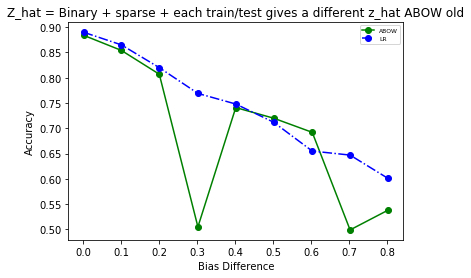

In [15]:
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.title('Z_hat = Binary + sparse + each train/test gives a different z_hat ABOW old')

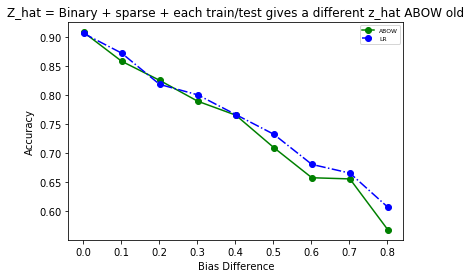

In [12]:
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')

plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.title('Z_hat = Binary + sparse + each train/test gives a different z_hat ABOW old')

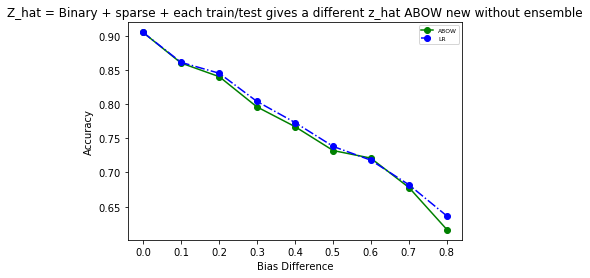

In [115]:
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.title('Z_hat = Binary + sparse + each train/test gives a different z_hat ABOW new without ensemble')

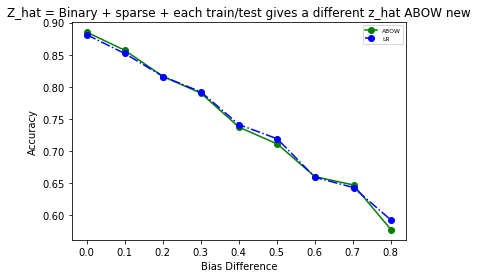

In [102]:
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')
plt.savefig('fig.png')
plt.title('Z_hat = Binary + sparse + each train/test gives a different z_hat ABOW new')

In [31]:
abow.model

In [13]:
models = glob.glob('/tmp'+'/*.hdf5')

In [14]:
models

['/tmp/abow.00295.hdf5',
 '/tmp/abow.00259.hdf5',
 '/tmp/abow.00090.hdf5',
 '/tmp/abow.00219.hdf5',
 '/tmp/abow.00051.hdf5',
 '/tmp/abow.00072.hdf5',
 '/tmp/abow.00136.hdf5',
 '/tmp/abow.00053.hdf5',
 '/tmp/abow.00035.hdf5',
 '/tmp/abow.00249.hdf5',
 '/tmp/abow.00290.hdf5',
 '/tmp/abow.00190.hdf5',
 '/tmp/abow.00299.hdf5',
 '/tmp/abow.00165.hdf5',
 '/tmp/abow.00244.hdf5',
 '/tmp/abow.00148.hdf5',
 '/tmp/abow.00173.hdf5',
 '/tmp/abow.00256.hdf5',
 '/tmp/abow.00124.hdf5',
 '/tmp/abow.00197.hdf5',
 '/tmp/abow.00264.hdf5',
 '/tmp/abow.00122.hdf5',
 '/tmp/abow.00298.hdf5',
 '/tmp/abow.00060.hdf5',
 '/tmp/abow.00191.hdf5',
 '/tmp/abow.00162.hdf5',
 '/tmp/abow.00172.hdf5',
 '/tmp/abow.00209.hdf5',
 '/tmp/abow.00081.hdf5',
 '/tmp/abow.00135.hdf5',
 '/tmp/abow.00228.hdf5',
 '/tmp/abow.00115.hdf5',
 '/tmp/abow.00073.hdf5',
 '/tmp/abow.00212.hdf5',
 '/tmp/abow.00217.hdf5',
 '/tmp/abow.00184.hdf5',
 '/tmp/abow.00046.hdf5',
 '/tmp/abow.00097.hdf5',
 '/tmp/abow.00237.hdf5',
 '/tmp/abow.00040.hdf5',


/home/ttran/.conda/envs/adaptive_confound_py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


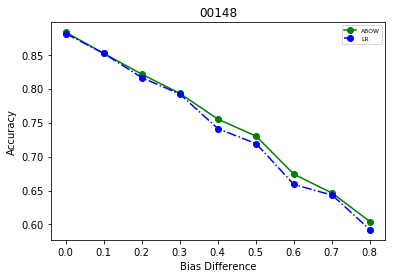

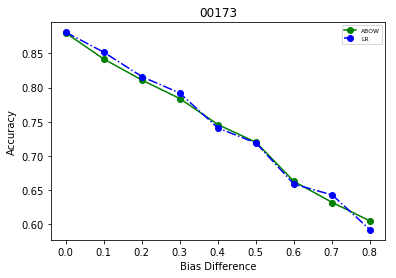

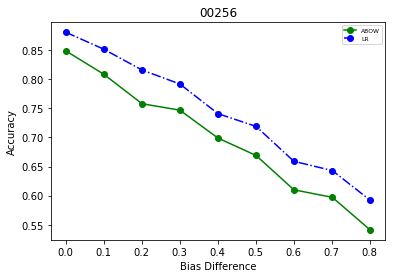

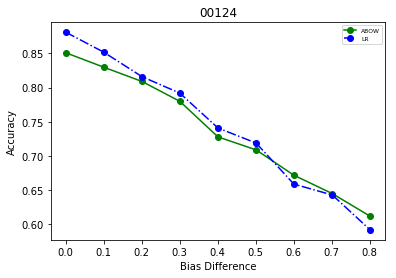

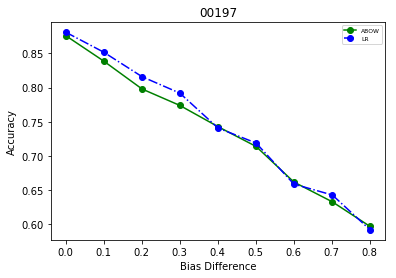

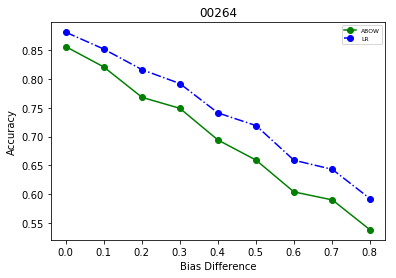

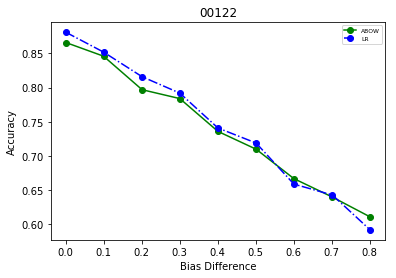

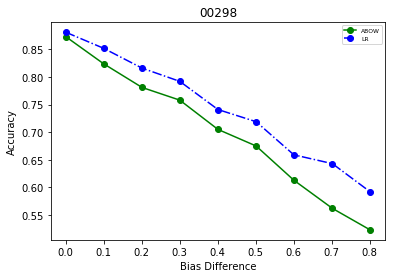

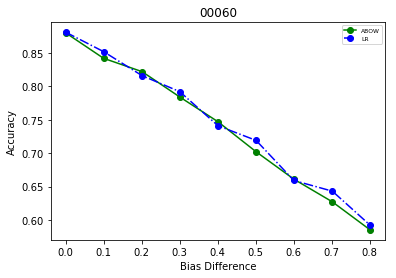

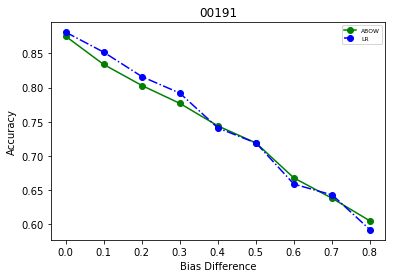

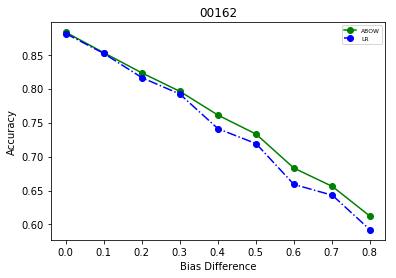

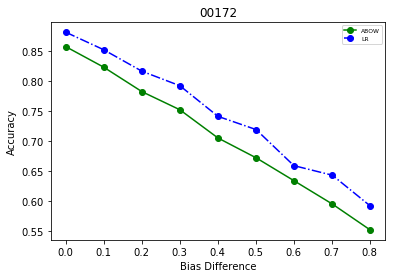

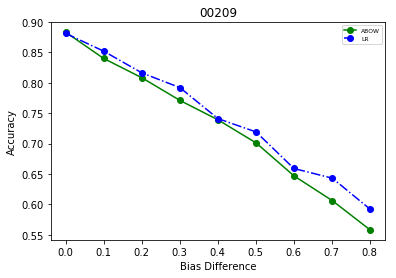

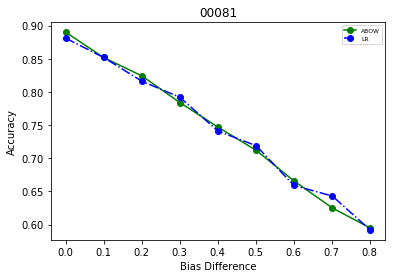

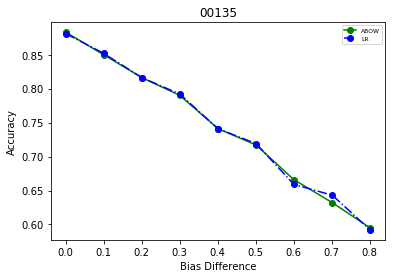

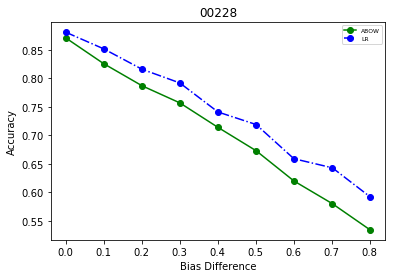

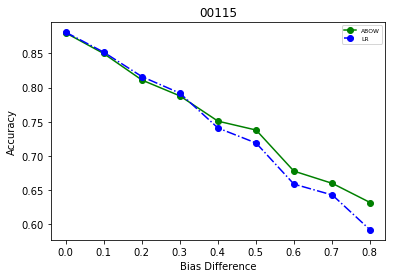

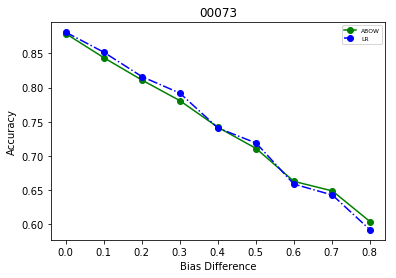

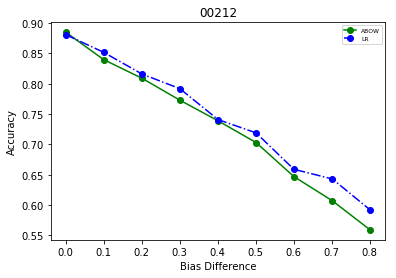

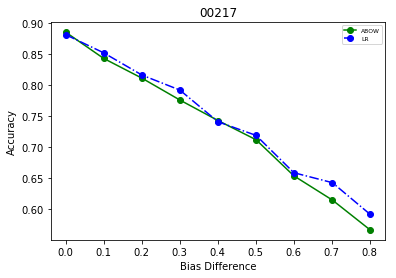

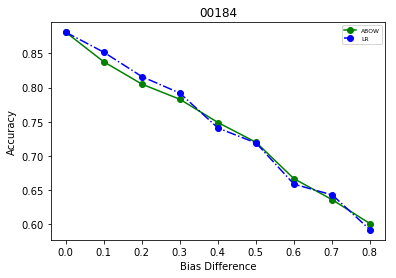

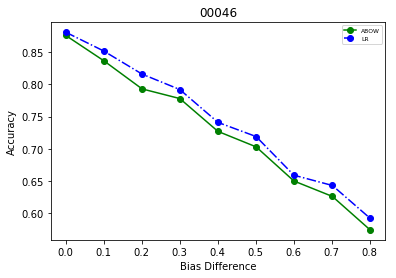

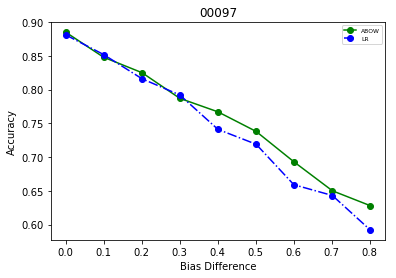

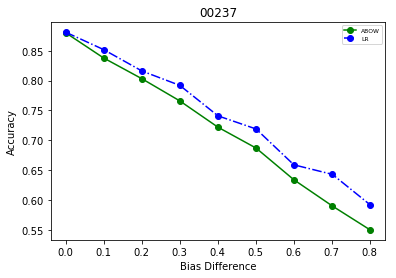

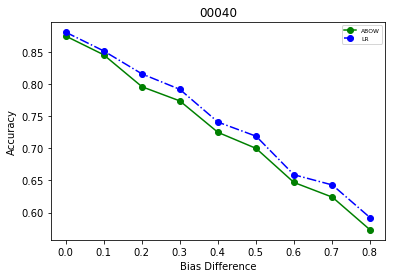

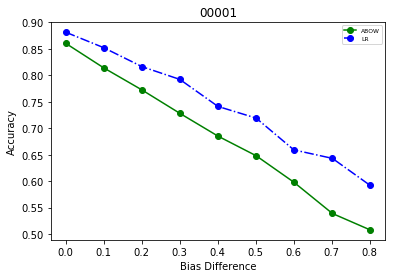

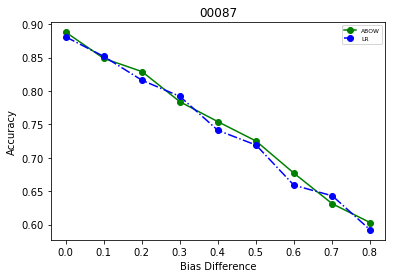

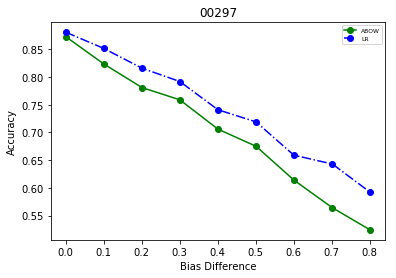

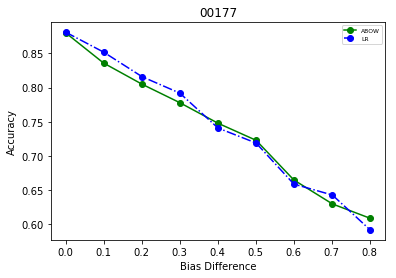

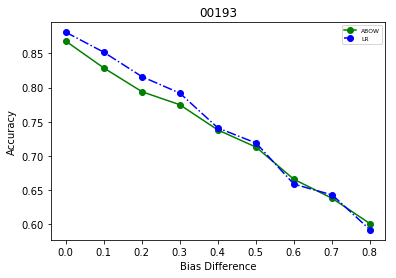

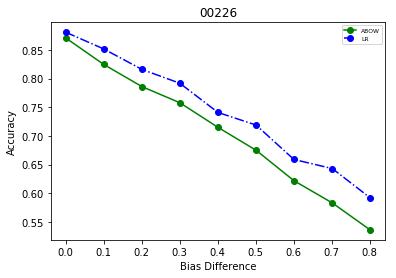

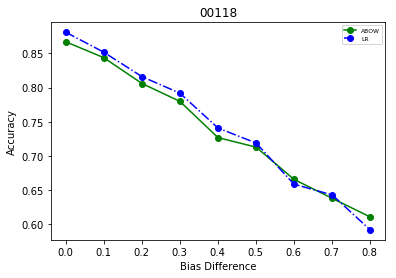

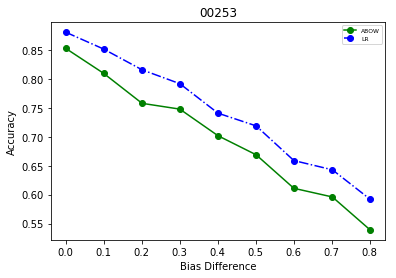

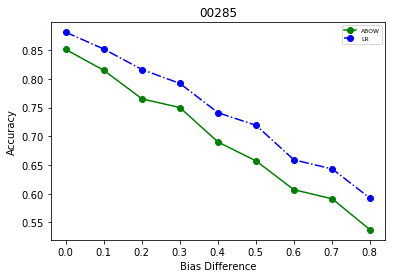

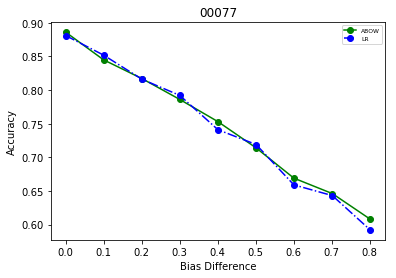

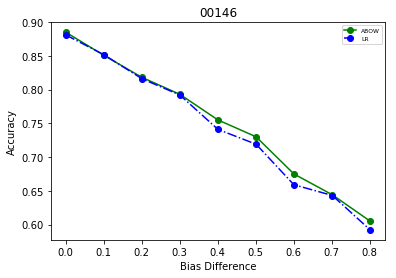

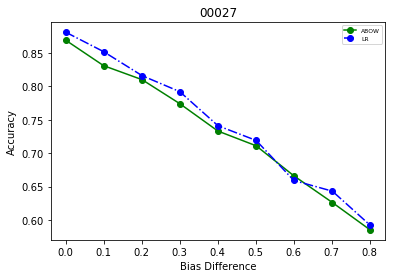

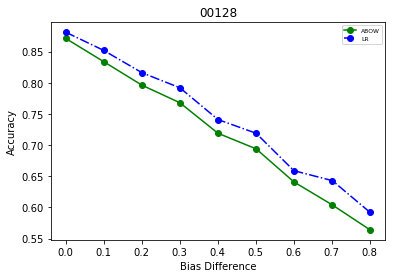

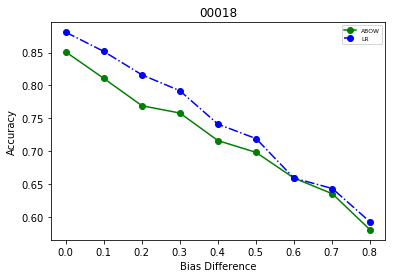

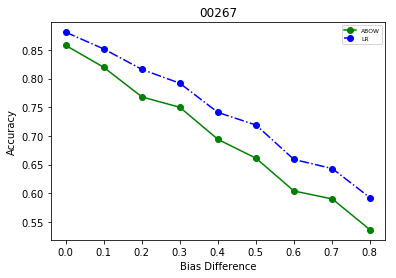

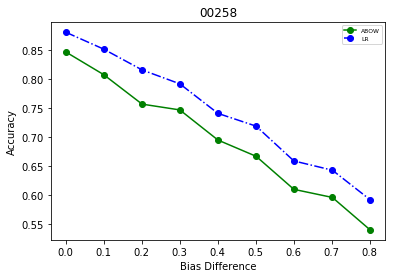

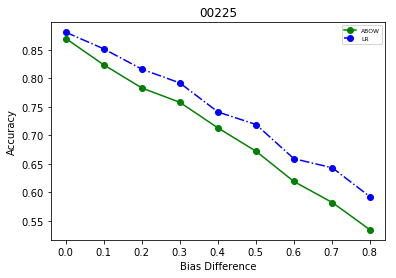

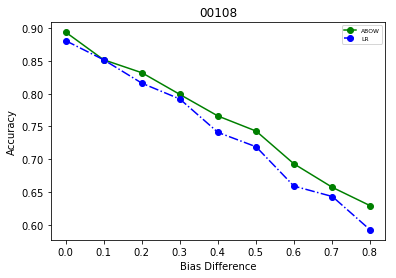

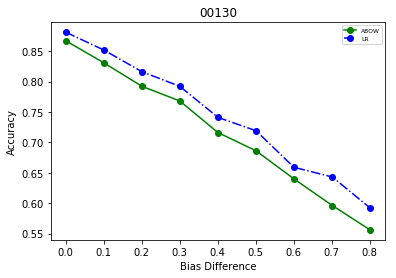

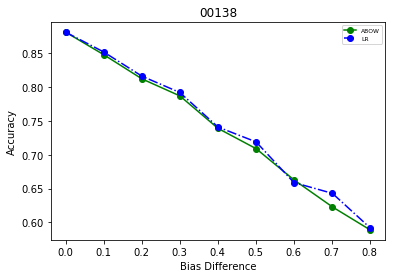

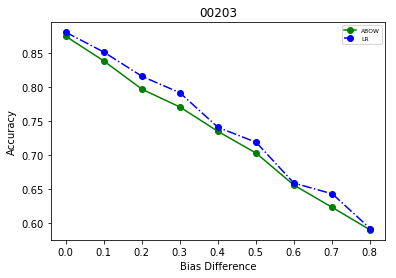

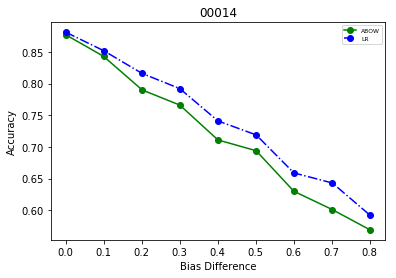

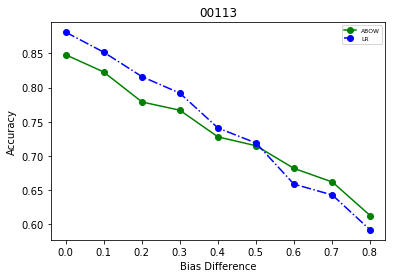

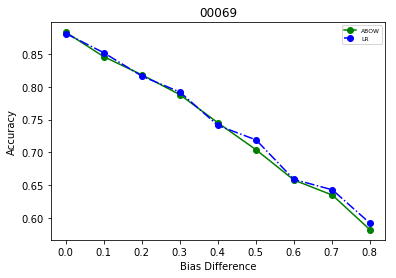

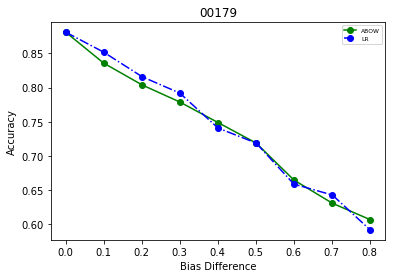

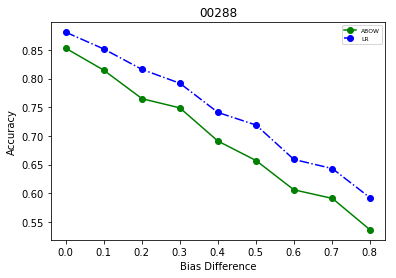

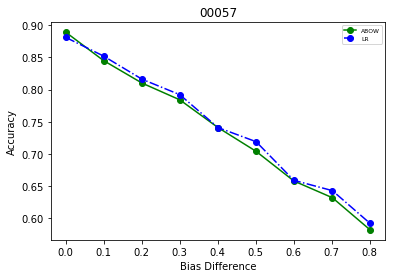

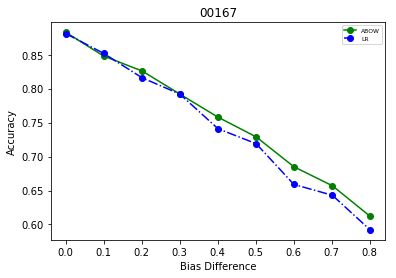

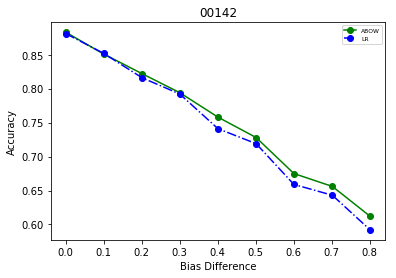

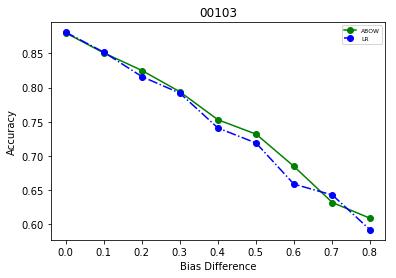

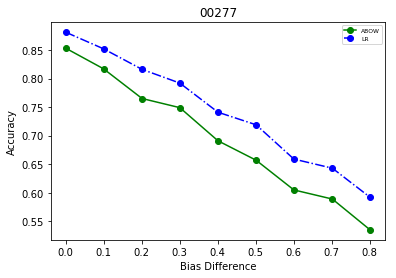

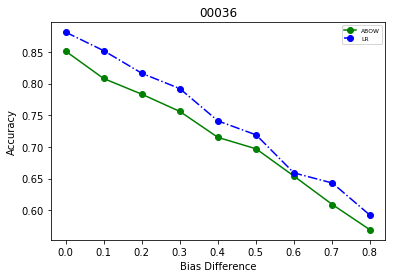

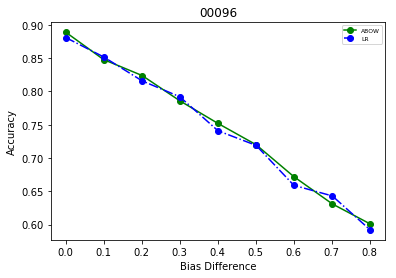

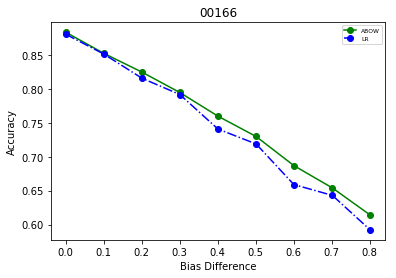

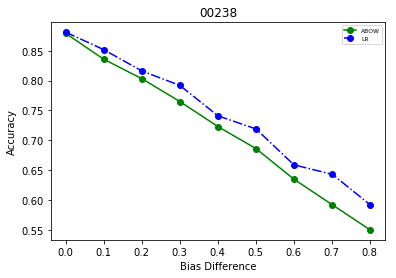

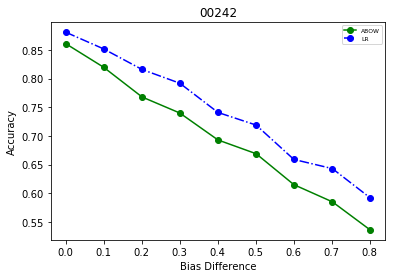

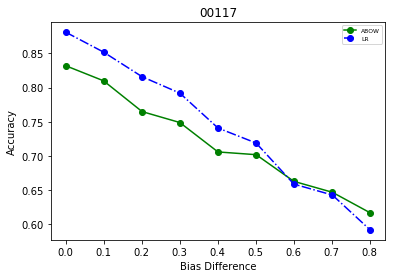

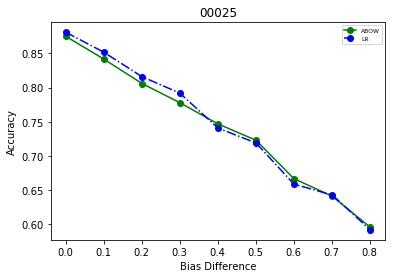

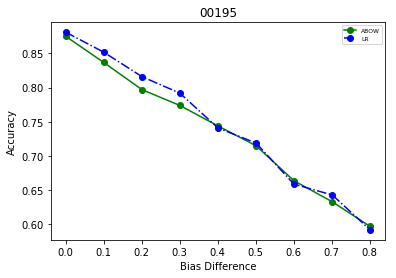

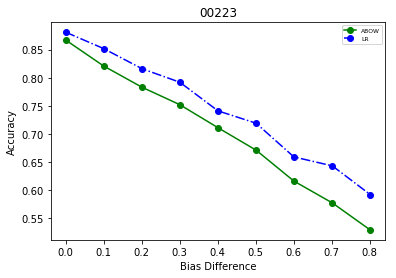

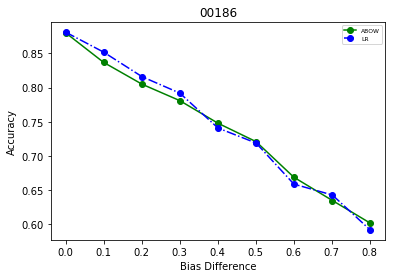

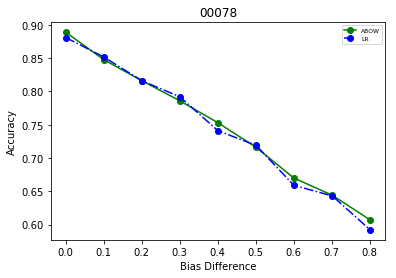

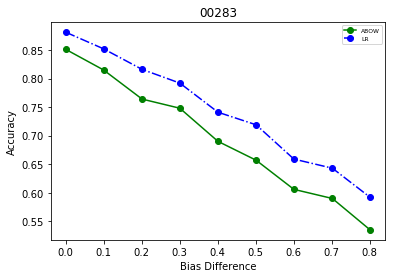

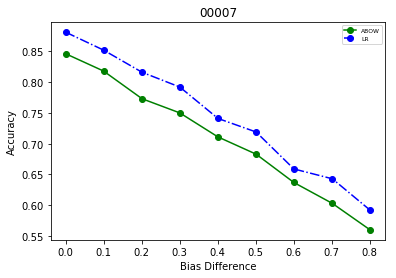

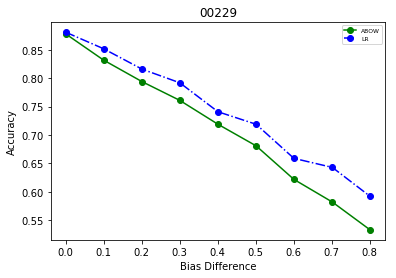

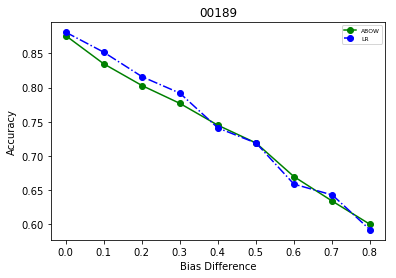

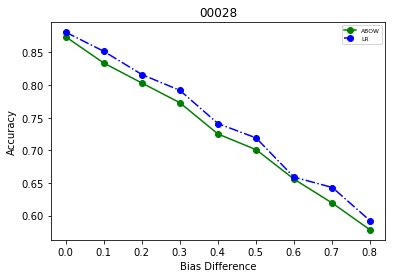

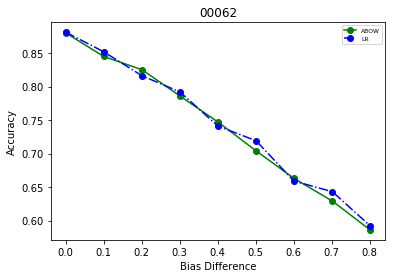

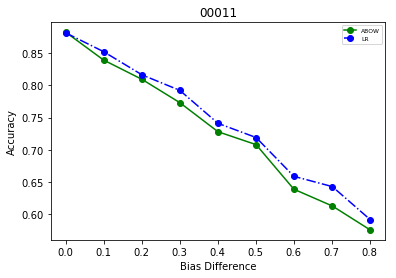

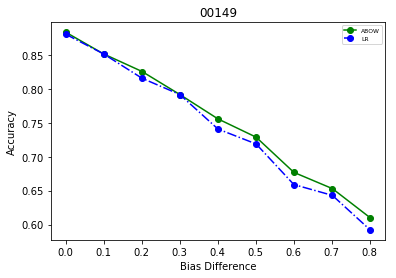

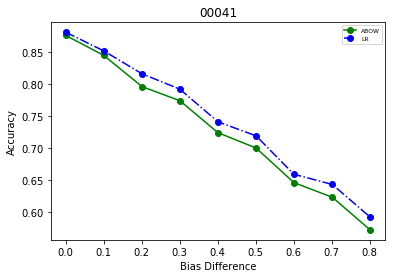

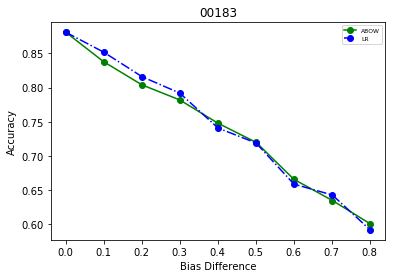

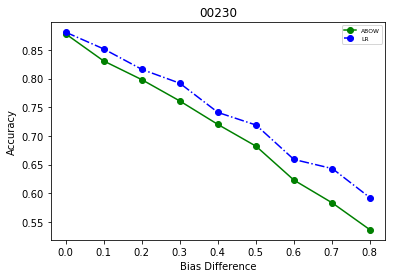

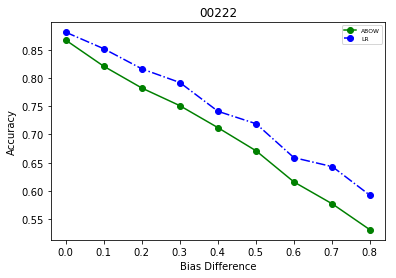

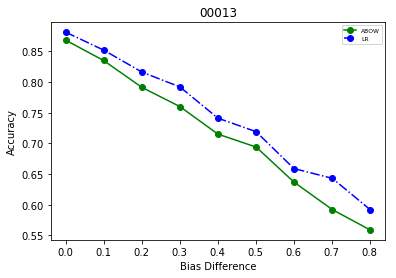

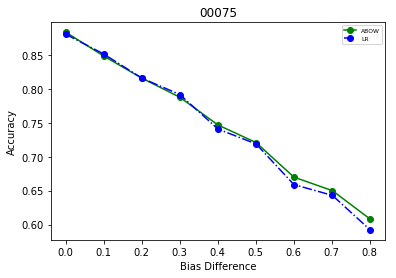

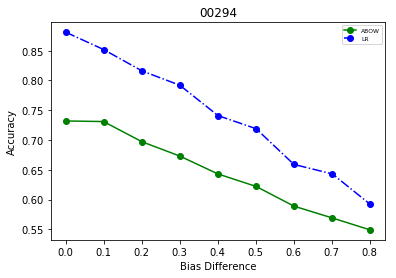

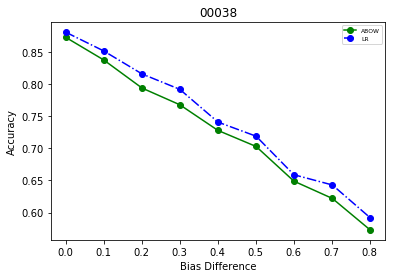

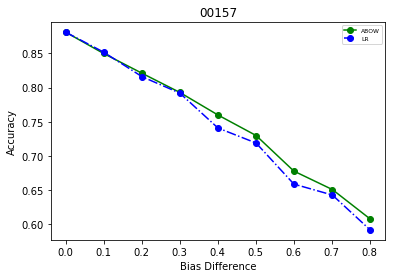

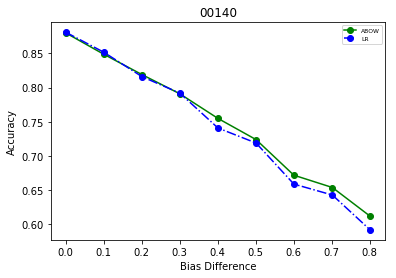

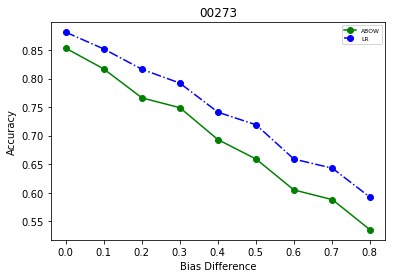

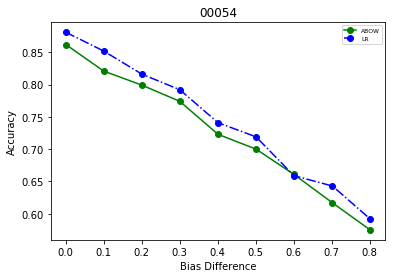

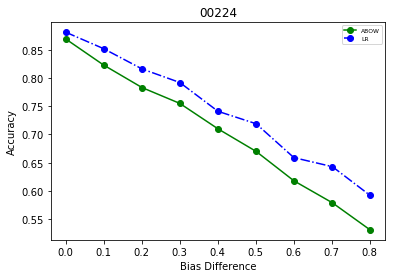

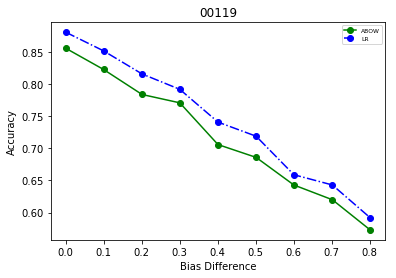

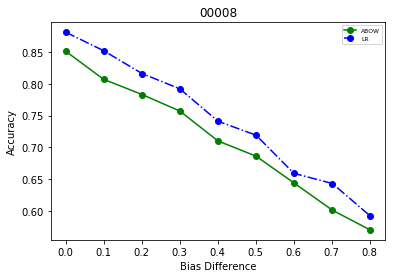

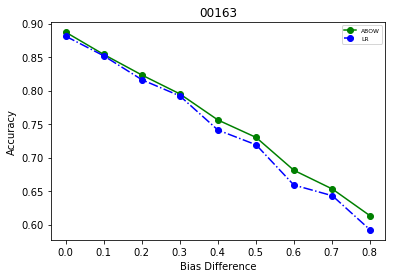

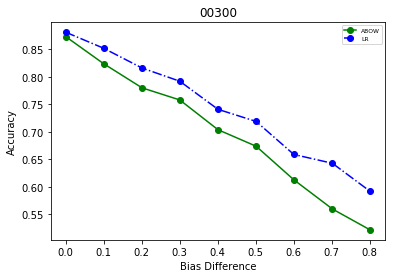

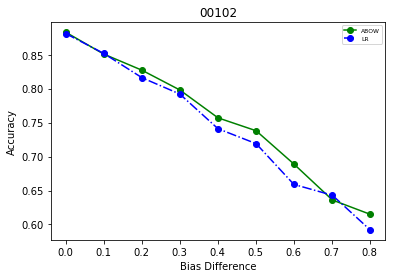

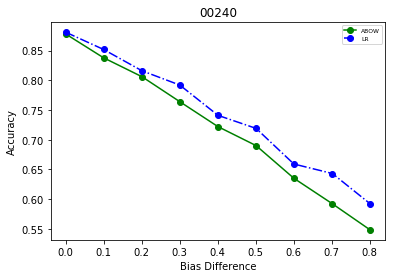

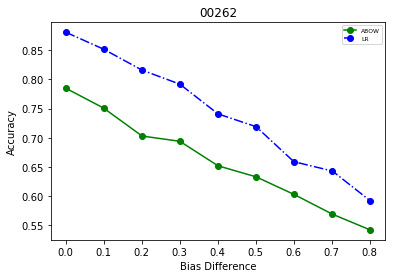

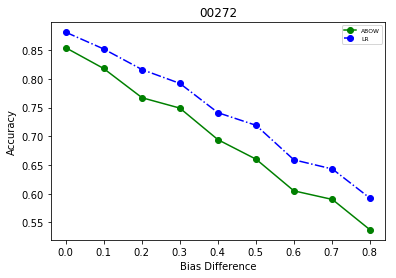

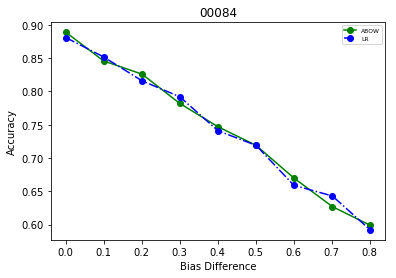

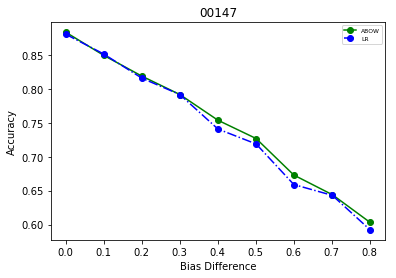

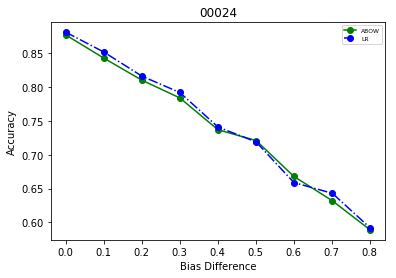

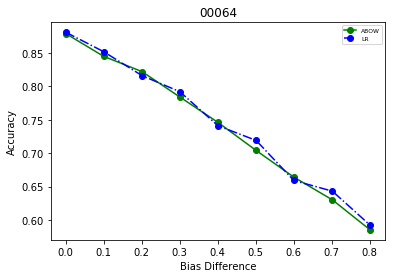

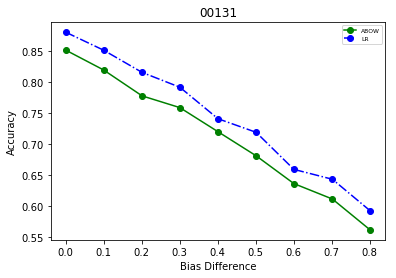

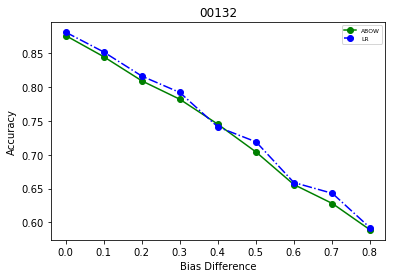

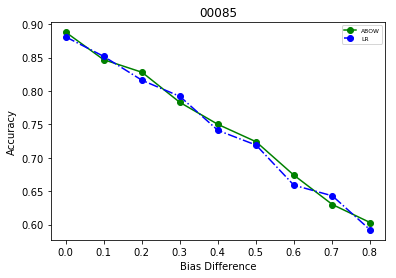

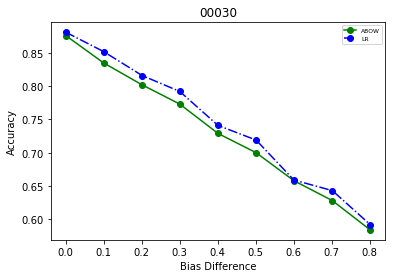

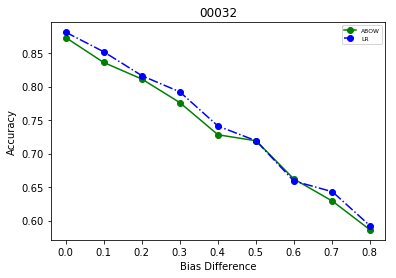

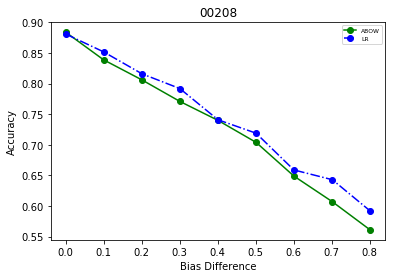

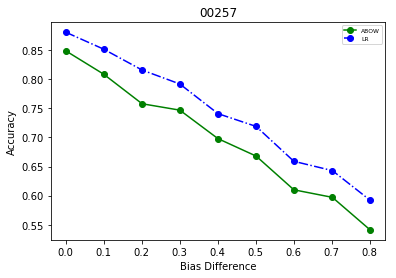

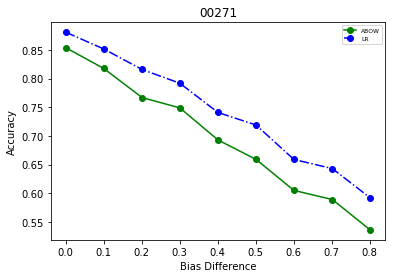

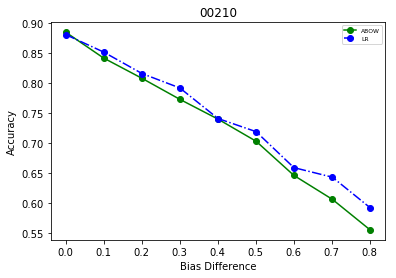

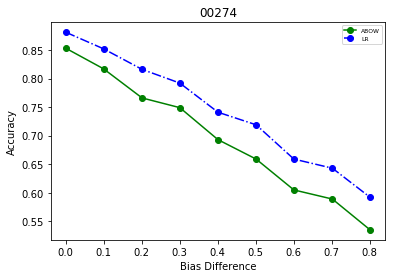

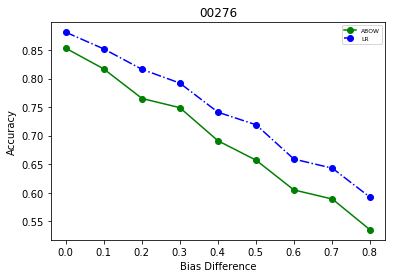

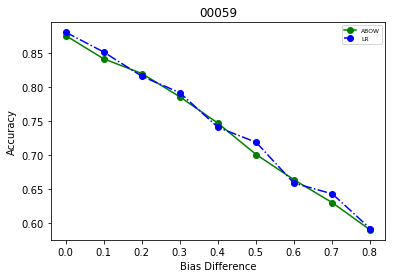

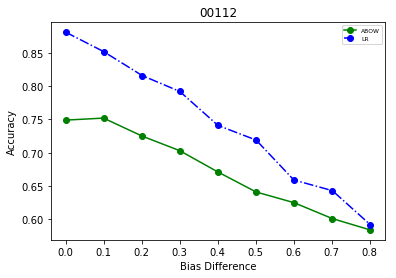

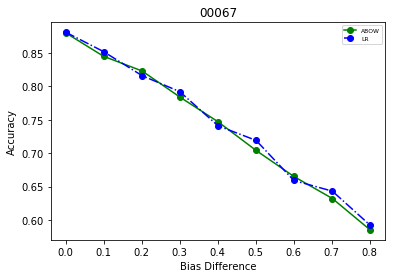

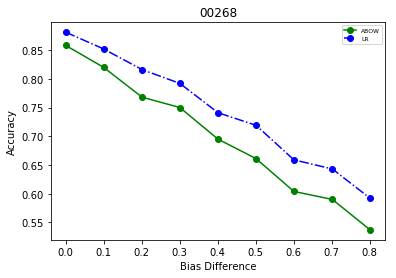

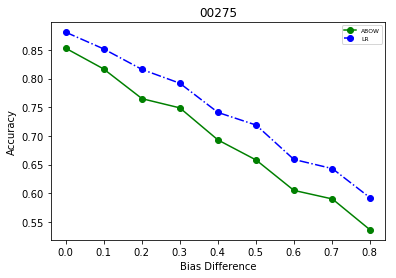

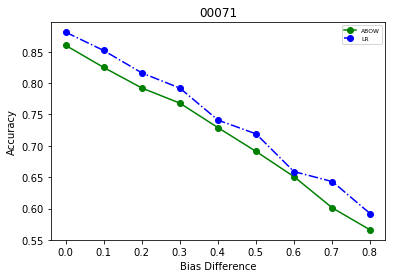

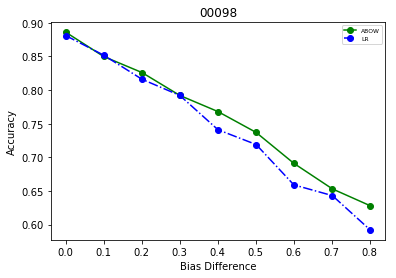

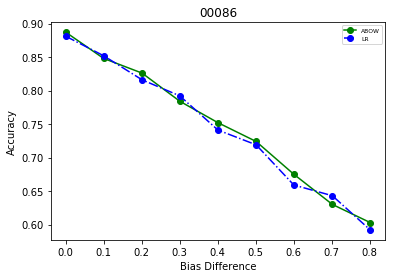

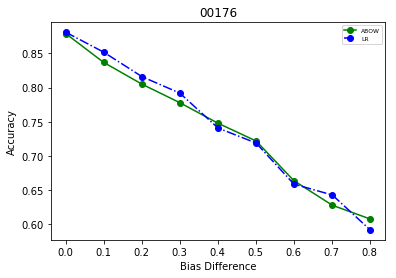

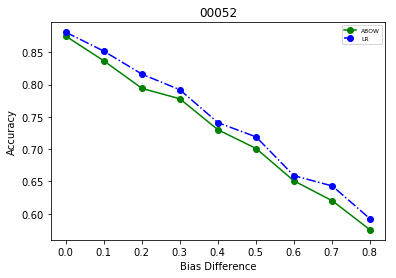

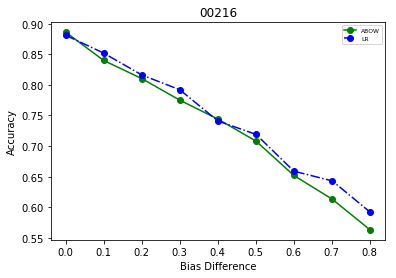

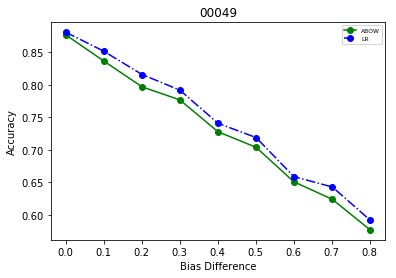

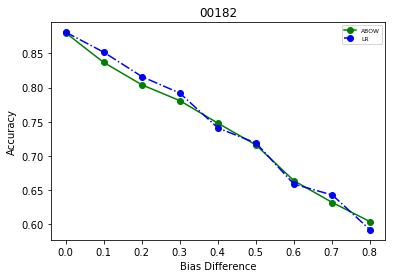

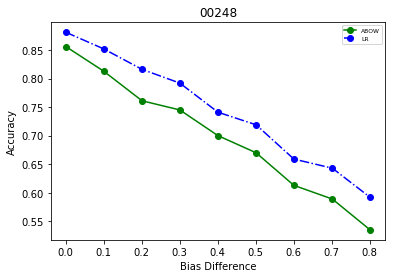

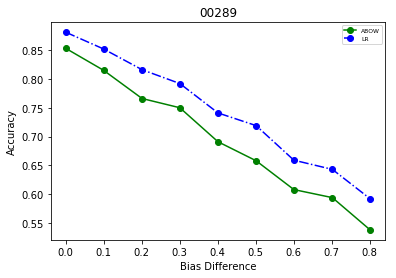

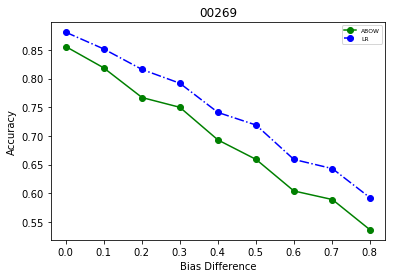

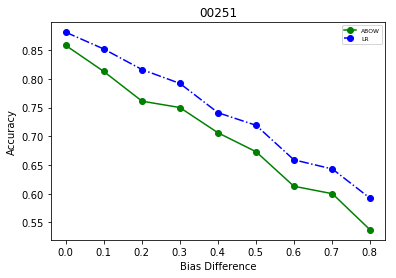

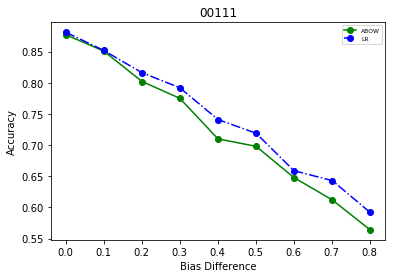

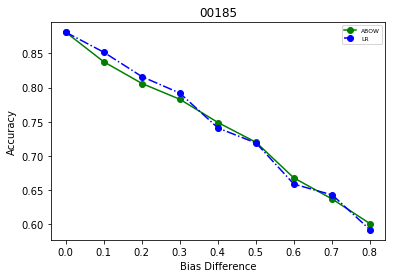

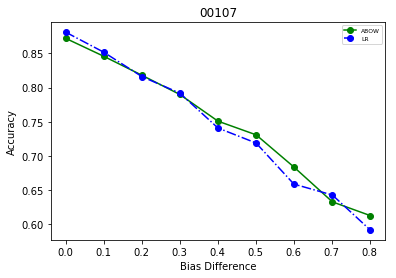

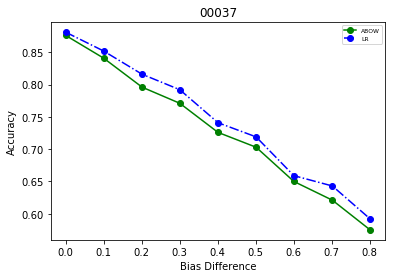

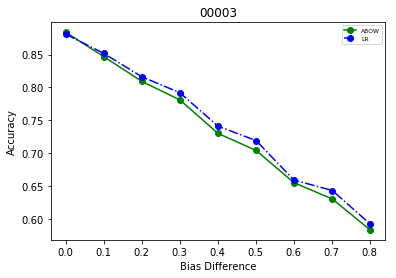

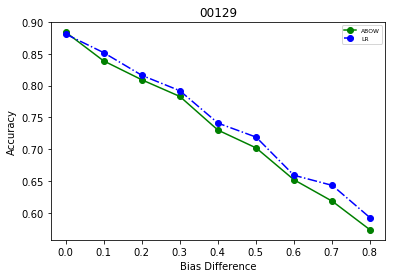

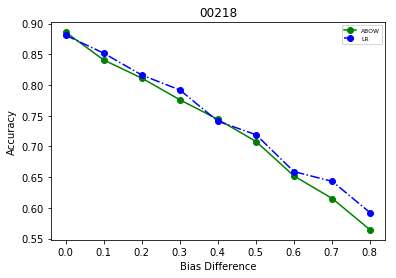

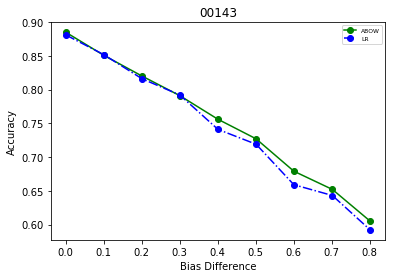

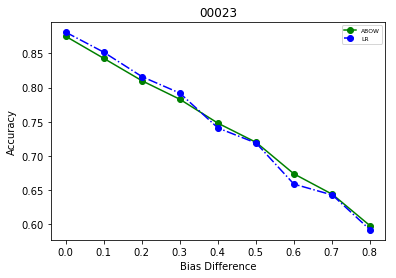

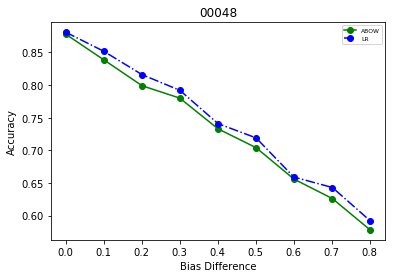

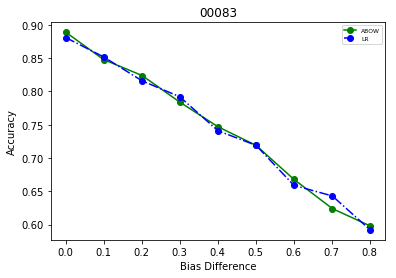

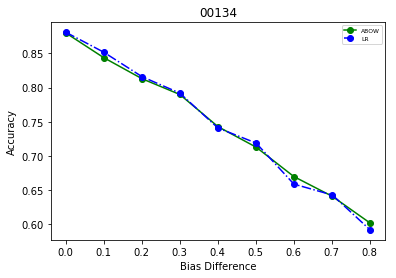

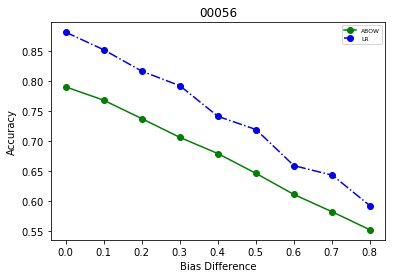

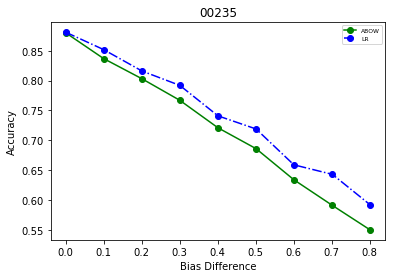

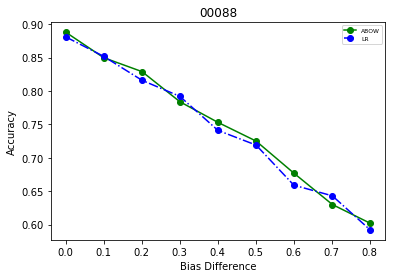

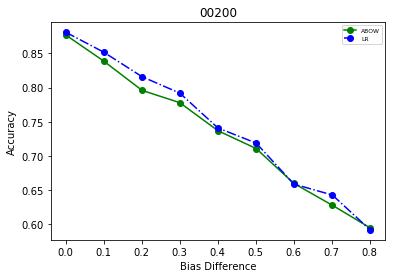

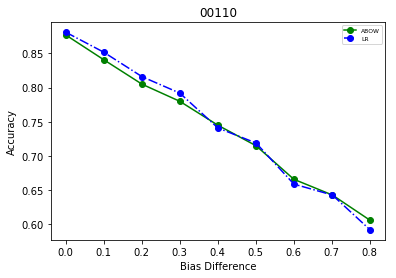

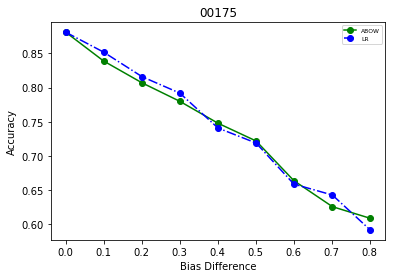

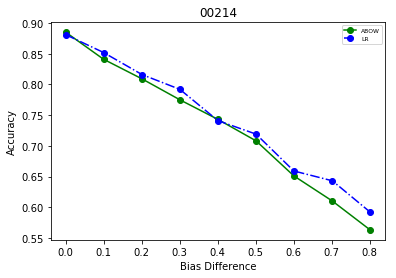

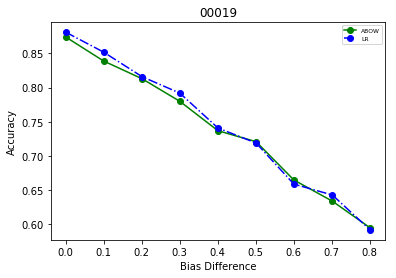

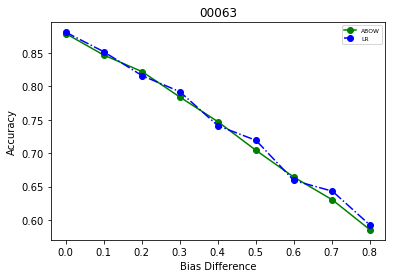

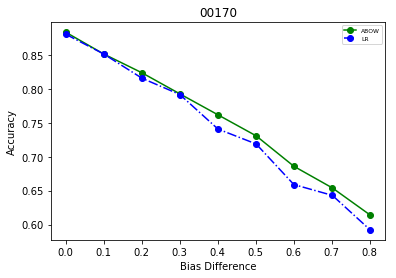

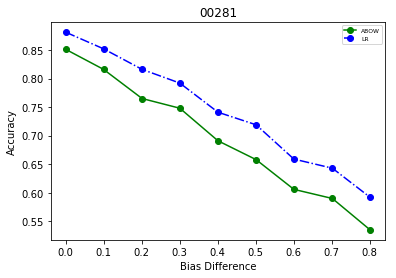

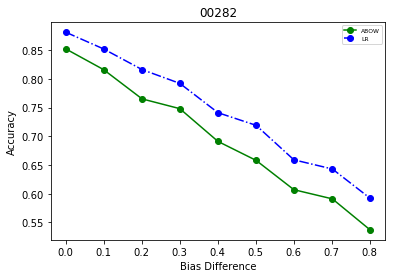

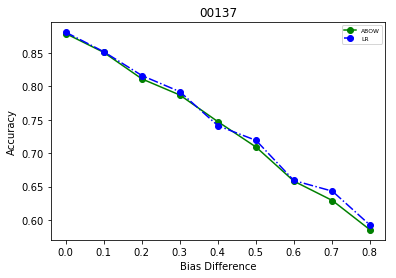

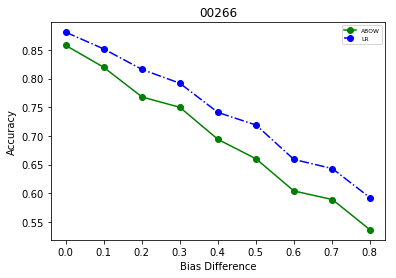

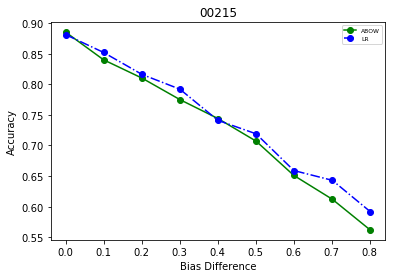

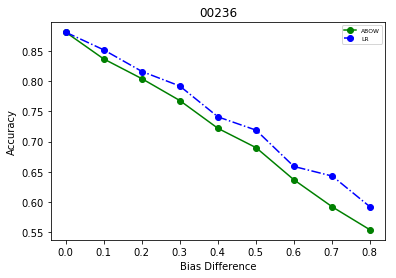

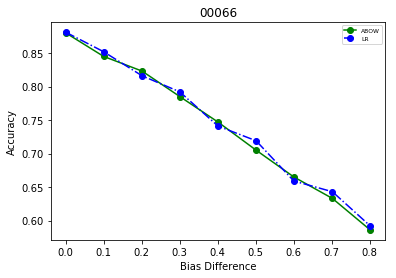

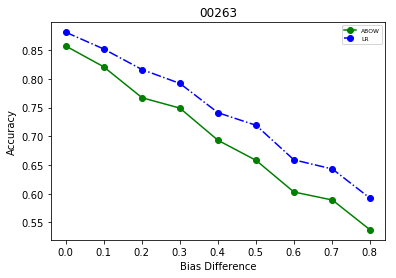

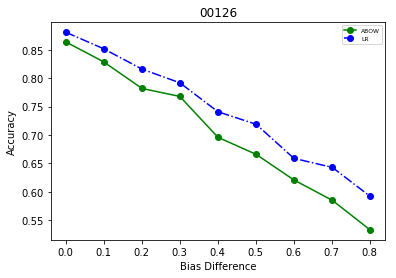

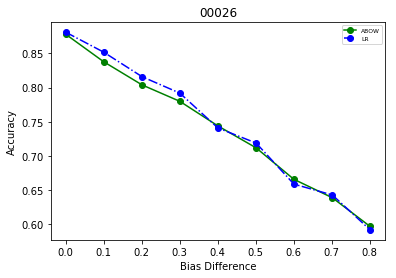

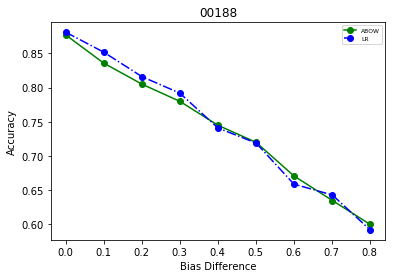

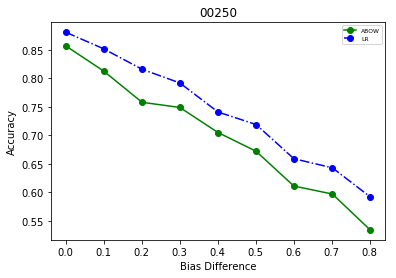

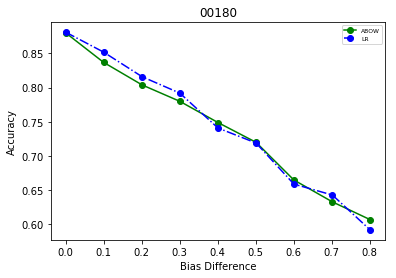

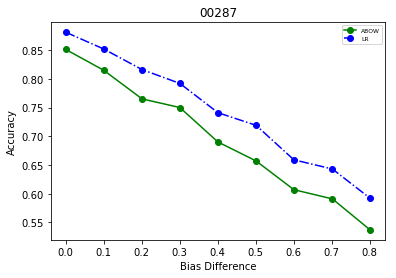

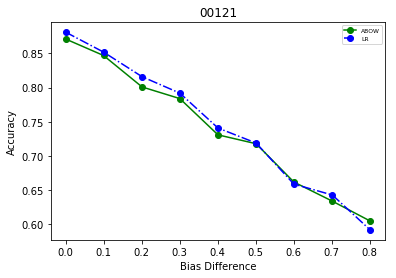

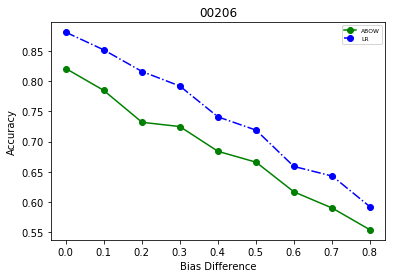

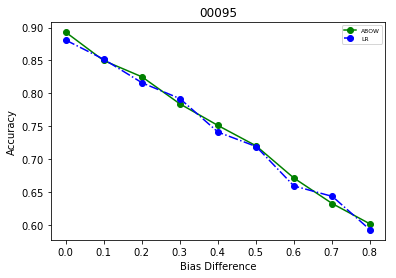

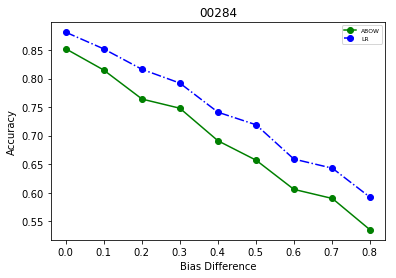

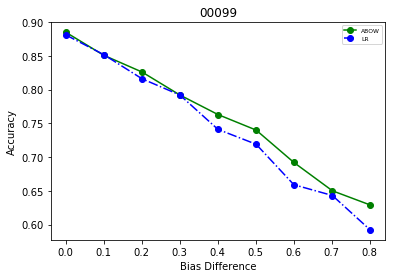

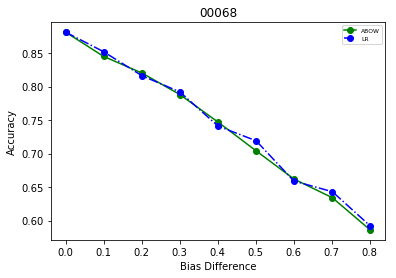

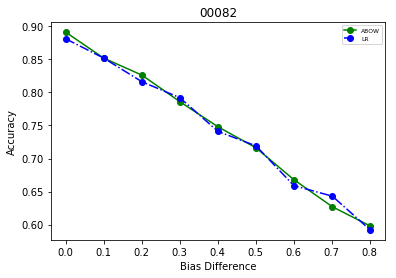

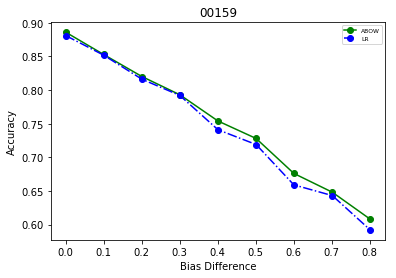

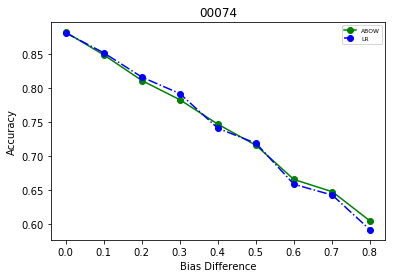

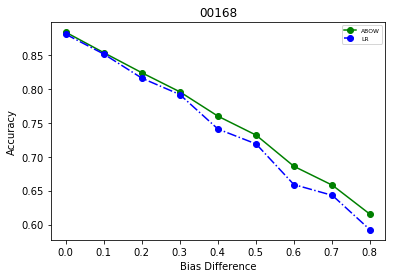

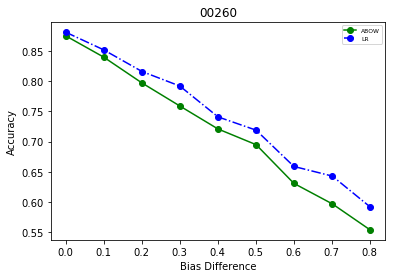

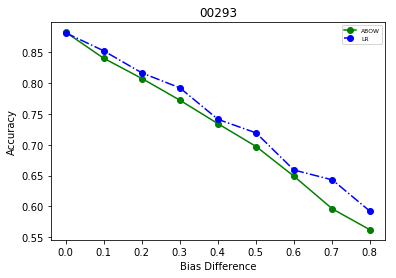

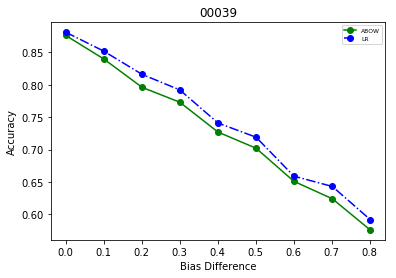

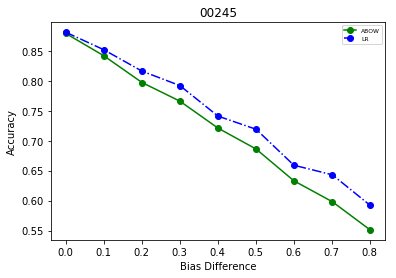

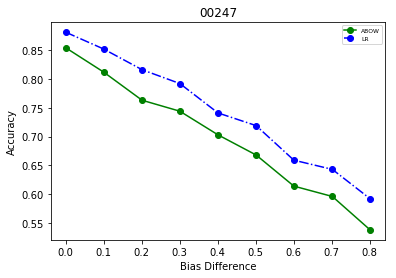

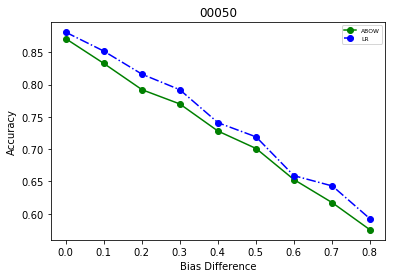

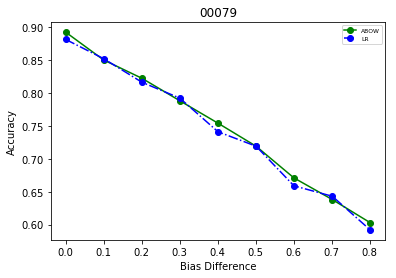

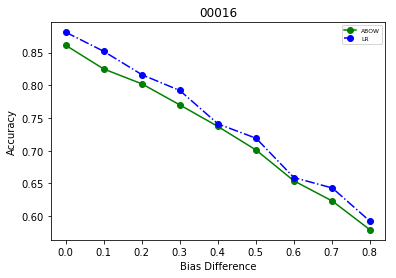

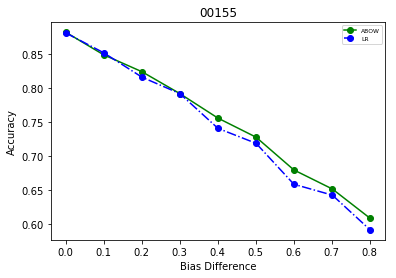

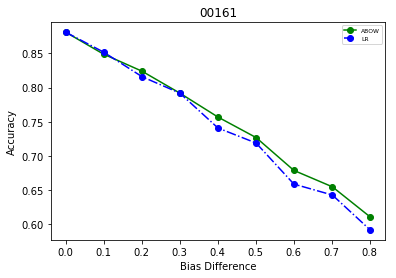

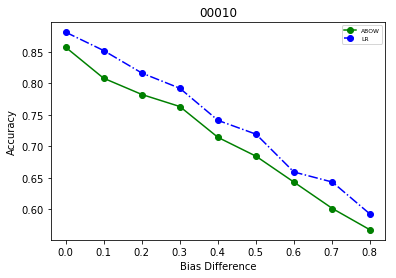

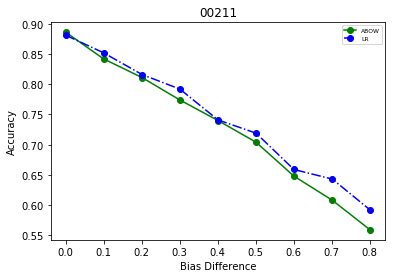

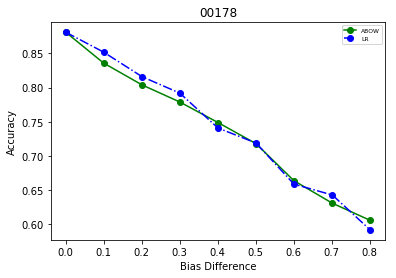

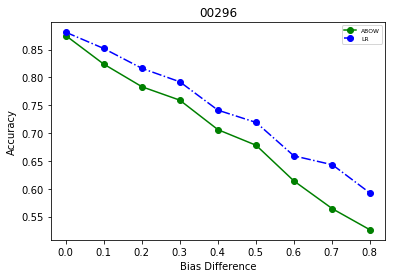

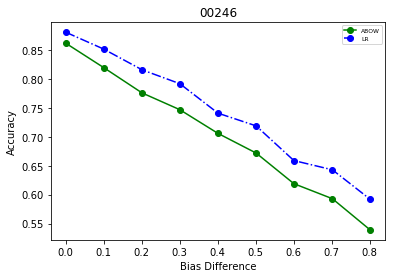

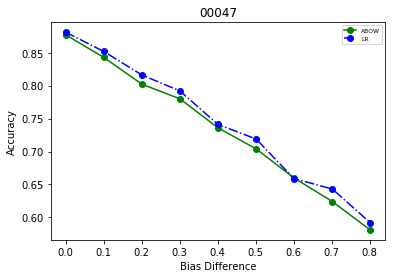

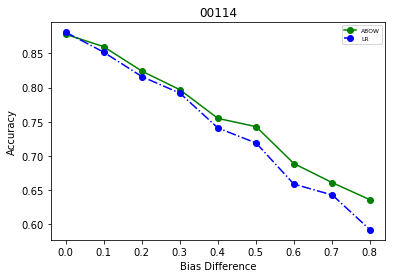

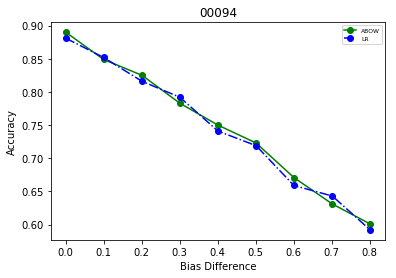

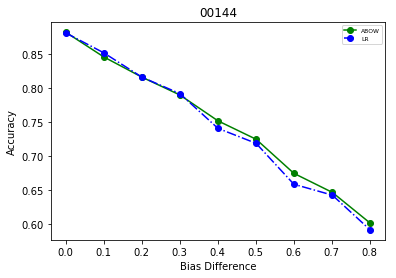

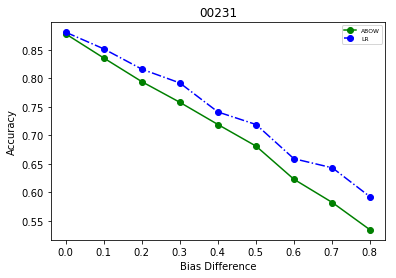

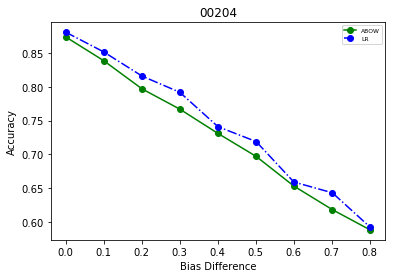

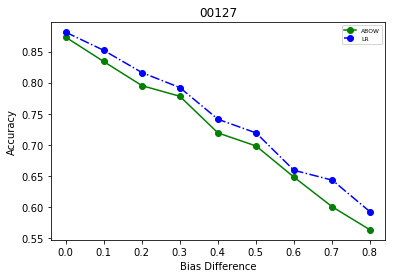

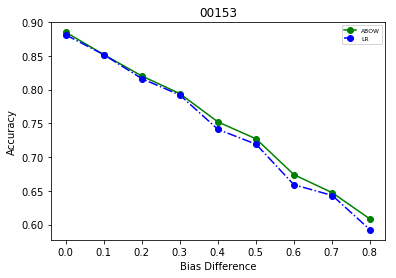

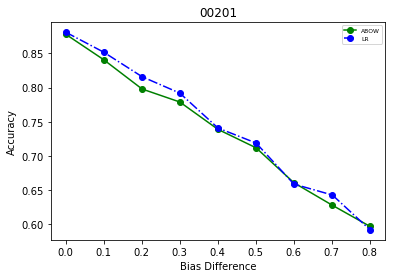

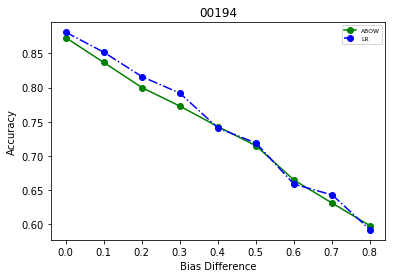

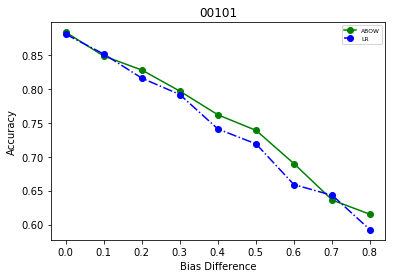

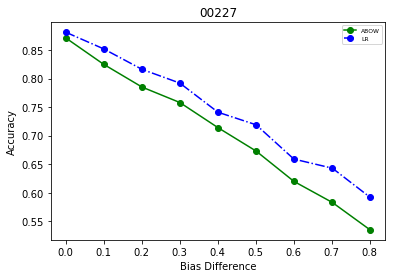

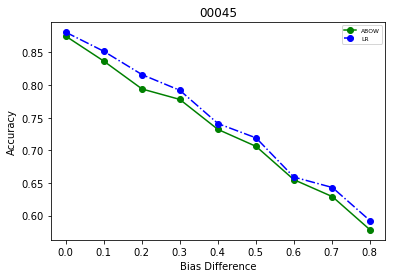

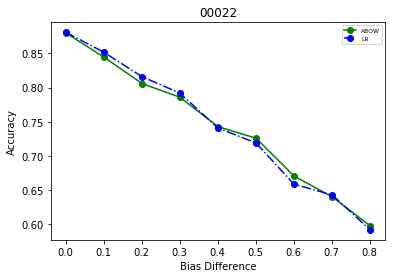

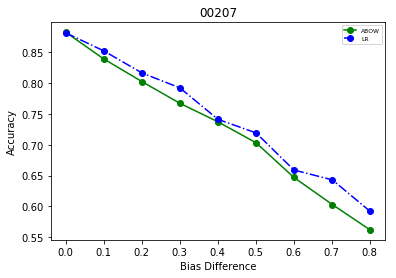

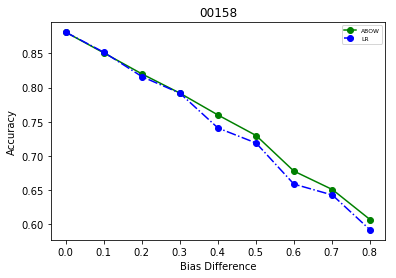

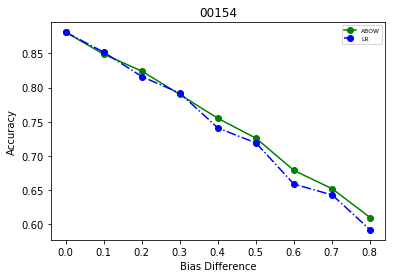

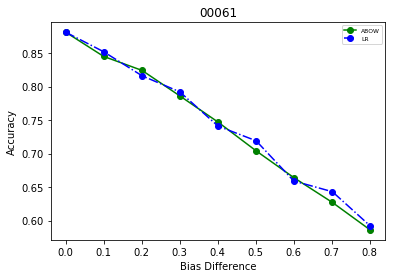

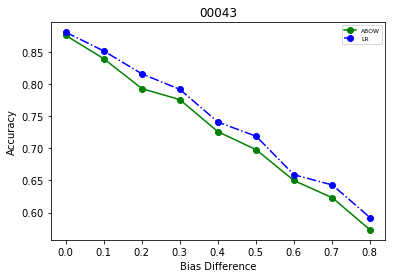

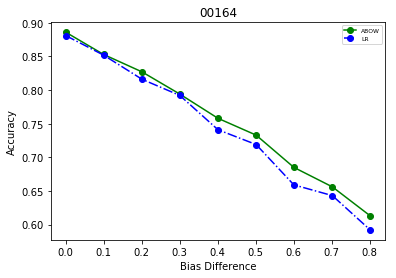

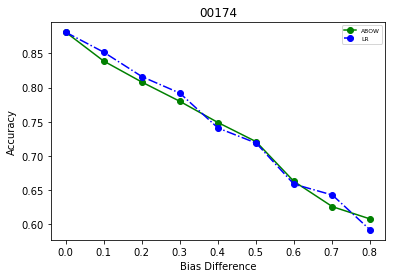

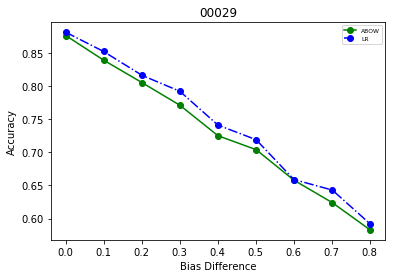

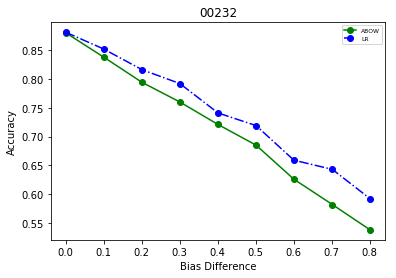

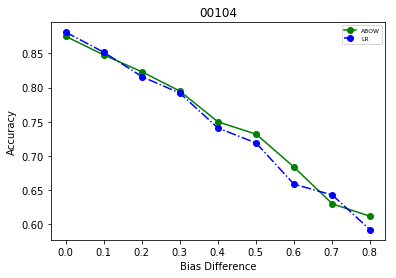

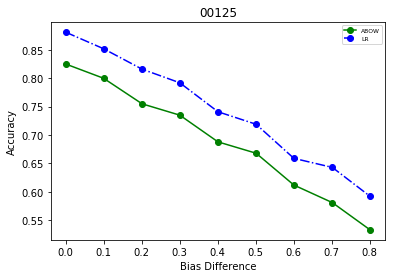

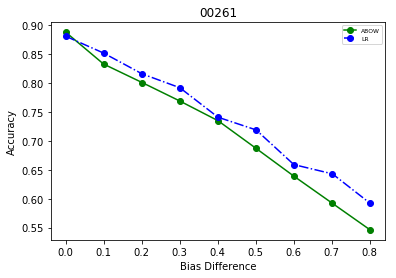

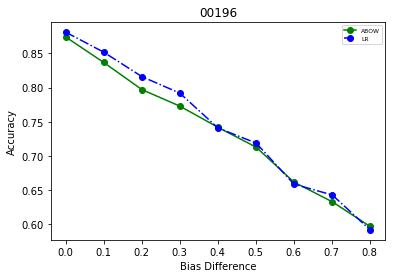

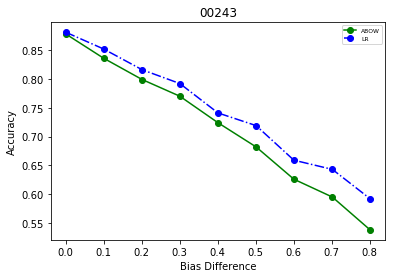

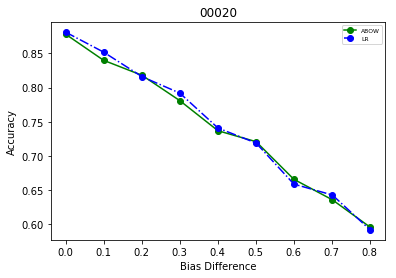

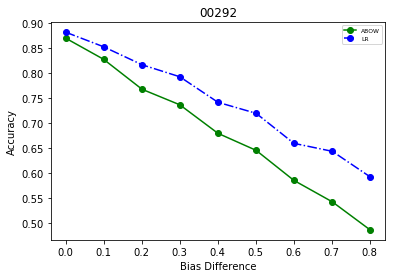

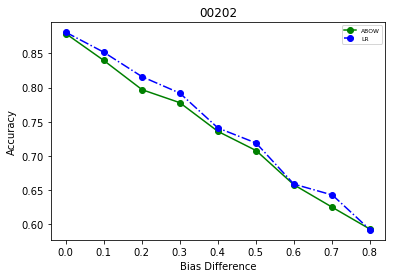

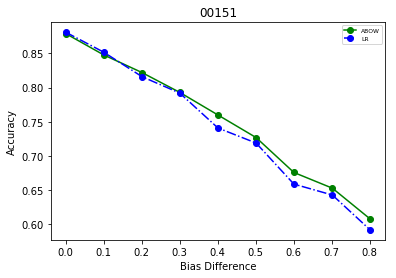

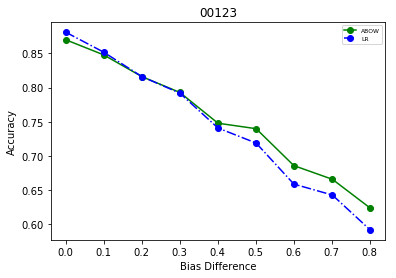

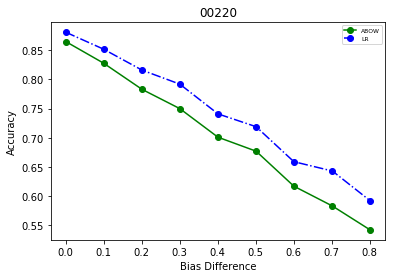

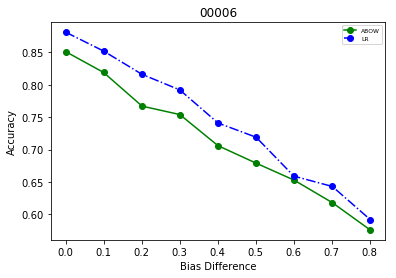

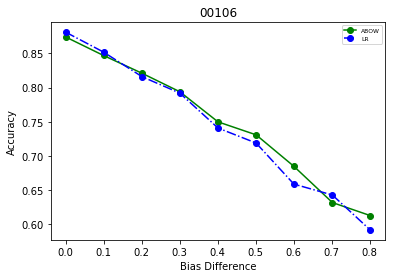

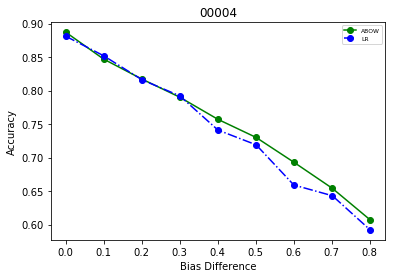

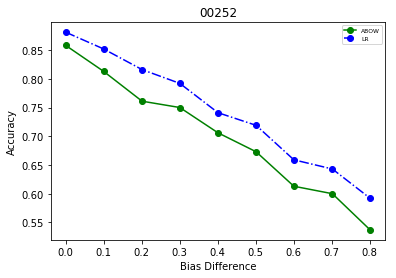

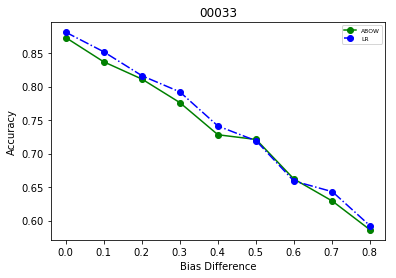

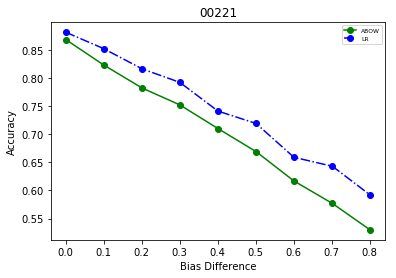

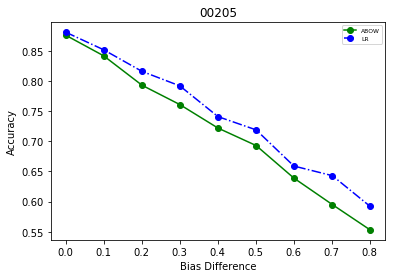

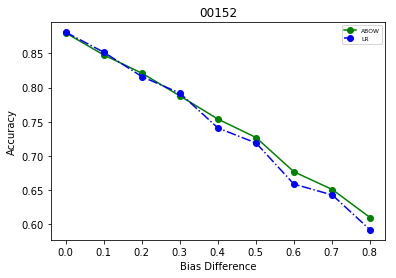

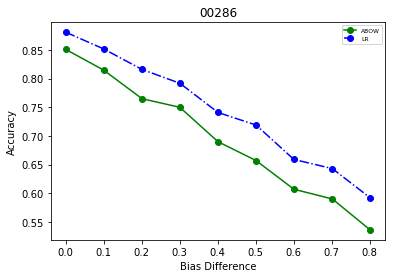

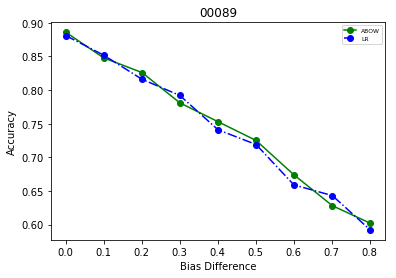

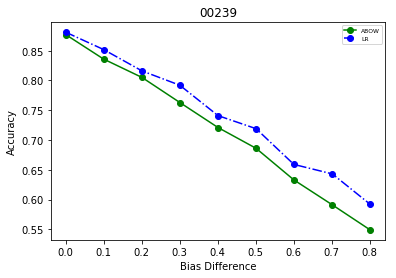

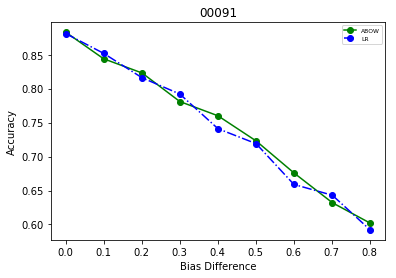

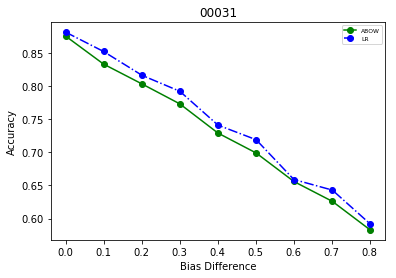

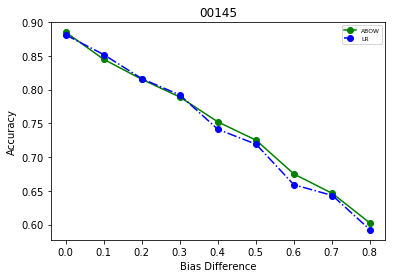

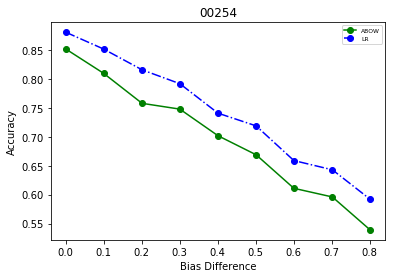

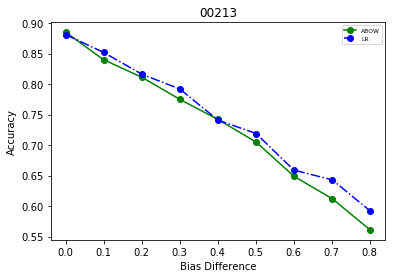

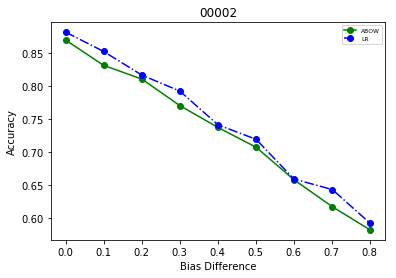

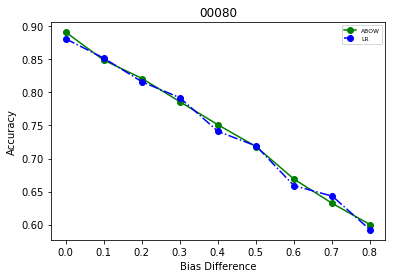

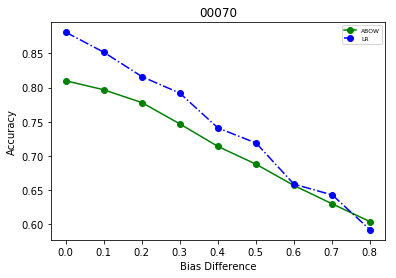

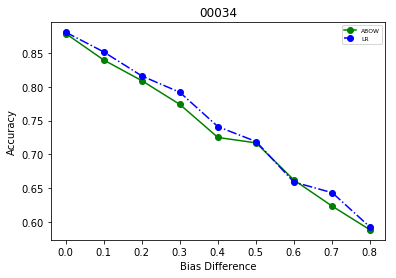

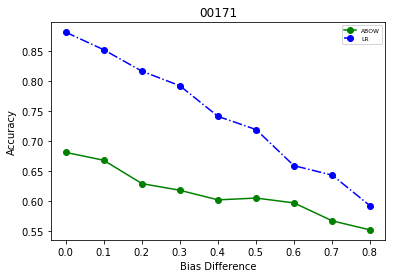

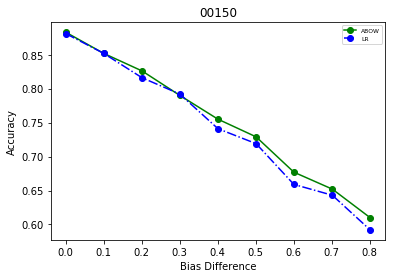

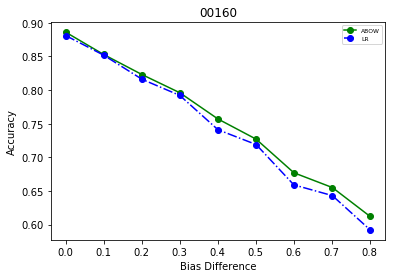

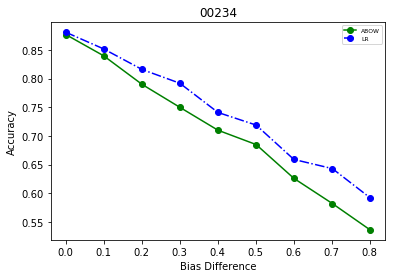

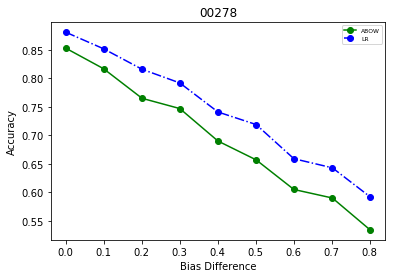

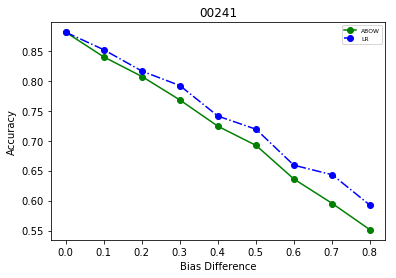

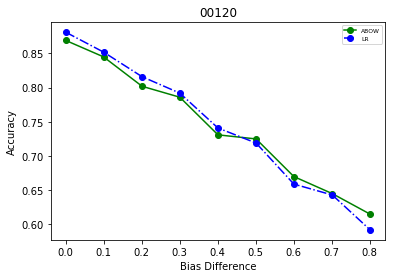

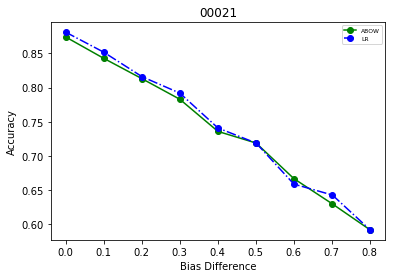

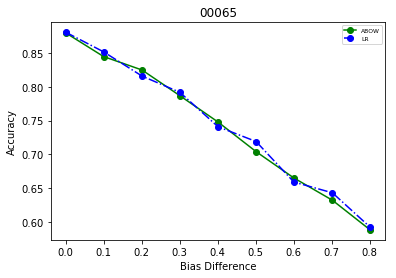

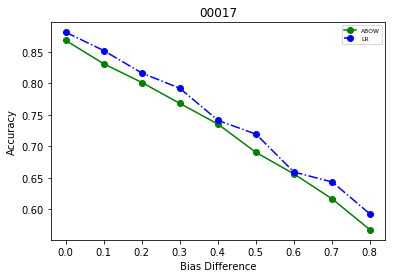

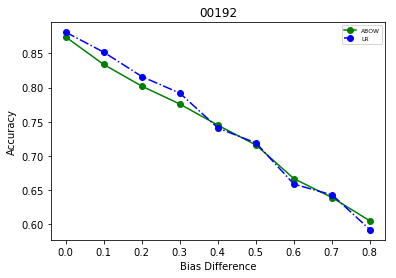

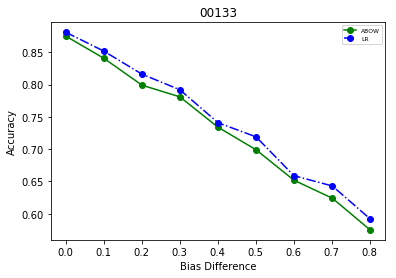

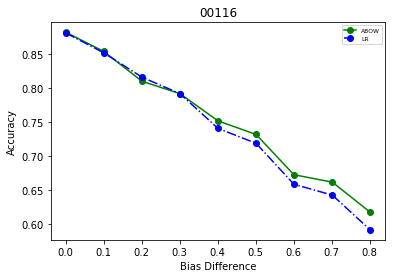

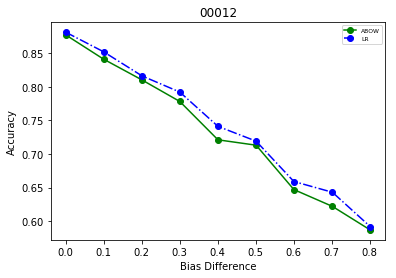

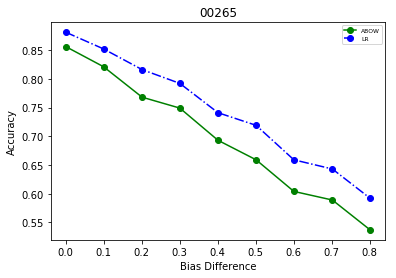

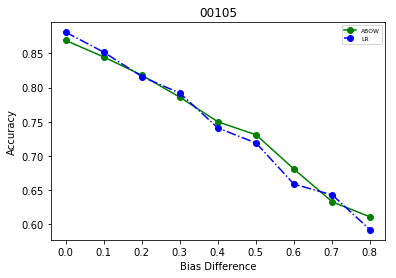

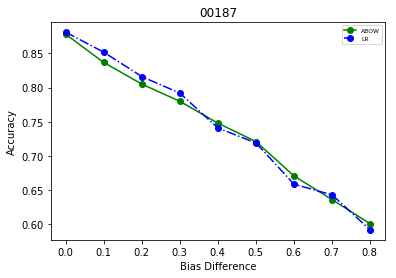

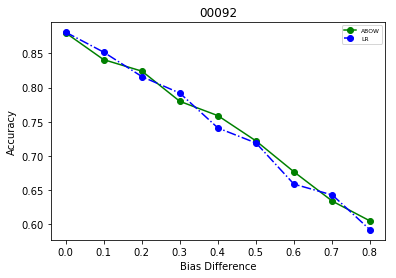

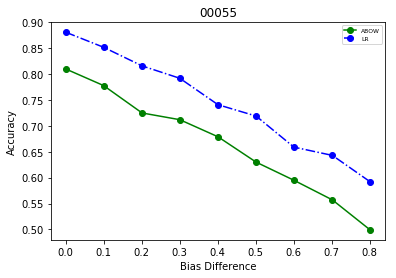

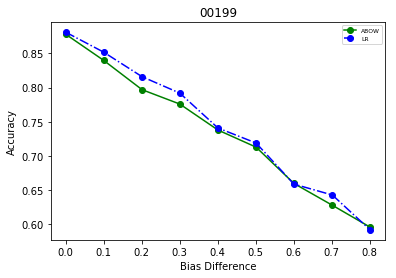

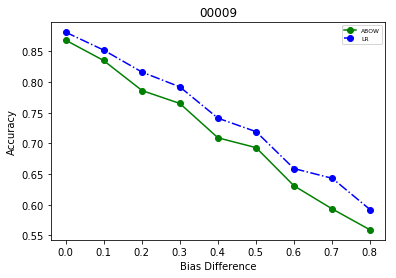

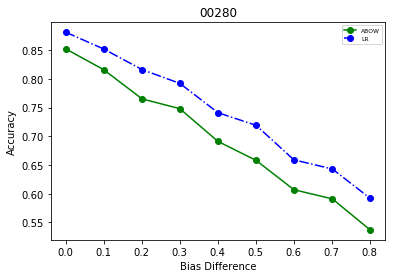

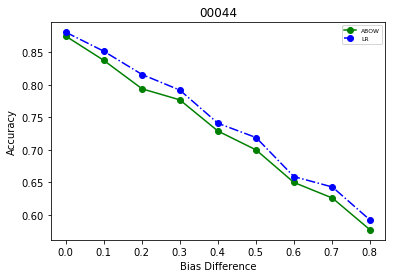

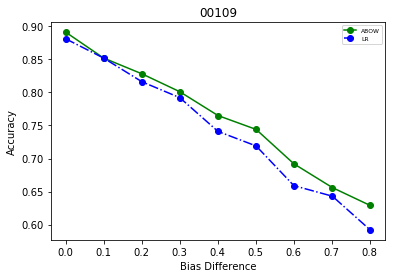

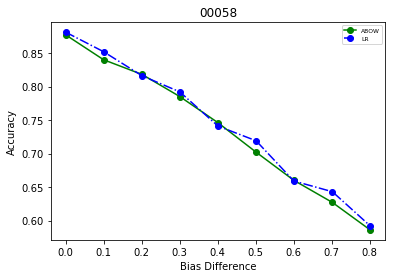

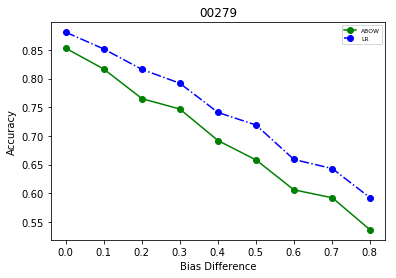

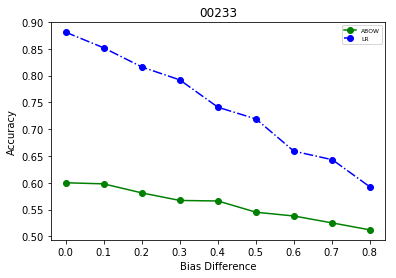

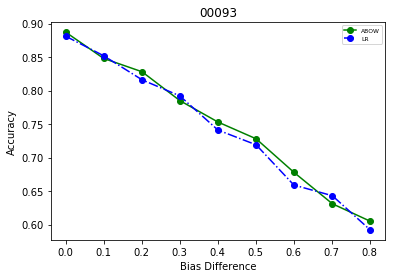

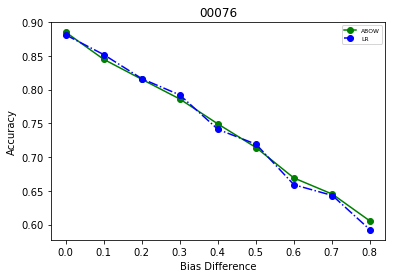

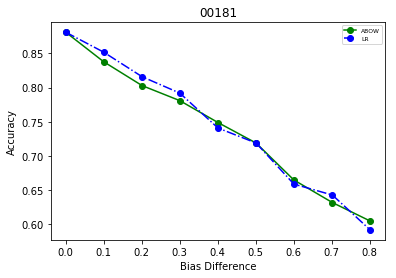

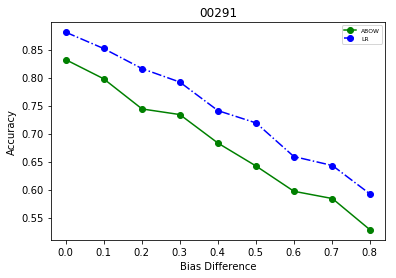

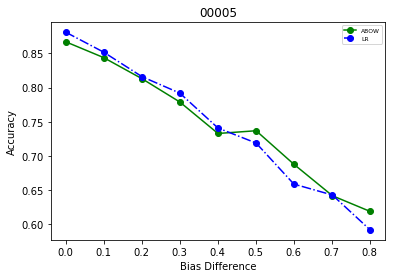

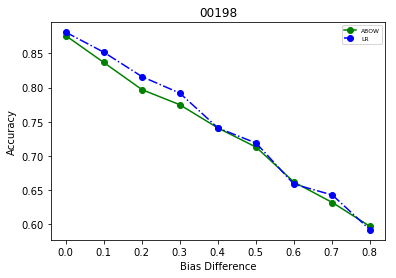

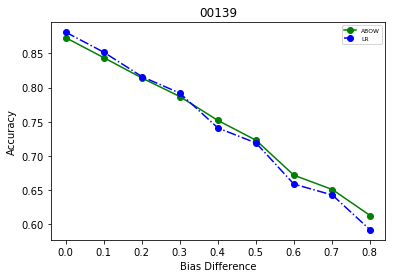

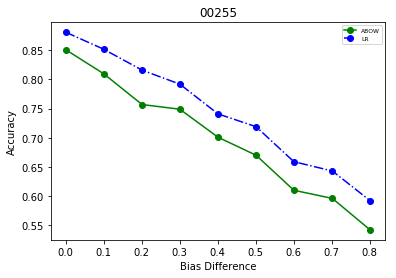

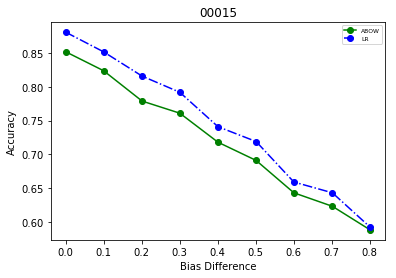

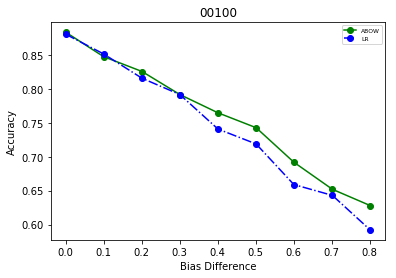

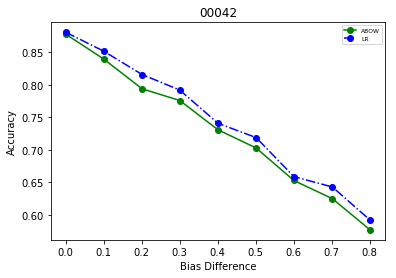

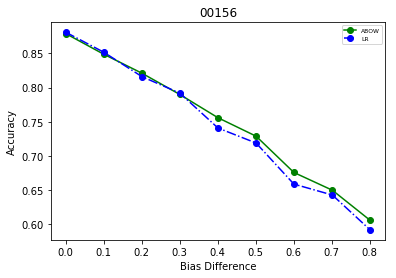

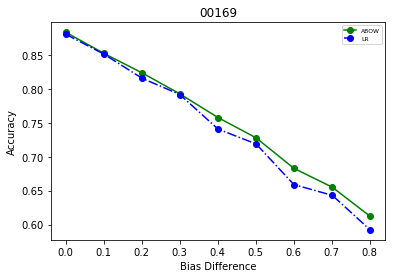

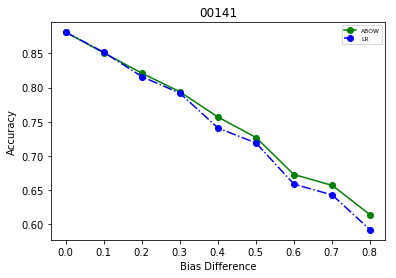

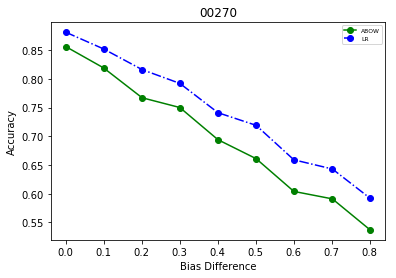

In [33]:
#BEST GOT = EPOCH = 169
%matplotlib inline
plt.cla()
plt.clf()
plt.close()
for path in models[15:]:
    abow.model.load_weights(path)
    epoch = path.split('/')[2].split('.')[1]
    accuracy_abow = []
    accuracy_lr = []
    f1_abow = []
    f1_lr = []
    bias_diff=[]
    for d_test in d.iterate_biased_datasets(kind='test'):
        pred_abow = abow.predict(d_test).argmax(axis=1)
        pred_lr = lr.predict(d_test.X)
        accuracy_abow.append(metrics.accuracy_score(d_test.y,pred_abow))
        accuracy_lr.append(metrics.accuracy_score(d_test.y,pred_lr))
        f1_abow.append(metrics.f1_score(d_test.y,pred_abow))
        f1_lr.append(metrics.f1_score(d_test.y,pred_lr))
        bias_diff.append(d_test.get_bias()-train_d[0].get_bias())
    fig, ax = plt.subplots()
    ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
    ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
    plt.legend(prop = {'size':6})
    plt.xlabel('Bias Difference')
    plt.ylabel('Accuracy')
    plt.title(epoch)

### Sanity check


In [26]:
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]
abow = models[5]
lr = models[3]
from keras.callbacks import ModelCheckpoint
#mcp = ModelCheckpoint('./models/model.{epoch:02d}.hdf5',save_weights_only=True)
abow.fit(train_d[0],epochs=300,batch_size=16)
lr.fit(train_d[0].X, train_d[0].y)

GradientReversal6
Epoch 1/300
1000/1000 [==============================] - 1s 1ms/step - loss: 2.6901 - y_loss: 0.8003 - z_loss: 1.8898
Epoch 2/300
1000/1000 [==============================] - 1s 511us/step - loss: 1.9519 - y_loss: 0.5114 - z_loss: 1.4405
Epoch 3/300
1000/1000 [==============================] - 1s 572us/step - loss: 1.7657 - y_loss: 0.2747 - z_loss: 1.4909
Epoch 4/300
1000/1000 [==============================] - 1s 613us/step - loss: 0.6384 - y_loss: 0.1198 - z_loss: 0.5186
Epoch 5/300
1000/1000 [==============================] - 0s 431us/step - loss: 0.3960 - y_loss: 0.0654 - z_loss: 0.3306
Epoch 6/300
1000/1000 [==============================] - 1s 540us/step - loss: 0.7088 - y_loss: 0.1083 - z_loss: 0.6006
Epoch 7/300
1000/1000 [==============================] - 1s 600us/step - loss: 0.7684 - y_loss: 0.1217 - z_loss: 0.6467
Epoch 8/300
1000/1000 [==============================] - 1s 501us/step - loss: 0.7527 - y_loss: 0.0957 - z_loss: 0.6570
Epoch 9/300
1000/1000 [=

1000/1000 [==============================] - 1s 564us/step - loss: 0.4893 - y_loss: 0.0378 - z_loss: 0.4515
Epoch 136/300
1000/1000 [==============================] - 1s 614us/step - loss: 0.5330 - y_loss: 0.0377 - z_loss: 0.4953
Epoch 137/300
1000/1000 [==============================] - 1s 548us/step - loss: 0.5026 - y_loss: 0.0377 - z_loss: 0.4649
Epoch 138/300
1000/1000 [==============================] - 1s 553us/step - loss: 0.7411 - y_loss: 0.0543 - z_loss: 0.6869
Epoch 139/300
1000/1000 [==============================] - 1s 557us/step - loss: 0.5455 - y_loss: 0.0699 - z_loss: 0.4756
Epoch 140/300
1000/1000 [==============================] - 0s 453us/step - loss: 0.5155 - y_loss: 0.0699 - z_loss: 0.4455
Epoch 141/300
1000/1000 [==============================] - 1s 502us/step - loss: 0.5754 - y_loss: 0.0747 - z_loss: 0.5007
Epoch 142/300
1000/1000 [==============================] - 1s 563us/step - loss: 0.5832 - y_loss: 0.1303 - z_loss: 0.4528
Epoch 143/300
1000/1000 [=============

1000/1000 [==============================] - 0s 427us/step - loss: 0.6254 - y_loss: 0.1349 - z_loss: 0.4905
Epoch 270/300
1000/1000 [==============================] - 0s 430us/step - loss: 0.7672 - y_loss: 0.2730 - z_loss: 0.4941
Epoch 271/300
1000/1000 [==============================] - 1s 511us/step - loss: 0.8219 - y_loss: 0.3104 - z_loss: 0.5115
Epoch 272/300
1000/1000 [==============================] - 0s 461us/step - loss: 0.6699 - y_loss: 0.1907 - z_loss: 0.4791
Epoch 273/300
1000/1000 [==============================] - 1s 573us/step - loss: 0.7311 - y_loss: 0.1922 - z_loss: 0.5389
Epoch 274/300
1000/1000 [==============================] - 1s 628us/step - loss: 0.6669 - y_loss: 0.1665 - z_loss: 0.5004
Epoch 275/300
1000/1000 [==============================] - 1s 569us/step - loss: 0.6131 - y_loss: 0.1664 - z_loss: 0.4468
Epoch 276/300
1000/1000 [==============================] - 1s 517us/step - loss: 0.6601 - y_loss: 0.1664 - z_loss: 0.4937
Epoch 277/300
1000/1000 [=============

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [32]:
abow.inv_factor

0.8

In [28]:
accuracy_abow = []
accuracy_lr = []
f1_abow = []
f1_lr = []
bias_diff=[]
for d_test in d.iterate_biased_datasets(kind='test'):
    pred_abow = abow.predict(d_test).argmax(axis=1)
    pred_lr = lr.predict(d_test.X)
    accuracy_abow.append(metrics.accuracy_score(d_test.y,pred_abow))
    accuracy_lr.append(metrics.accuracy_score(d_test.y,pred_lr))
    f1_abow.append(metrics.f1_score(d_test.y,pred_abow))
    f1_lr.append(metrics.f1_score(d_test.y,pred_lr))
    bias_diff.append(d_test.get_bias()-train_d[0].get_bias())

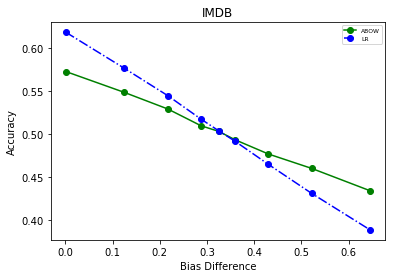

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.title('IMDB')
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')

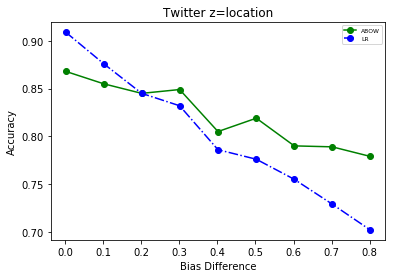

In [20]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.title('Twitter z={}'.format(zstr))
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')

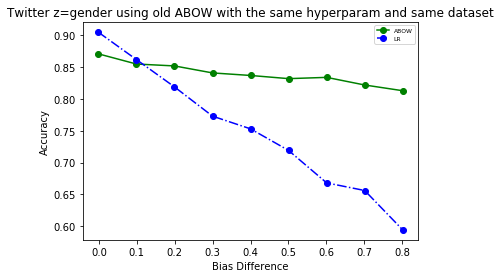

In [24]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.title('Twitter z={} using old ABOW with the same hyperparam and same dataset'.format(zstr))
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')

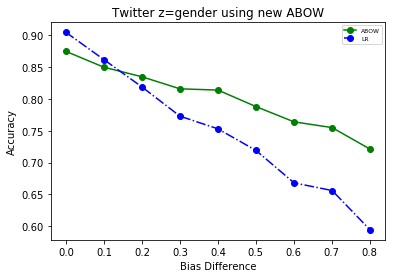

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.title('Twitter z={} using new ABOW'.format(zstr))
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')

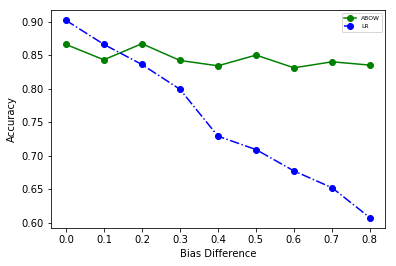

In [11]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, accuracy_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,accuracy_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('Accuracy')

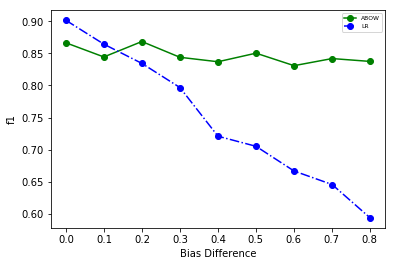

In [12]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(bias_diff, f1_abow,'go-',label = 'ABOW')
ax.plot(bias_diff,f1_lr,'bo-.',label = 'LR')
plt.legend(prop = {'size':6})
plt.xlabel('Bias Difference')
plt.ylabel('f1')